In [1]:
import numpy as np
import pandas as pd
import os
import glob
import random
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf


### Data in /data/tvanasse/nccam3/data directory

In [31]:
subdirs = []
for file in glob.glob('/data/tvanasse/nccam3/data/sub-2*'):
    subdirs.append(file)
subdirs.sort()
print("Subjects with cleaned data: " + str(len(subdirs)))

sesdirs = []
for i in range(0,len(subdirs)):
    for file in glob.glob(subdirs[i] + '/eeg/*'):
        sesdirs.append(file)
print("Nights cleaned: " + str(len(sesdirs)))

Subjects with cleaned data: 87
Nights cleaned: 127


In [32]:
sesdirs

['/data/tvanasse/nccam3/data/sub-2000/eeg/ses-1',
 '/data/tvanasse/nccam3/data/sub-2001/eeg/ses-3',
 '/data/tvanasse/nccam3/data/sub-2002/eeg/ses-2',
 '/data/tvanasse/nccam3/data/sub-2003/eeg/ses-3',
 '/data/tvanasse/nccam3/data/sub-2004/eeg/ses-3',
 '/data/tvanasse/nccam3/data/sub-2005/eeg/ses-3',
 '/data/tvanasse/nccam3/data/sub-2006/eeg/ses-1',
 '/data/tvanasse/nccam3/data/sub-2006/eeg/ses-2',
 '/data/tvanasse/nccam3/data/sub-2007/eeg/ses-2',
 '/data/tvanasse/nccam3/data/sub-2008/eeg/ses-1',
 '/data/tvanasse/nccam3/data/sub-2008/eeg/ses-2',
 '/data/tvanasse/nccam3/data/sub-2008/eeg/ses-3',
 '/data/tvanasse/nccam3/data/sub-2009/eeg/ses-1',
 '/data/tvanasse/nccam3/data/sub-2009/eeg/ses-2',
 '/data/tvanasse/nccam3/data/sub-2010/eeg/ses-1',
 '/data/tvanasse/nccam3/data/sub-2020/eeg/ses-1',
 '/data/tvanasse/nccam3/data/sub-2022/eeg/ses-1',
 '/data/tvanasse/nccam3/data/sub-2022/eeg/ses-2',
 '/data/tvanasse/nccam3/data/sub-2023/eeg/ses-2',
 '/data/tvanasse/nccam3/data/sub-2024/eeg/ses-1',


In [40]:
nrem_dataframe = pd.read_csv('nrem_dataframe.csv')
hold_out_validation_set = nrem_dataframe[nrem_dataframe["HOLD_OUT"] == True]["PATH"].tolist()
len(hold_out_validation_set)

126

In [41]:
data = pd.read_csv(sesdirs[0] + "/awakening_table.txt", sep=",") # to access columns
nrem_dataframe = pd.DataFrame(columns=data.columns)

for i in range(0,len(sesdirs)):
    if os.path.exists(sesdirs[i] + "/awakening_table.txt"):
        data = pd.read_csv(sesdirs[i] + "/awakening_table.txt", sep=",")

        for file in glob.glob(sesdirs[i] + '/*cleaned2_nrem.set'):
            ent_m_awakening = int(file[file.find("awakening-") + 10:file.find("-cleaned2")]) # entry matched awakening number

            nrem_dataframe = nrem_dataframe.append(data[data["ENTRY_MATCHED_AWAKENING_NO"] == ent_m_awakening], ignore_index=True)
            
            nrem_dataframe.loc[len(nrem_dataframe)-1,"PATH"] = file # add path to recently appended row
            nrem_dataframe.loc[len(nrem_dataframe)-1,"SES_PATH"] = sesdirs[i] # add sesssion path to recently appended row
            nrem_dataframe.loc[len(nrem_dataframe)-1,"PATH_UNIQUE"] = file.split("sub-",1)[1] 
            
            if file in hold_out_validation_set:
                nrem_dataframe.loc[len(nrem_dataframe)-1,"HOLD_OUT"] = True
            else:
                nrem_dataframe.loc[len(nrem_dataframe)-1,"HOLD_OUT"] = False
            
nrem_dataframe.to_csv('nrem_dataframe.csv', index=False)

/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [44]:
nrem_awakenings = []
nrem_awakenings_per_ses = []
all_awakenings_per_ses = []

hold_out_validation_set = []

for i in range(0,len(sesdirs)):
    
    for file in glob.glob(sesdirs[i] + '/*cleaned2_nrem.set'):
        nrem_awakenings.append(file)
        
    if len(glob.glob(sesdirs[i] + '/*cleaned2_nrem.set')) == 0:
        print("No cleaned files in session: " + sesdirs[i])
        continue
        
    if len(glob.glob(sesdirs[i] + '/*awakening_table*')) == 0:
        print("No awakenings table: " + sesdirs[i])

    nrem_awakenings_per_ses.append(len(glob.glob(sesdirs[i] + '/*cleaned2_nrem.set')))
    all_awakenings_per_ses.append(len(glob.glob(sesdirs[i] + '/*scoring.png')))
    
    if sesdirs[i] not in nrem_dataframe['SES_PATH'].values:
        hold_out_validation_set.append(glob.glob(sesdirs[i] + '/*cleaned2_nrem.set')[random.randint(0, len(glob.glob(sesdirs[i] + '/*cleaned2_nrem.set'))-1)])
    

### New data to hold out (resave nrem_dataframe)

In [46]:
hold_out_validation_set

[]

In [47]:
# populate entire hold_out_validation_set list
for i in range(0,len(nrem_dataframe[nrem_dataframe["HOLD_OUT"] == True]["PATH"].values)):
    hold_out_validation_set.append(nrem_dataframe[nrem_dataframe["HOLD_OUT"] == True]["PATH"].values[i])

print("Held-out data: " + str(len(hold_out_validation_set)) + " awakenings, " +\
      str(np.round(len(hold_out_validation_set)/len(nrem_awakenings)*100)) + "% of all NREM data")

Held-out data: 126 awakenings, 15.0% of all NREM data


In [48]:
print("NREM awakenings : " + str(len(nrem_dataframe)))
print("ALL awakenings : " + str(np.sum(all_awakenings_per_ses)))
print("Average NREM awakenings per session: {:0.2f}".format(np.average(np.array(nrem_awakenings_per_ses))))
print("Median NREM awakenings per session: {:0.2f}".format(np.median(np.array(nrem_awakenings_per_ses))))

NREM awakenings : 809
ALL awakenings : 1149
Average NREM awakenings per session: 6.43
Median NREM awakenings per session: 6.00


In [49]:
data = pd.read_csv(sesdirs[0] + "/awakening_table.txt", sep=",") # to access columns
nrem_dataframe = pd.DataFrame(columns=data.columns)

for i in range(0,len(sesdirs)):
    if os.path.exists(sesdirs[i] + "/awakening_table.txt"):
        data = pd.read_csv(sesdirs[i] + "/awakening_table.txt", sep=",")

        for file in glob.glob(sesdirs[i] + '/*cleaned2_nrem.set'):
            ent_m_awakening = int(file[file.find("awakening-") + 10:file.find("-cleaned2")]) # entry matched awakening number

            nrem_dataframe = nrem_dataframe.append(data[data["ENTRY_MATCHED_AWAKENING_NO"] == ent_m_awakening], ignore_index=True)
            
            nrem_dataframe.loc[len(nrem_dataframe)-1,"PATH"] = file # add path to recently appended row
            nrem_dataframe.loc[len(nrem_dataframe)-1,"SES_PATH"] = sesdirs[i] # add sesssion path to recently appended row
        
            
            if file in hold_out_validation_set:
                nrem_dataframe.loc[len(nrem_dataframe)-1,"HOLD_OUT"] = True
            else:
                nrem_dataframe.loc[len(nrem_dataframe)-1,"HOLD_OUT"] = False

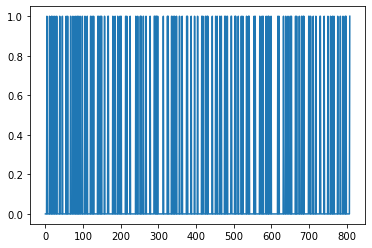

In [50]:
plt.plot(nrem_dataframe["HOLD_OUT"])

In [51]:
nrem_dataframe

,DIFF_FROM_EVENT_SECONDS,DIN_EVENTS_WITHIN_TWO_MINUTES,Date,Date_Time,ENTRY_MATCHED_AWAKENING_NO,FILE_NOT_FOUND,HOLD_OUT,ID,Int,MFF_FILE_HAS_NO_EVENTS_TO_IMPORT,...,Q7,Q8,Q9,REM,SA,SES_PATH,Stage,Time,Visit,WAKE
0,75.592,2,NaN,11/19/0014 03:42,5,NaN,False,2000,RA,NaN,...,1.0,3.0,0.0,0,5,/data/tvanasse/nccam3/data/sub-2000/eeg/ses-1,2.0,3:42 AM,1,1
1,224.648,1,NaN,11/19/0014 01:00,1,NaN,False,2000,RA,NaN,...,1.0,3.0,0.0,0,1,/data/tvanasse/nccam3/data/sub-2000/eeg/ses-1,2.0,1:00 AM,1,1
2,38.338,1,NaN,11/19/0014 06:07,9,NaN,False,2000,RA,NaN,...,2.0,1.0,1.0,0,9,/data/tvanasse/nccam3/data/sub-2000/eeg/ses-1,NaN,6:07 AM,1,1
3,38.636,1,NaN,11/19/0014 05:08,7,NaN,False,2000,RA,NaN,...,1.0,2.0,0.0,0,7,/data/tvanasse/nccam3/data/sub-2000/eeg/ses-1,2.0,5:08 AM,1,1
4,66.265,1,NaN,11/19/0014 01:38,2,NaN,True,2000,RA,NaN,...,0.0,1.0,1.0,0,2,/data/tvanasse/nccam3/data/sub-2000/eeg/ses-1,2.0,1:38 AM,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,18.918,1,NaN,11/10/0017 03:59,7,NaN,False,2144,AMV,NaN,...,0.0,2.0,0.0,0,7,/data/tvanasse/nccam3/data/sub-2144/eeg/ses-3,2.0,3:59 AM,3,1
805,71.029,1,NaN,11/10/0017 05:21,10,NaN,False,2144,AMV,NaN,...,5.0,0.0,0.0,0,10,/data/tvanasse/nccam3/data/sub-2144/eeg/ses-3,2.0,5:21 AM,3,1
806,9.895,1,NaN,11/10/0017 01:10,2,NaN,False,2144,AMV,NaN,...,NaN,NaN,NaN,0,2,/data/tvanasse/nccam3/data/sub-2144/eeg/ses-3,2.0,1:10 AM,3,1
807,12.393,1,NaN,11/10/0017 01:30,3,NaN,False,2144,AMV,NaN,...,0.0,2.0,0.0,0,3,/data/tvanasse/nccam3/data/sub-2144/eeg/ses-3,2.0,1:30 AM,3,1


In [39]:
nrem_dataframe.to_csv('nrem_dataframe.csv', index=False)

### What portion of awakenings are NREM?

Text(0.5, 0, 'Awakenings/Night')

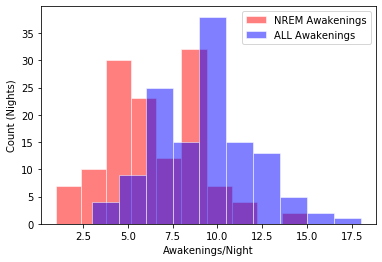

In [53]:
plt.figure()
ax = plt.gca()
ax.hist(nrem_awakenings_per_ses, color='red', edgecolor='white', alpha=0.5, label="NREM Awakenings")[0]
ax.hist(all_awakenings_per_ses, color='blue', edgecolor='white', alpha=0.5, label="ALL Awakenings")[0]
plt.legend()
plt.ylabel("Count (Nights)")
plt.xlabel("Awakenings/Night")

In [54]:
import mne

cleaned_length = []
for i in range(0,len(nrem_awakenings)):
    x = mne.io.read_raw_eeglab(nrem_awakenings[i])
    cleaned_length.append(len(x))

Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-5-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-1-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-9-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-2-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-3-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-8-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-4-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2001/eeg/ses-3/awakening-5-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2001/eeg/ses-3/awakening-1-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2001/eeg/ses-3/awakening-6-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2001/eeg/ses-3/awakening-2-cleaned2_n

Reading /data/tvanasse/nccam3/data/sub-2022/eeg/ses-1/awakening-1-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2022/eeg/ses-1/awakening-2-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2022/eeg/ses-1/awakening-3-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2022/eeg/ses-1/awakening-4-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2022/eeg/ses-2/awakening-8-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2022/eeg/ses-2/awakening-1-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2022/eeg/ses-2/awakening-3-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2022/eeg/ses-2/awakening-5-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2022/eeg/ses-2/awakening-7-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2023/eeg/ses-2/awakening-5-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2023/eeg/ses-2/awakening-1-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2023/eeg/ses-2/awakening-7-cleaned2_n

Reading /data/tvanasse/nccam3/data/sub-2037/eeg/ses-1/awakening-2-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2037/eeg/ses-1/awakening-4-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2037/eeg/ses-1/awakening-5-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2037/eeg/ses-3/awakening-1-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2037/eeg/ses-3/awakening-7-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2037/eeg/ses-3/awakening-2-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2037/eeg/ses-3/awakening-8-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2037/eeg/ses-3/awakening-3-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2037/eeg/ses-3/awakening-4-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2041/eeg/ses-1/awakening-1-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2041/eeg/ses-1/awakening-6-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2041/eeg/ses-1/awakening-9-cleaned2_n

Reading /data/tvanasse/nccam3/data/sub-2053/eeg/ses-2/awakening-2-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2053/eeg/ses-2/awakening-3-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2053/eeg/ses-2/awakening-4-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2054/eeg/ses-1/awakening-2-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2054/eeg/ses-1/awakening-3-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2054/eeg/ses-2/awakening-1-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2054/eeg/ses-2/awakening-2-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2054/eeg/ses-2/awakening-3-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2054/eeg/ses-3/awakening-5-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2054/eeg/ses-3/awakening-7-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2054/eeg/ses-3/awakening-8-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2055/eeg/ses-2/awakening-8-cleaned2_n

Reading /data/tvanasse/nccam3/data/sub-2066/eeg/ses-3/awakening-9-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2067/eeg/ses-1/awakening-1-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2067/eeg/ses-1/awakening-5-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2067/eeg/ses-1/awakening-8-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2067/eeg/ses-1/awakening-10-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2067/eeg/ses-1/awakening-2-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2067/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2067/eeg/ses-1/awakening-3-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2067/eeg/ses-1/awakening-4-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2067/eeg/ses-2/awakening-1-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2067/eeg/ses-2/awakening-5-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2067/eeg/ses-2/awakening-8-cleaned2_

Reading /data/tvanasse/nccam3/data/sub-2076/eeg/ses-3/awakening-10-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2076/eeg/ses-3/awakening-3-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2076/eeg/ses-3/awakening-8-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2076/eeg/ses-3/awakening-12-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2076/eeg/ses-3/awakening-7-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2076/eeg/ses-3/awakening-2-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2078/eeg/ses-1/awakening-1-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2078/eeg/ses-1/awakening-6-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2078/eeg/ses-1/awakening-2-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2078/eeg/ses-1/awakening-3-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2078/eeg/ses-1/awakening-4-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2078/eeg/ses-3/awakening-12-cleaned

Reading /data/tvanasse/nccam3/data/sub-2096/eeg/ses-1/awakening-1-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2096/eeg/ses-1/awakening-6-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2096/eeg/ses-1/awakening-2-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2096/eeg/ses-1/awakening-3-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2096/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2096/eeg/ses-1/awakening-4-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2099/eeg/ses-3/awakening-2-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2099/eeg/ses-3/awakening-7-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2099/eeg/ses-3/awakening-8-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2099/eeg/ses-3/awakening-4-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2099/eeg/ses-3/awakening-5-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2099/eeg/ses-3/awakening-6-cleaned2_n

Reading /data/tvanasse/nccam3/data/sub-2123/eeg/ses-1/awakening-3-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2123/eeg/ses-1/awakening-5-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2123/eeg/ses-2/awakening-1-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2123/eeg/ses-2/awakening-2-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2123/eeg/ses-2/awakening-3-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2123/eeg/ses-2/awakening-4-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2126/eeg/ses-1/awakening-1-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2126/eeg/ses-1/awakening-6-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2126/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2126/eeg/ses-1/awakening-2-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2126/eeg/ses-1/awakening-3-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2126/eeg/ses-1/awakening-8-cleaned2_n

Reading /data/tvanasse/nccam3/data/sub-2142/eeg/ses-1/awakening-1-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2142/eeg/ses-1/awakening-4-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2142/eeg/ses-1/awakening-5-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2142/eeg/ses-1/awakening-12-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2142/eeg/ses-1/awakening-8-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2142/eeg/ses-1/awakening-2-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2142/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2142/eeg/ses-1/awakening-3-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2142/eeg/ses-1/awakening-9-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2142/eeg/ses-3/awakening-1-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2142/eeg/ses-3/awakening-6-cleaned2_nrem.fdt
Reading /data/tvanasse/nccam3/data/sub-2142/eeg/ses-3/awakening-7-cleaned2_

In [18]:
# raw = mne.io.read_raw_eeglab(nrem_awakenings[10])
# # raw.plot()
# mne.viz.plot_raw_psd(raw,1,50)

### How much data was cleaned? How many bad components were there?

4.665116666666666

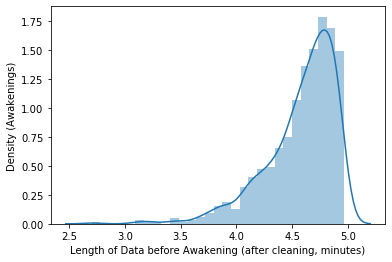

In [23]:
ax = sns.distplot(np.array(cleaned_length)/(500*60),
                  kde=True)
plt.ylabel('Density (Awakenings)')
plt.xlabel('Length of Data before Awakening (after cleaning, minutes)');

np.median(np.array(cleaned_length)/(500*60))

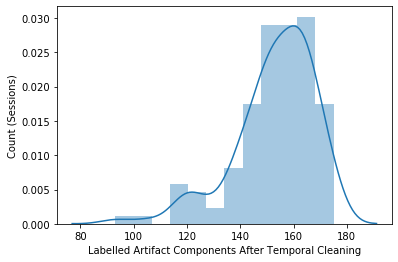

In [24]:
import scipy.io
artifact_components = []
for i in range(0,len(sesdirs)):
    if os.path.exists(sesdirs[i] + '/ic_artifacts.mat'):
        mat = scipy.io.loadmat(sesdirs[i] + '/ic_artifacts.mat')
        artifact_components.append(len(np.squeeze(mat['ic_artifacts_all'])))
        
# plt.hist(,bins=50)  # `density=False` would make counts
ax = sns.distplot(np.array(artifact_components),
                  kde=True)
plt.ylabel('Count (Sessions)')
plt.xlabel('Labelled Artifact Components After Temporal Cleaning');

Populating the interactive namespace from numpy and matplotlib
/data/tvanasse/nccam3/data/sub-2000/eeg/ses-1


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mat', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


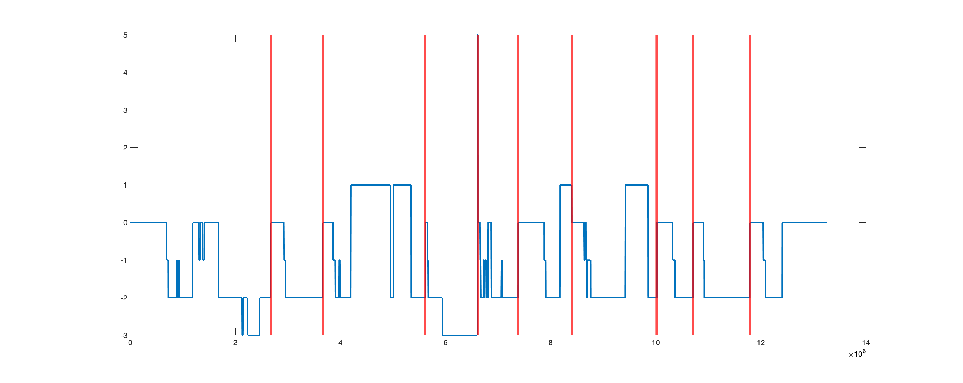

/data/tvanasse/nccam3/data/sub-2001/eeg/ses-3


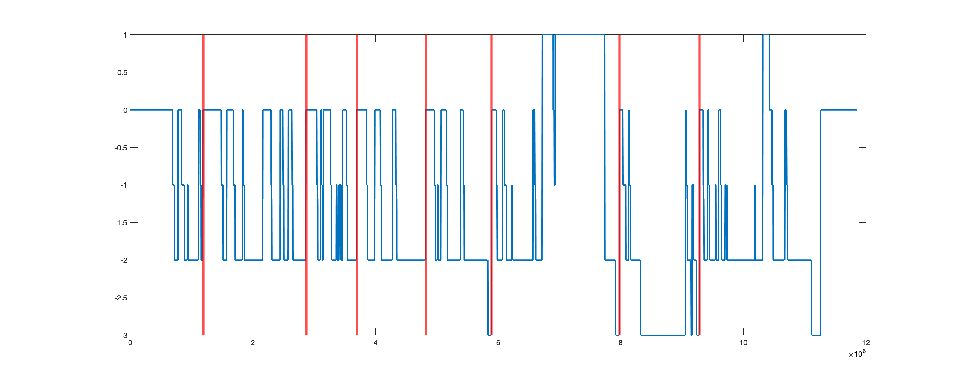

/data/tvanasse/nccam3/data/sub-2002/eeg/ses-2


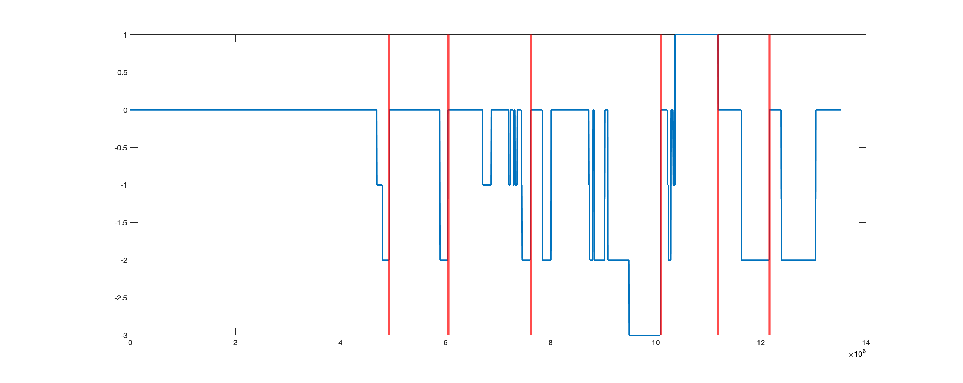

/data/tvanasse/nccam3/data/sub-2003/eeg/ses-3


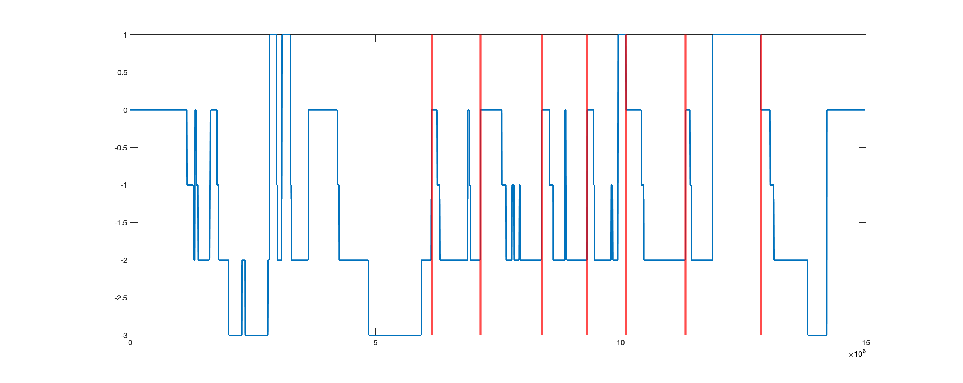

/data/tvanasse/nccam3/data/sub-2004/eeg/ses-3


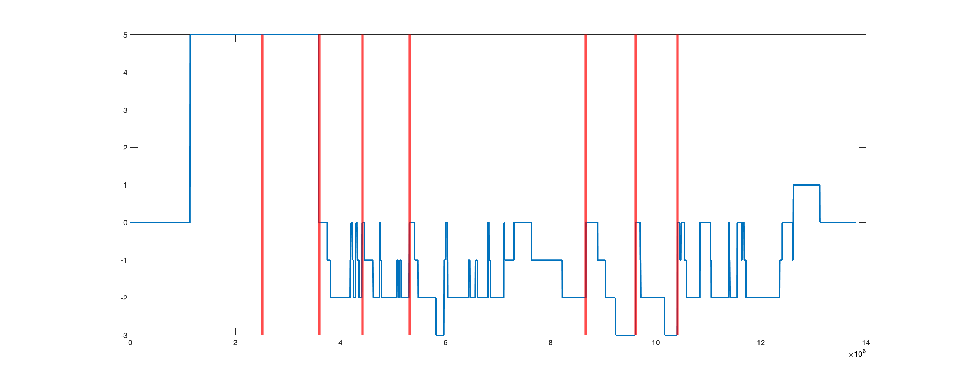

/data/tvanasse/nccam3/data/sub-2005/eeg/ses-3


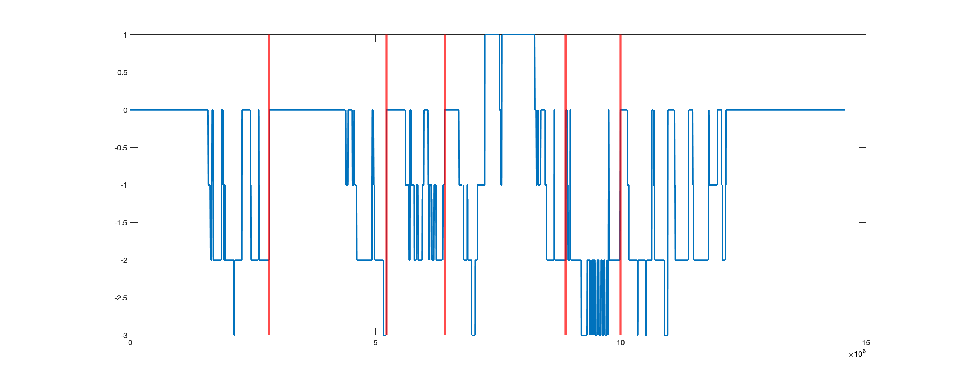

/data/tvanasse/nccam3/data/sub-2006/eeg/ses-1


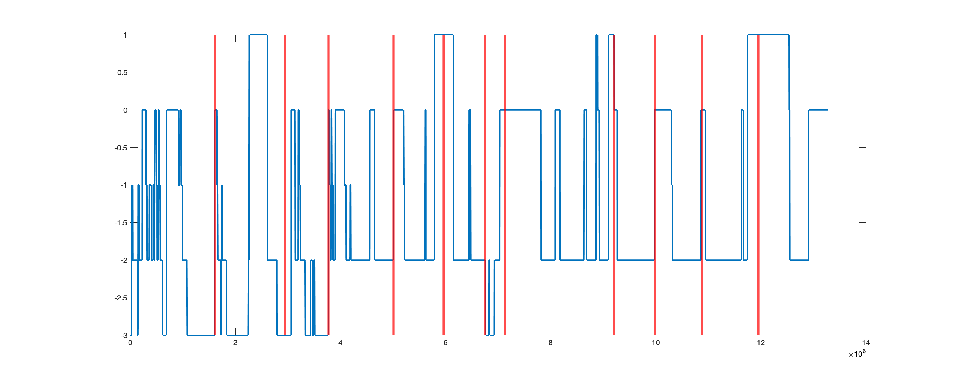

/data/tvanasse/nccam3/data/sub-2006/eeg/ses-2


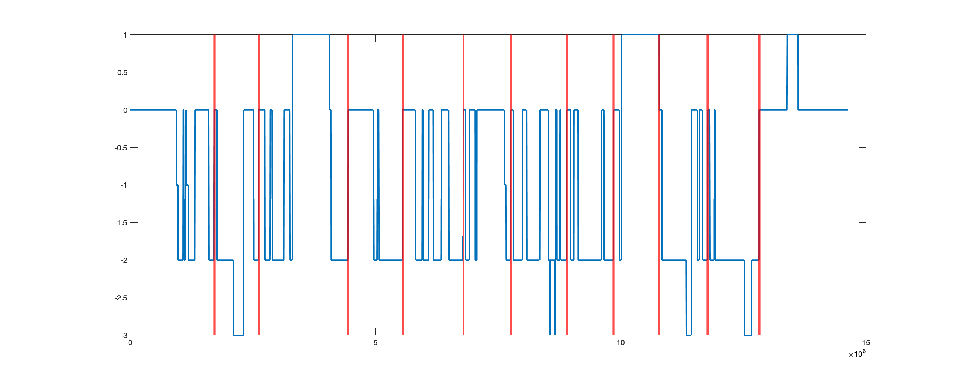

/data/tvanasse/nccam3/data/sub-2007/eeg/ses-2


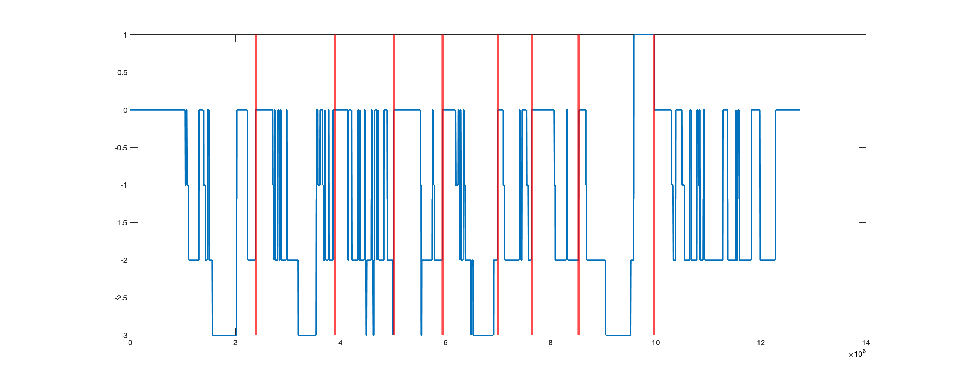

/data/tvanasse/nccam3/data/sub-2008/eeg/ses-1


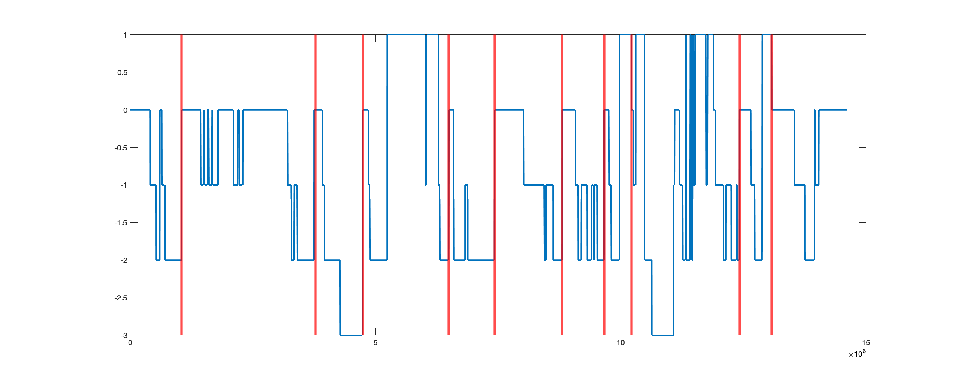

/data/tvanasse/nccam3/data/sub-2008/eeg/ses-2


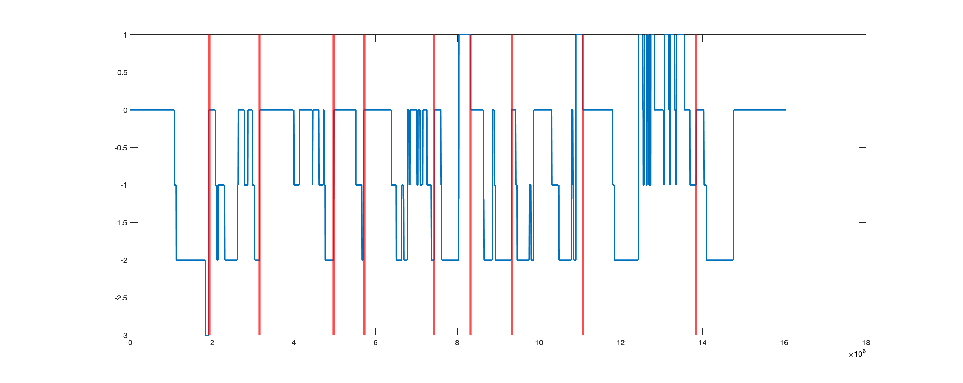

/data/tvanasse/nccam3/data/sub-2008/eeg/ses-3


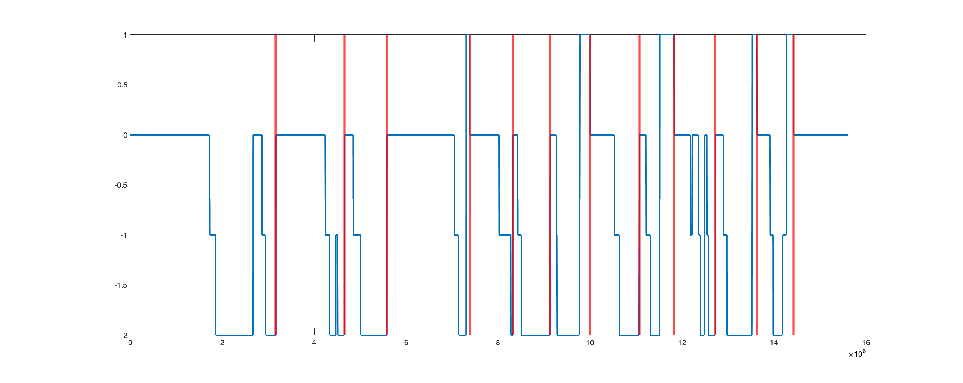

/data/tvanasse/nccam3/data/sub-2009/eeg/ses-1


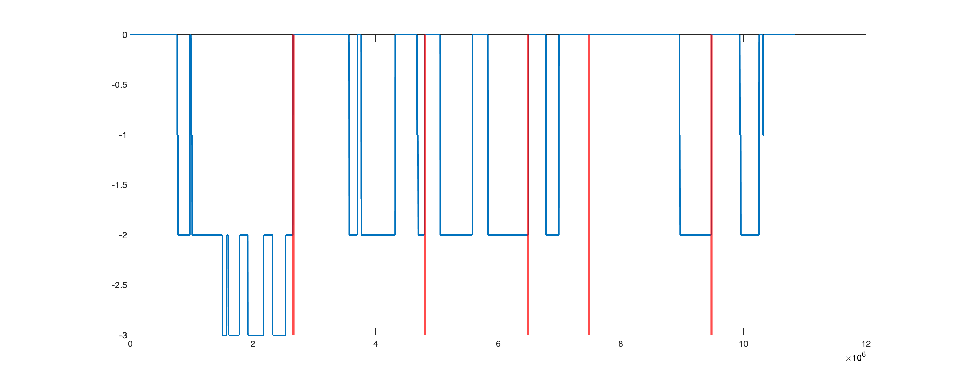

/data/tvanasse/nccam3/data/sub-2009/eeg/ses-2


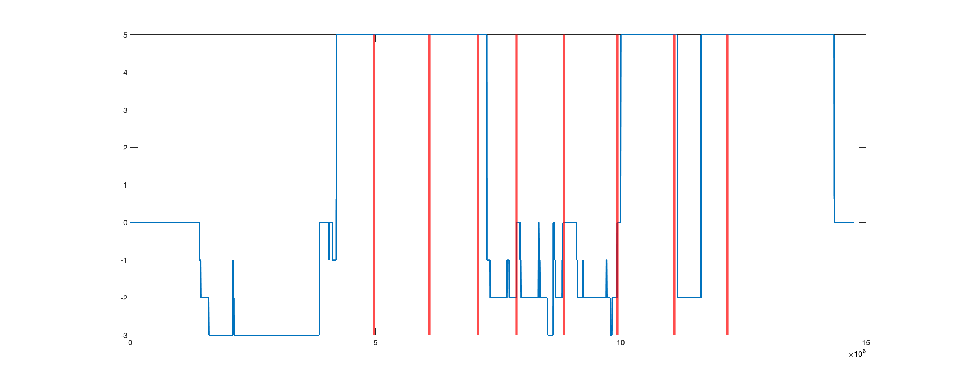

/data/tvanasse/nccam3/data/sub-2010/eeg/ses-1


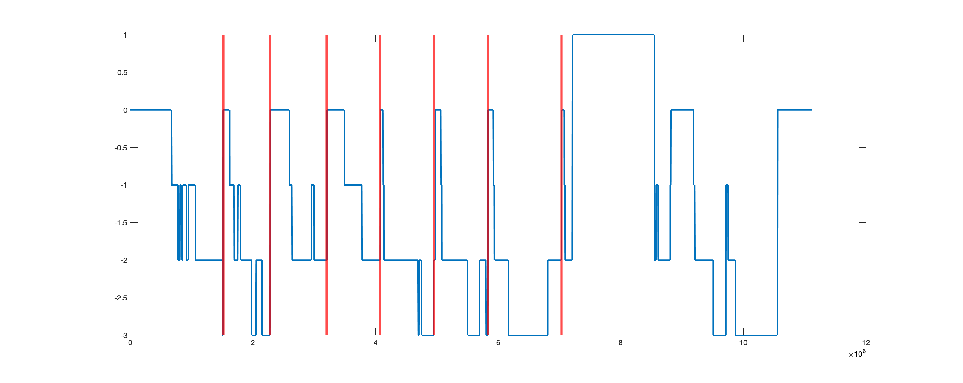

/data/tvanasse/nccam3/data/sub-2020/eeg/ses-1


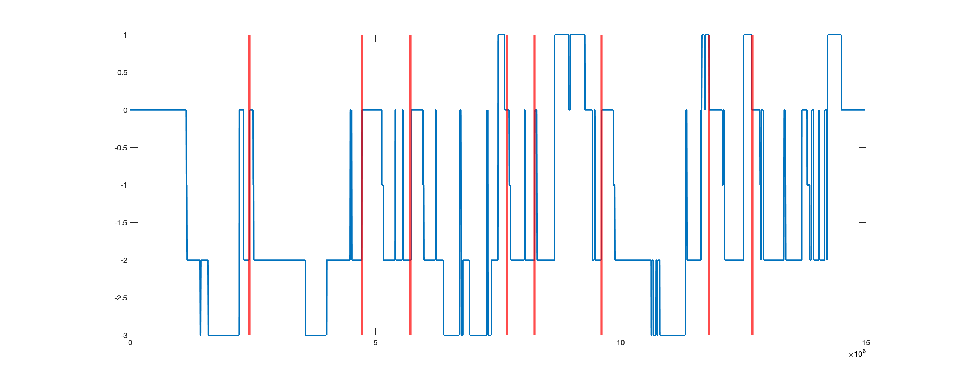

/data/tvanasse/nccam3/data/sub-2022/eeg/ses-1


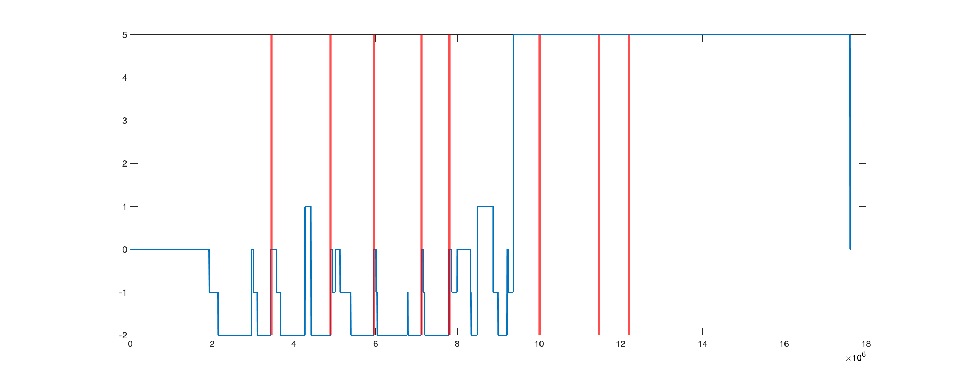

/data/tvanasse/nccam3/data/sub-2022/eeg/ses-2


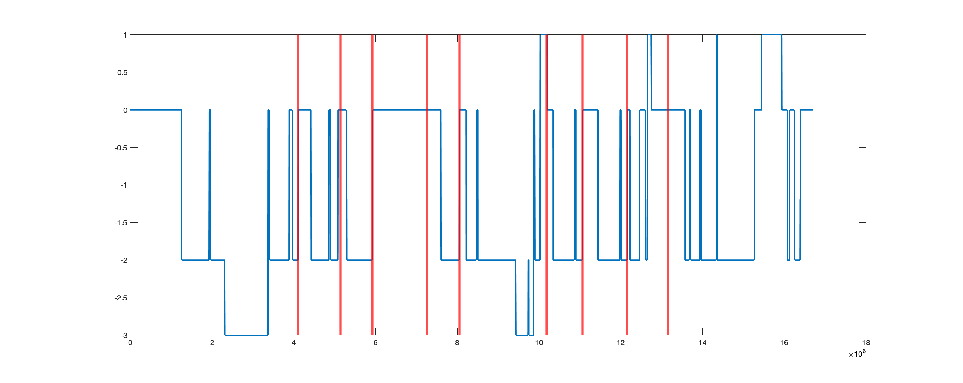

/data/tvanasse/nccam3/data/sub-2023/eeg/ses-2


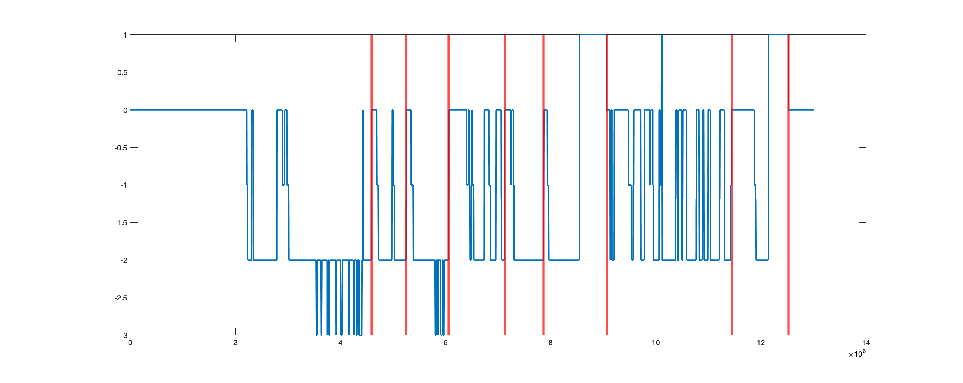

/data/tvanasse/nccam3/data/sub-2024/eeg/ses-1


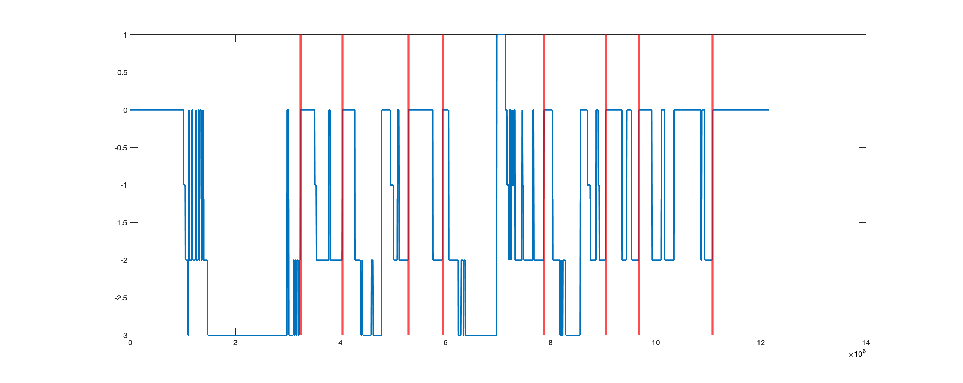

/data/tvanasse/nccam3/data/sub-2026/eeg/ses-1


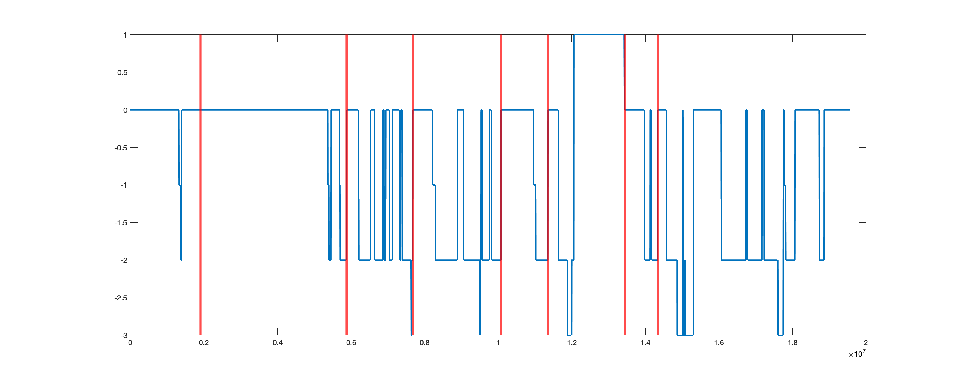

/data/tvanasse/nccam3/data/sub-2028/eeg/ses-1


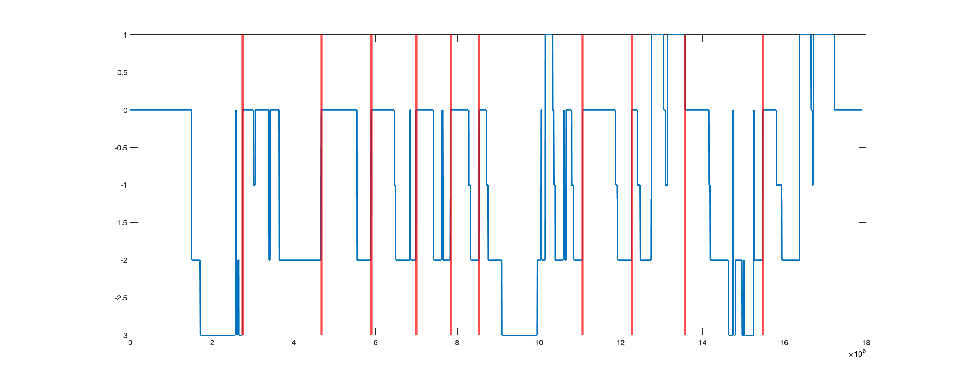

/data/tvanasse/nccam3/data/sub-2028/eeg/ses-3


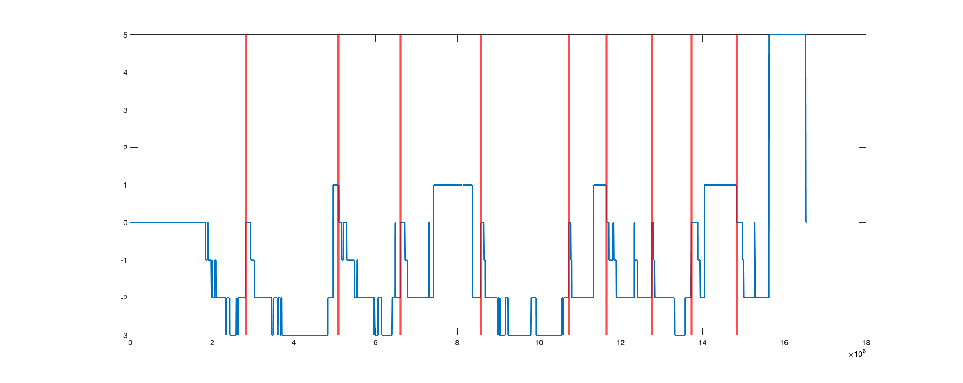

/data/tvanasse/nccam3/data/sub-2029/eeg/ses-1


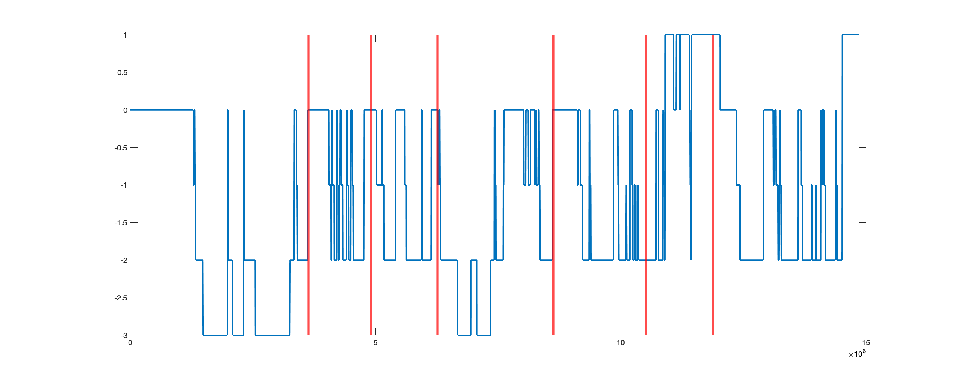

/data/tvanasse/nccam3/data/sub-2029/eeg/ses-2


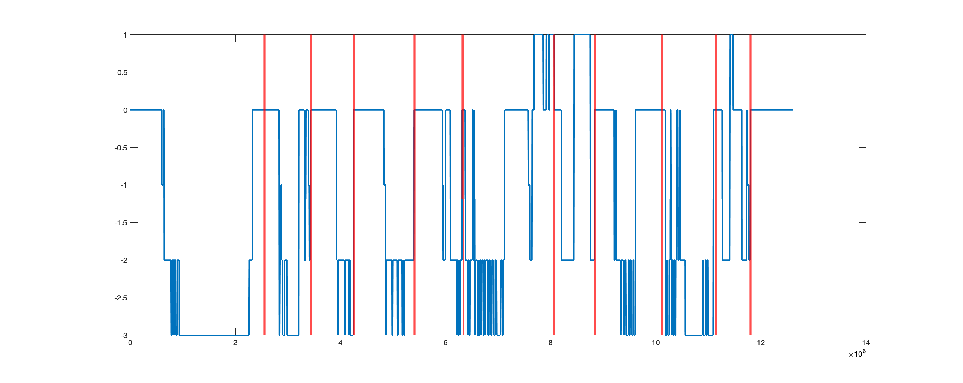

/data/tvanasse/nccam3/data/sub-2030/eeg/ses-1


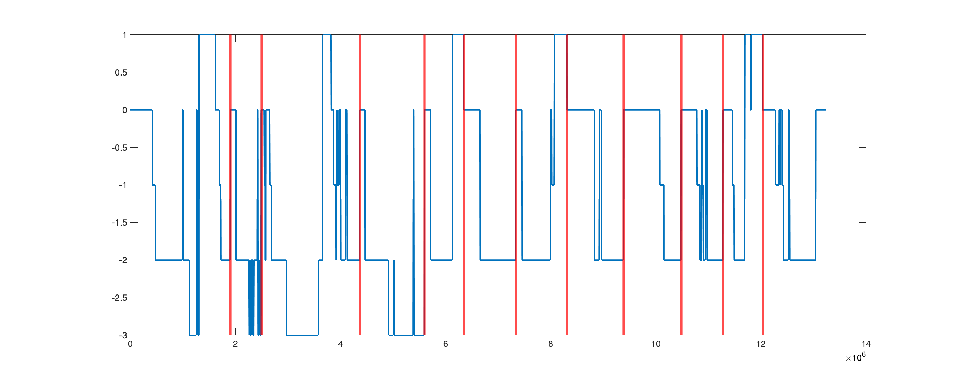

/data/tvanasse/nccam3/data/sub-2031/eeg/ses-1


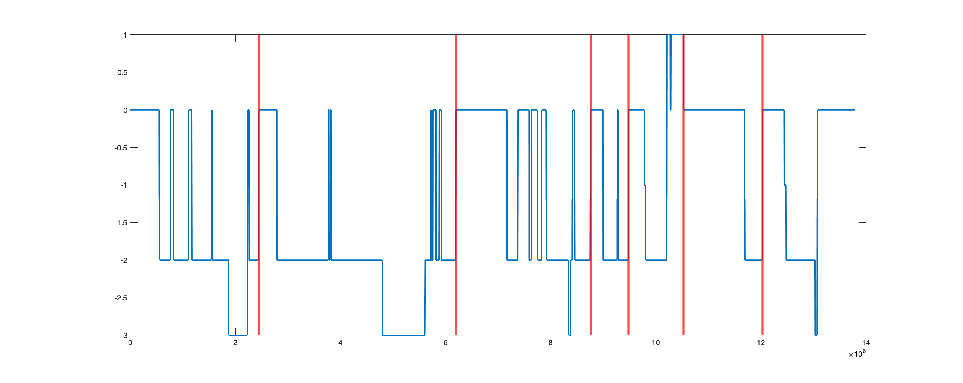

/data/tvanasse/nccam3/data/sub-2032/eeg/ses-1


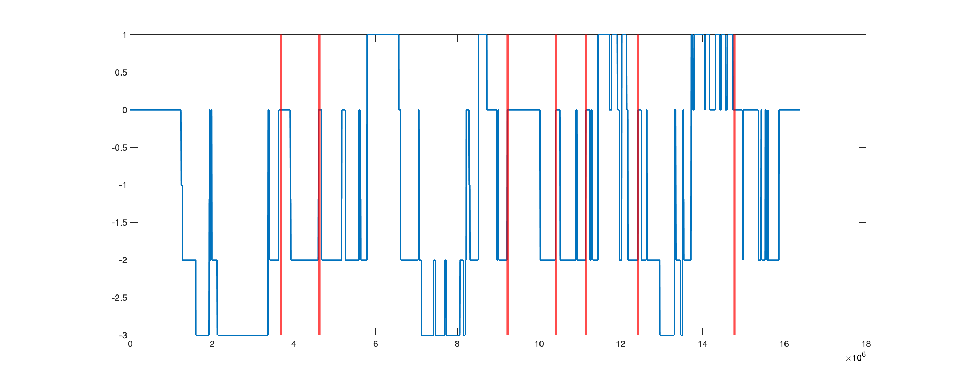

/data/tvanasse/nccam3/data/sub-2032/eeg/ses-2


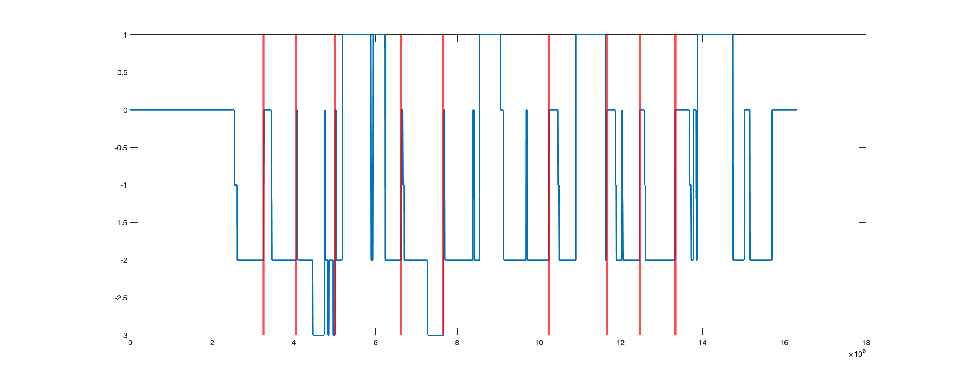

NO AWAKENINGS PLOT: /data/tvanasse/nccam3/data/sub-2032/eeg/ses-3
/data/tvanasse/nccam3/data/sub-2034/eeg/ses-1


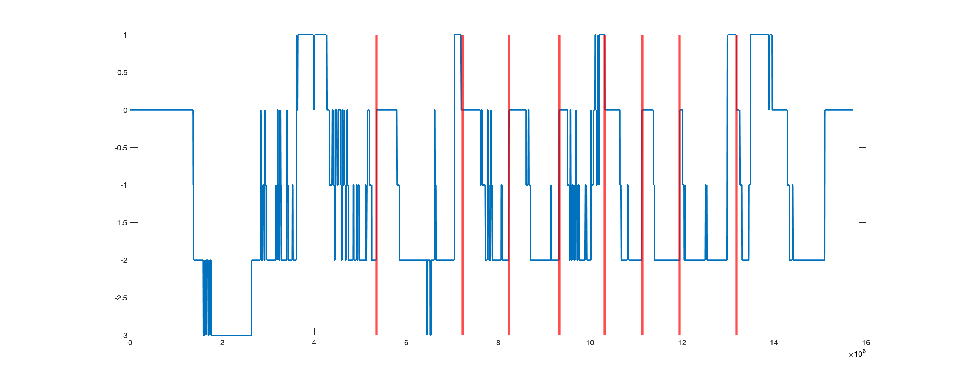

/data/tvanasse/nccam3/data/sub-2035/eeg/ses-2


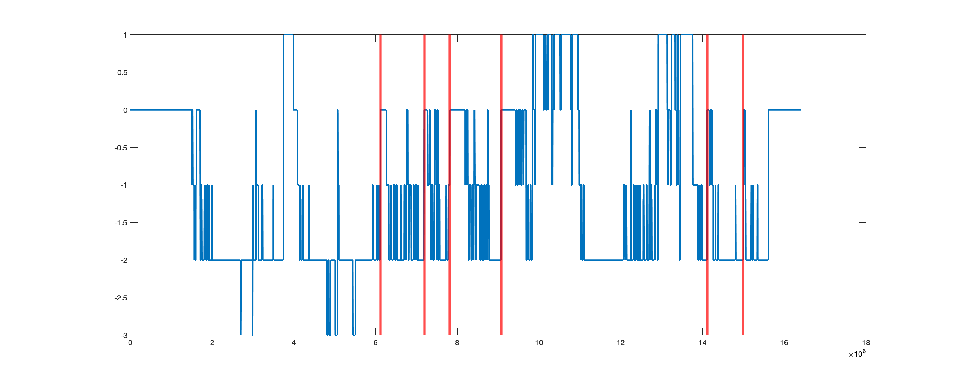

/data/tvanasse/nccam3/data/sub-2037/eeg/ses-1


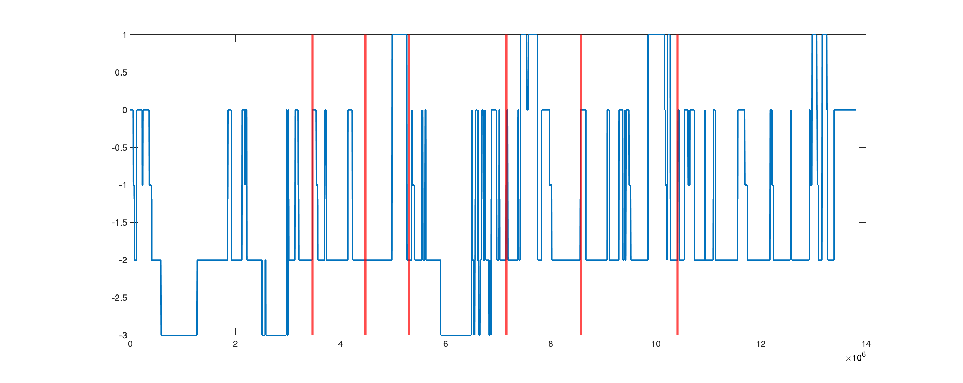

/data/tvanasse/nccam3/data/sub-2037/eeg/ses-3


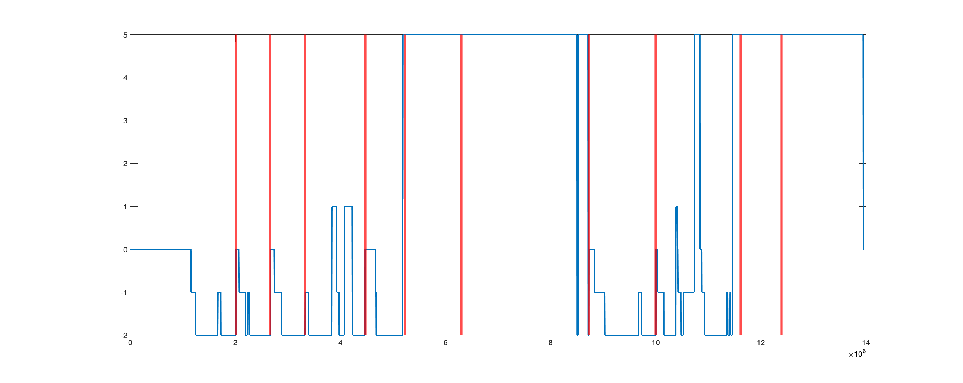

/data/tvanasse/nccam3/data/sub-2041/eeg/ses-1


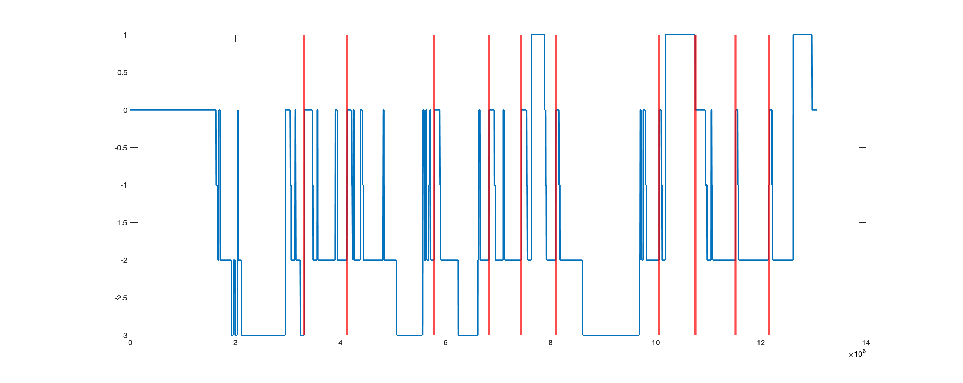

/data/tvanasse/nccam3/data/sub-2042/eeg/ses-1


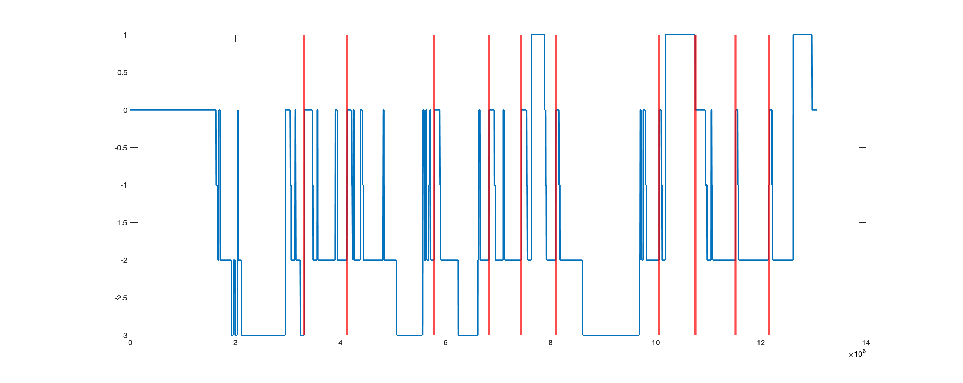

/data/tvanasse/nccam3/data/sub-2042/eeg/ses-3


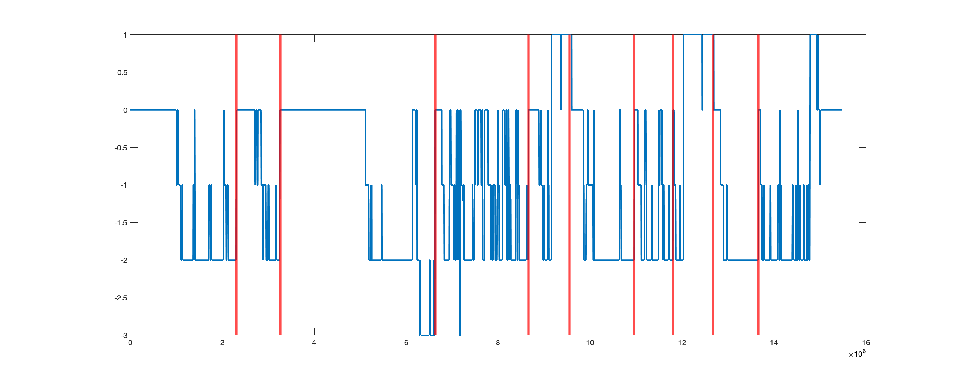

/data/tvanasse/nccam3/data/sub-2043/eeg/ses-2


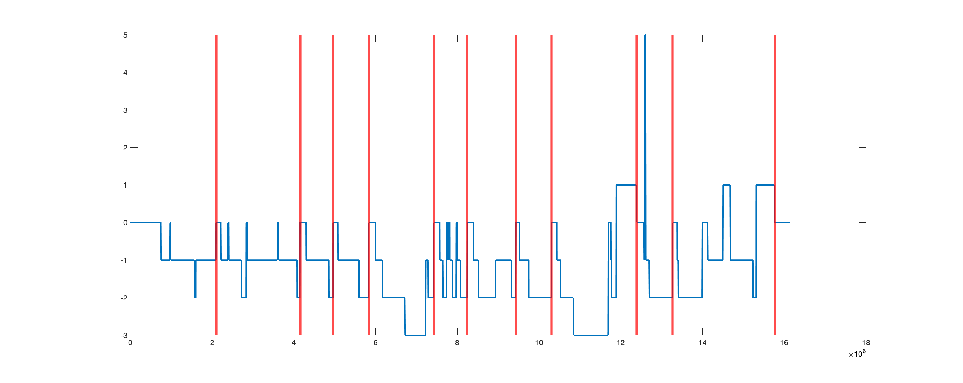

/data/tvanasse/nccam3/data/sub-2047/eeg/ses-3


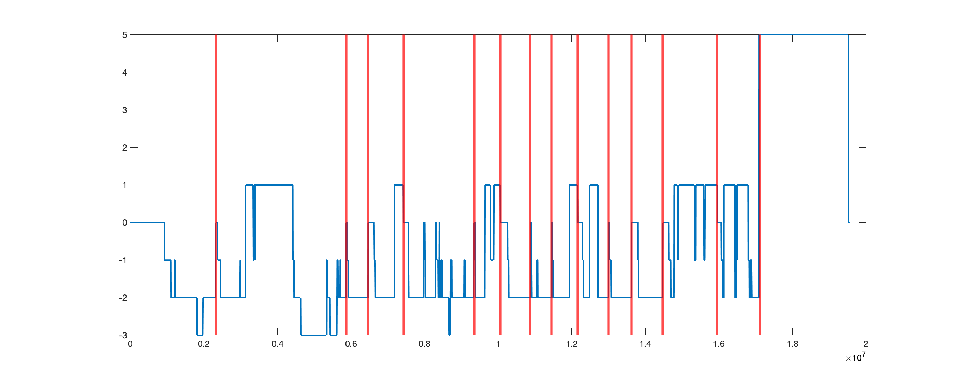

/data/tvanasse/nccam3/data/sub-2048/eeg/ses-1


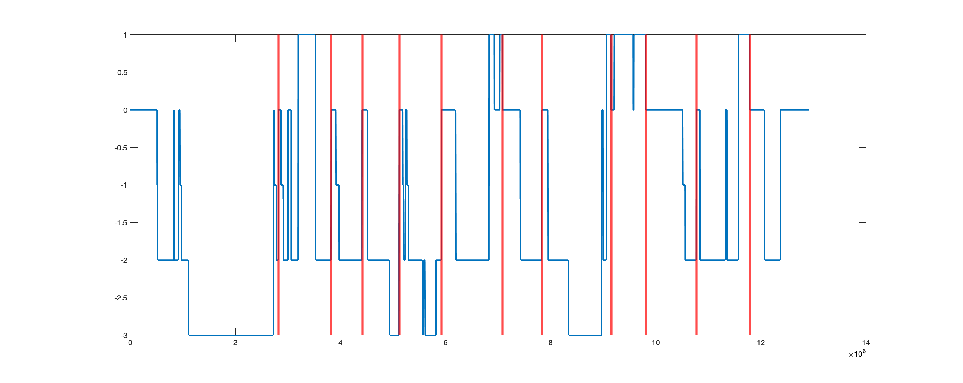

/data/tvanasse/nccam3/data/sub-2048/eeg/ses-2


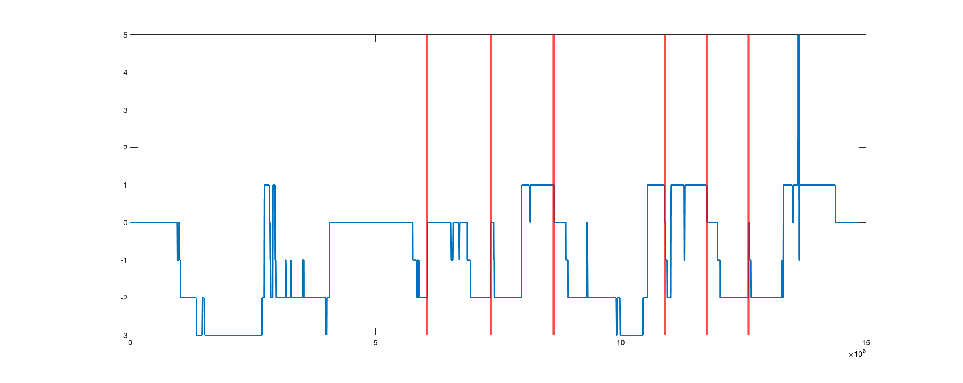

/data/tvanasse/nccam3/data/sub-2049/eeg/ses-2


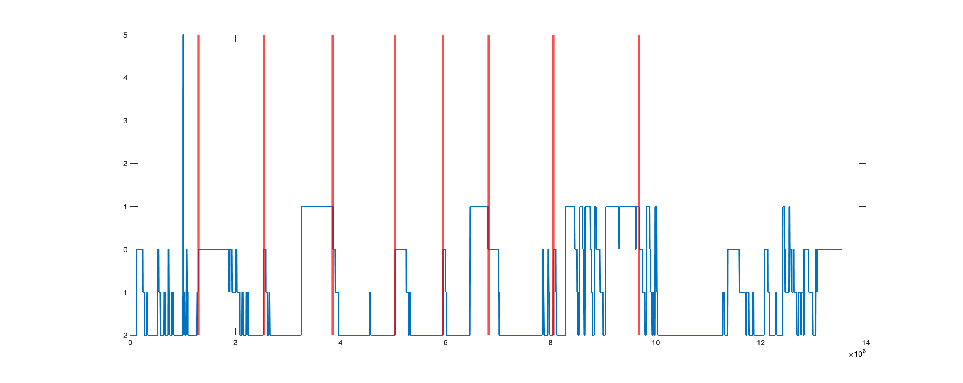

/data/tvanasse/nccam3/data/sub-2049/eeg/ses-3


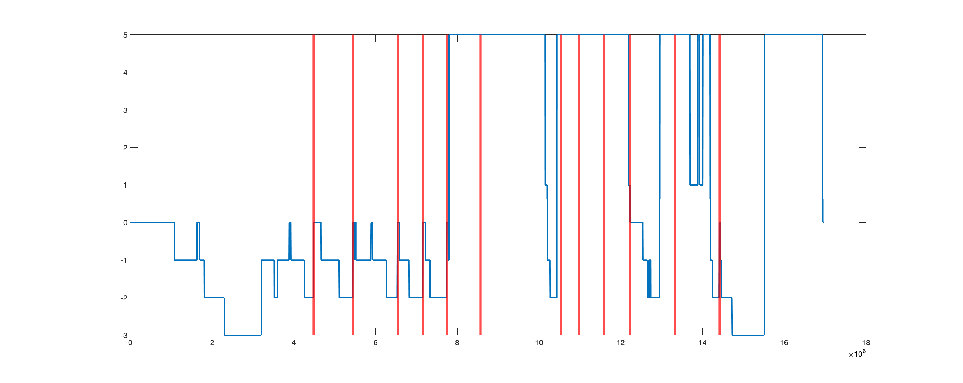

/data/tvanasse/nccam3/data/sub-2052/eeg/ses-1


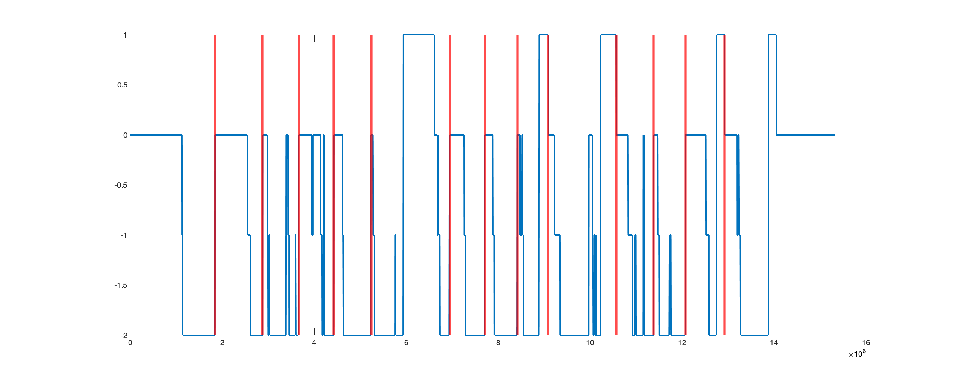

/data/tvanasse/nccam3/data/sub-2052/eeg/ses-3


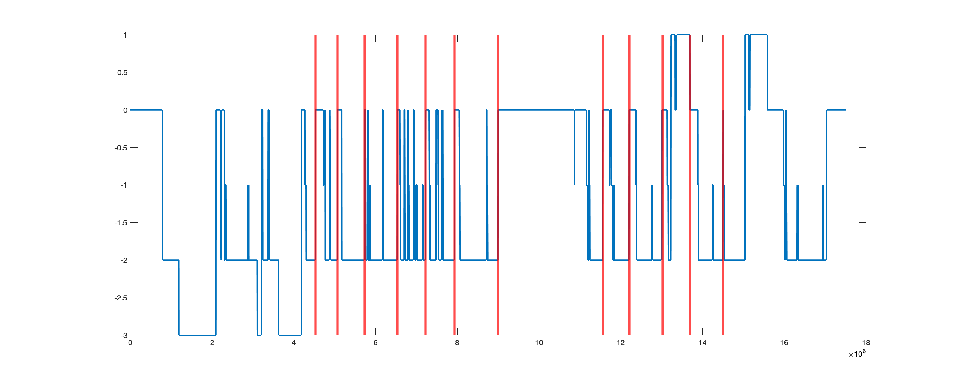

/data/tvanasse/nccam3/data/sub-2053/eeg/ses-2


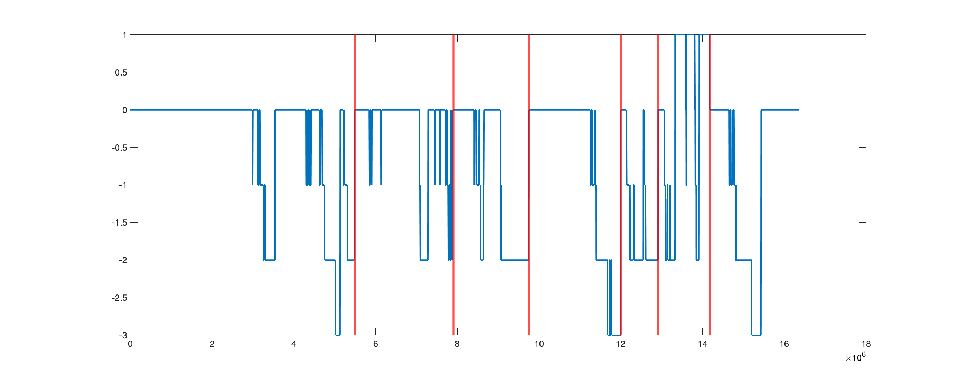

/data/tvanasse/nccam3/data/sub-2054/eeg/ses-1


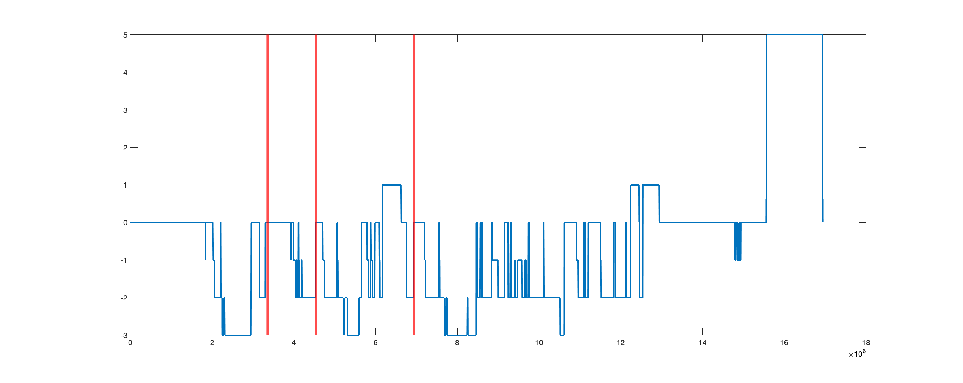

/data/tvanasse/nccam3/data/sub-2054/eeg/ses-2


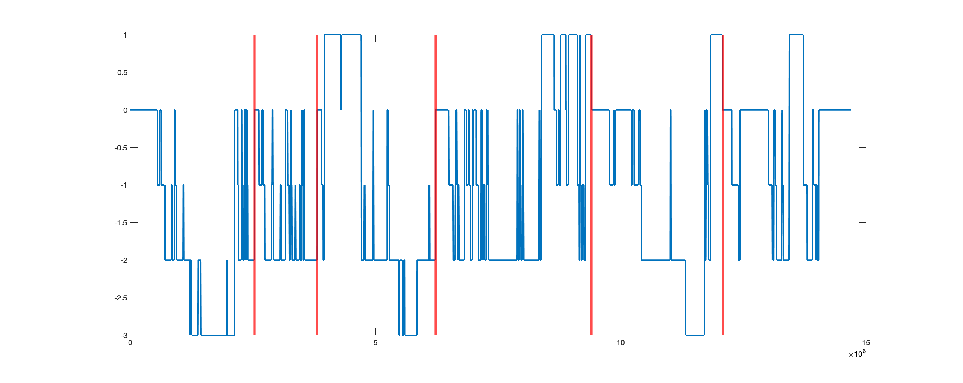

/data/tvanasse/nccam3/data/sub-2054/eeg/ses-3


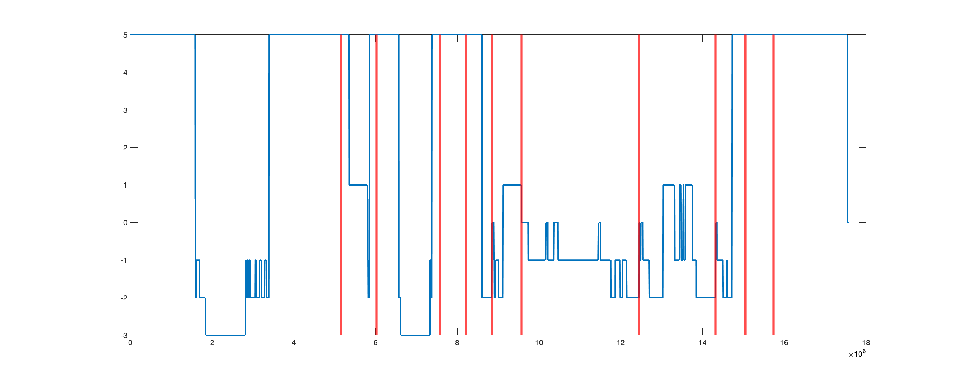

/data/tvanasse/nccam3/data/sub-2055/eeg/ses-2


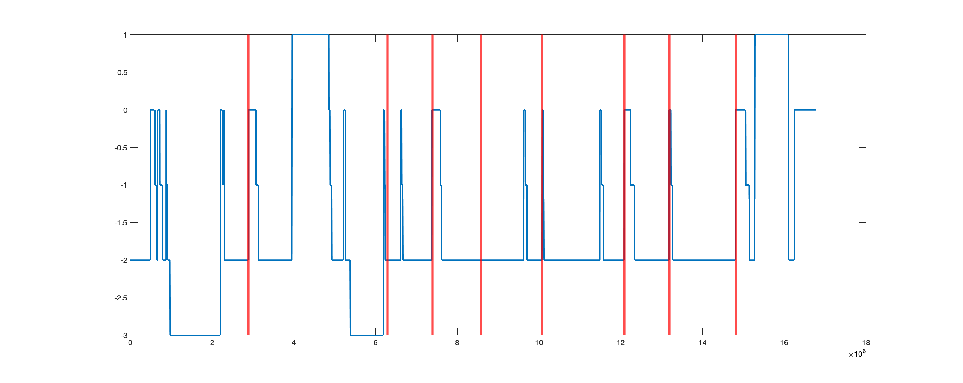

/data/tvanasse/nccam3/data/sub-2057/eeg/ses-1


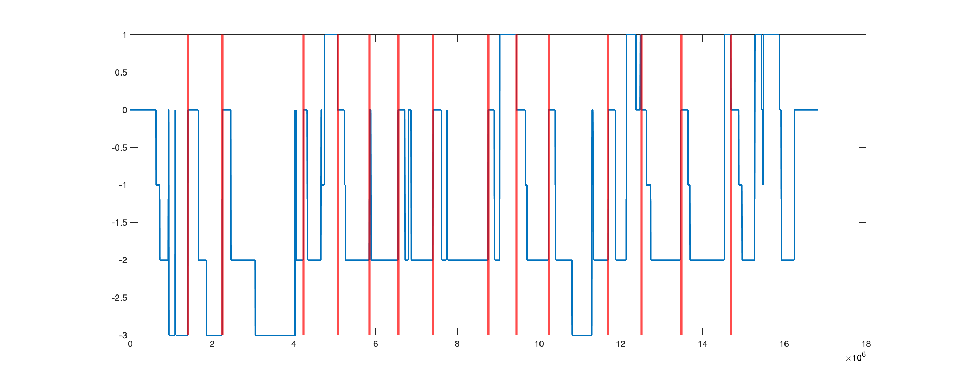

/data/tvanasse/nccam3/data/sub-2058/eeg/ses-1


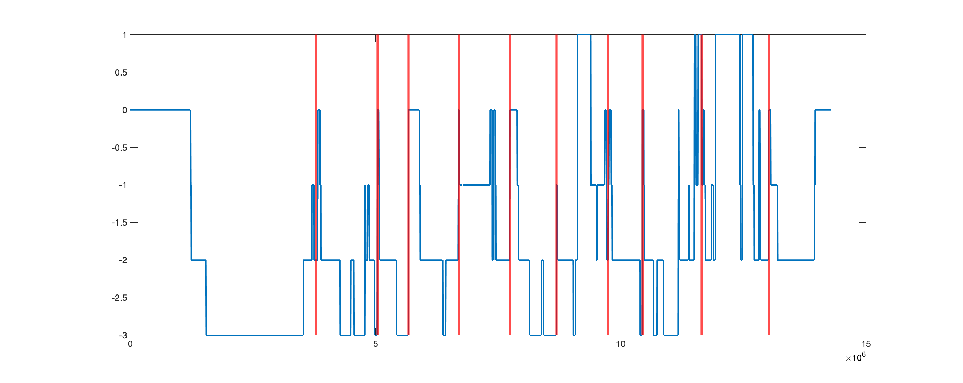

/data/tvanasse/nccam3/data/sub-2058/eeg/ses-2


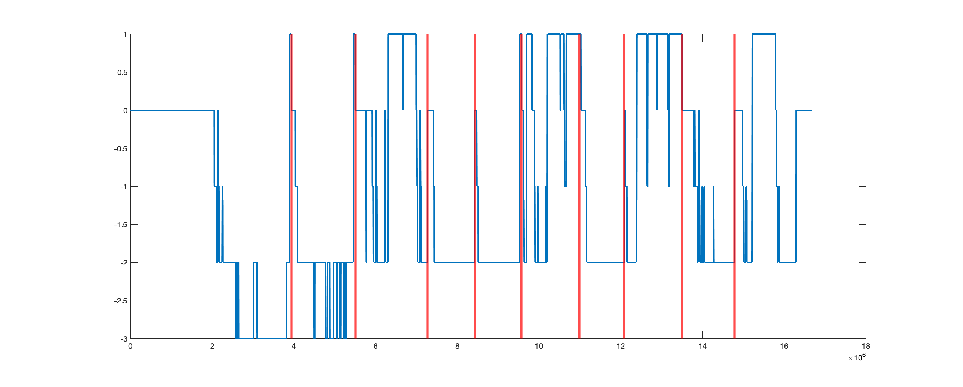

/data/tvanasse/nccam3/data/sub-2060/eeg/ses-1


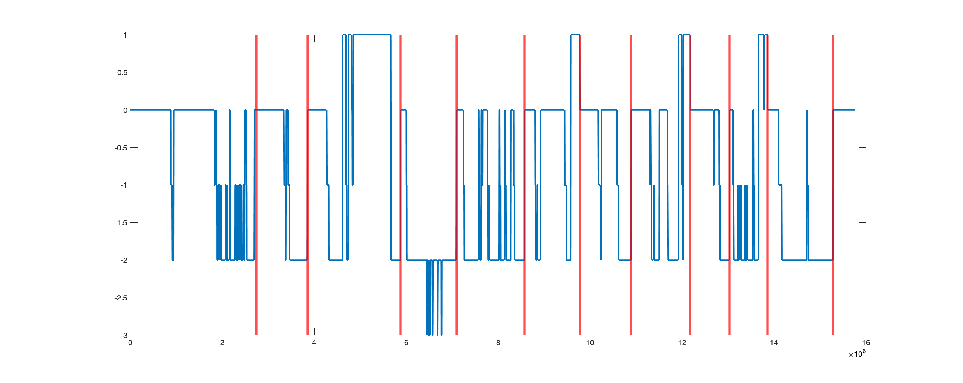

/data/tvanasse/nccam3/data/sub-2060/eeg/ses-2


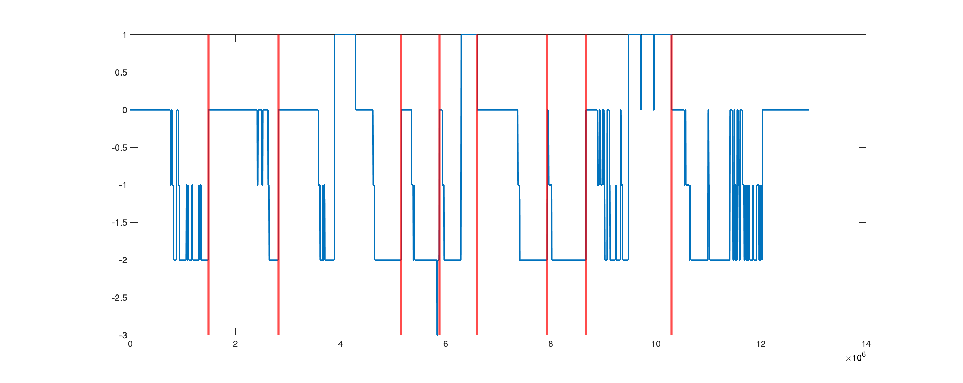

/data/tvanasse/nccam3/data/sub-2061/eeg/ses-1


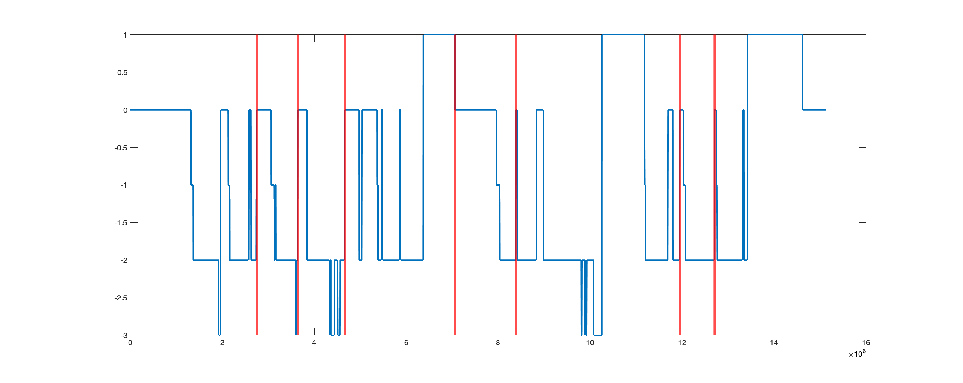

/data/tvanasse/nccam3/data/sub-2063/eeg/ses-2


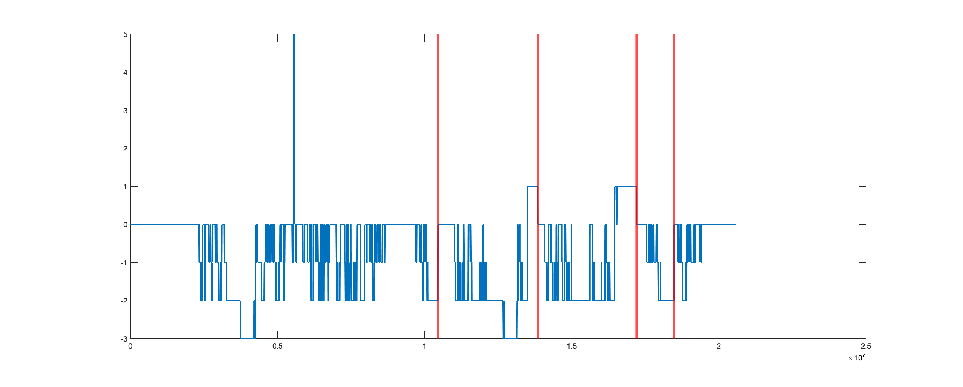

/data/tvanasse/nccam3/data/sub-2063/eeg/ses-3


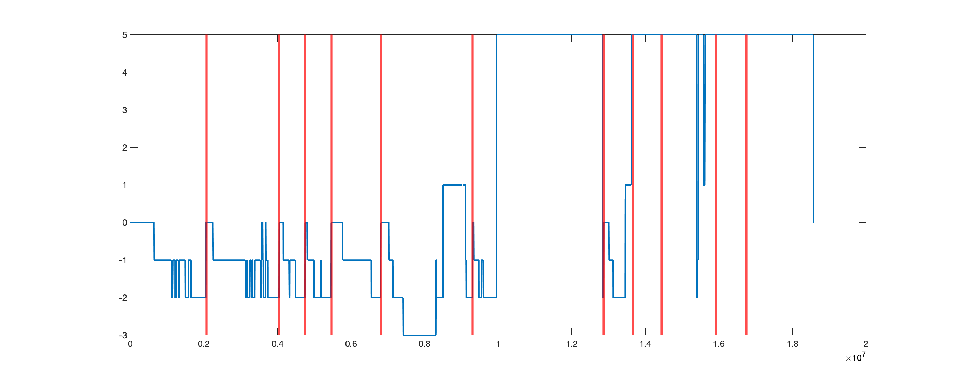

/data/tvanasse/nccam3/data/sub-2064/eeg/ses-2


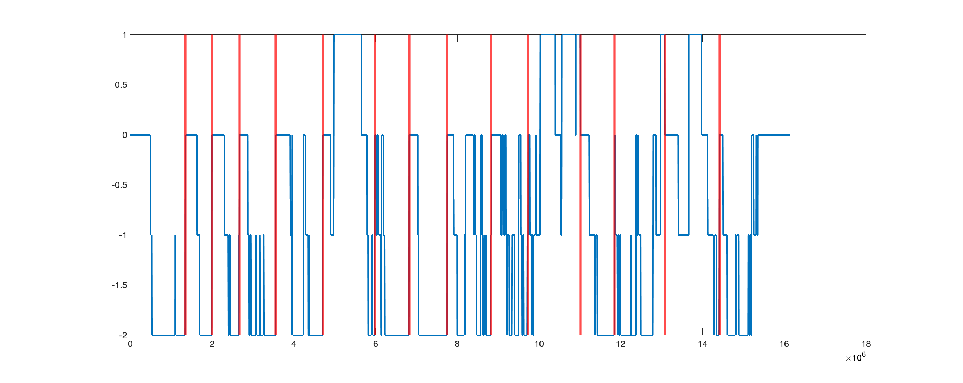

/data/tvanasse/nccam3/data/sub-2065/eeg/ses-3


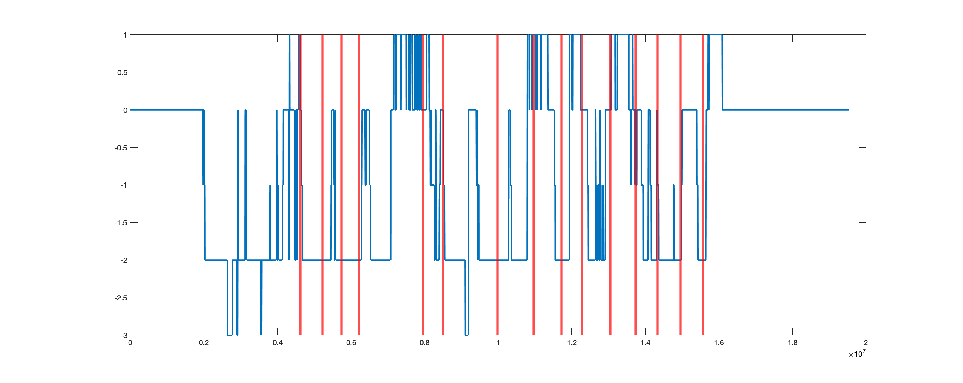

/data/tvanasse/nccam3/data/sub-2066/eeg/ses-3


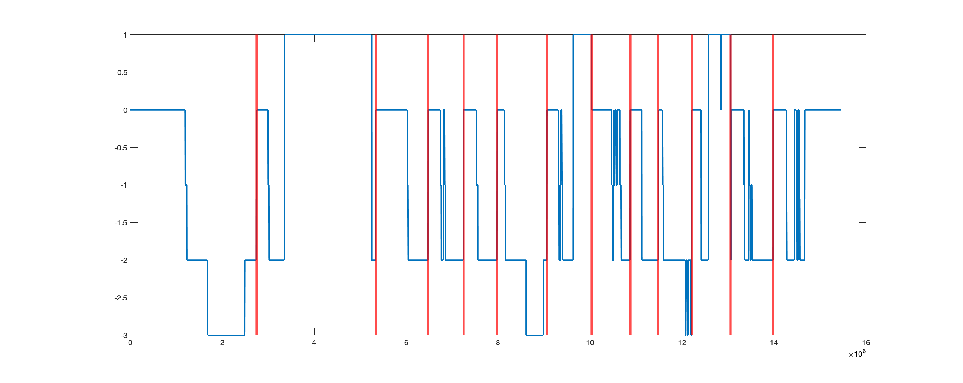

/data/tvanasse/nccam3/data/sub-2067/eeg/ses-1


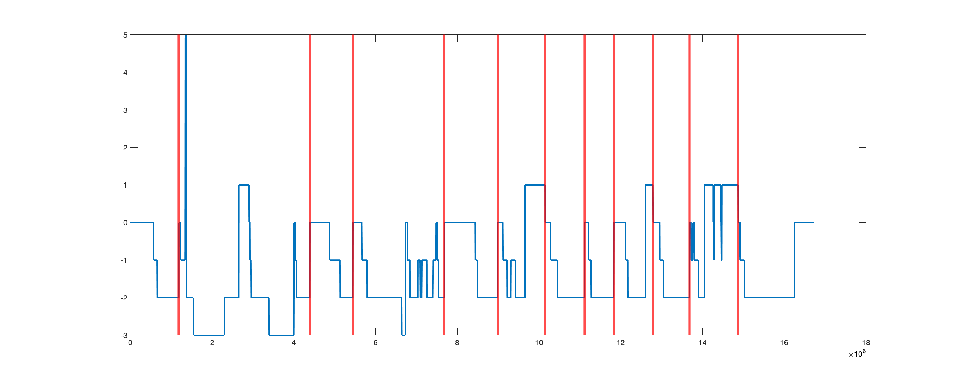

/data/tvanasse/nccam3/data/sub-2067/eeg/ses-2


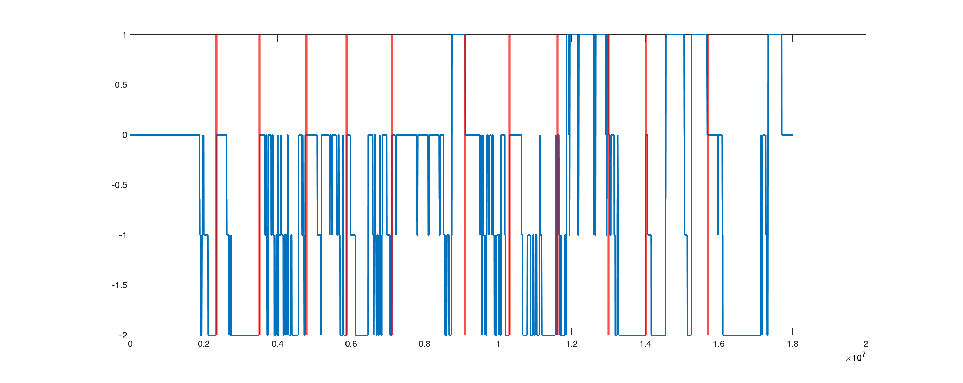

/data/tvanasse/nccam3/data/sub-2068/eeg/ses-1


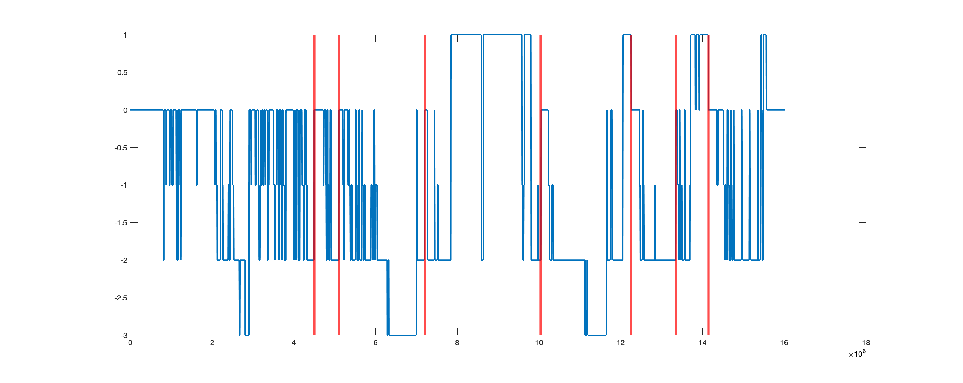

/data/tvanasse/nccam3/data/sub-2068/eeg/ses-2


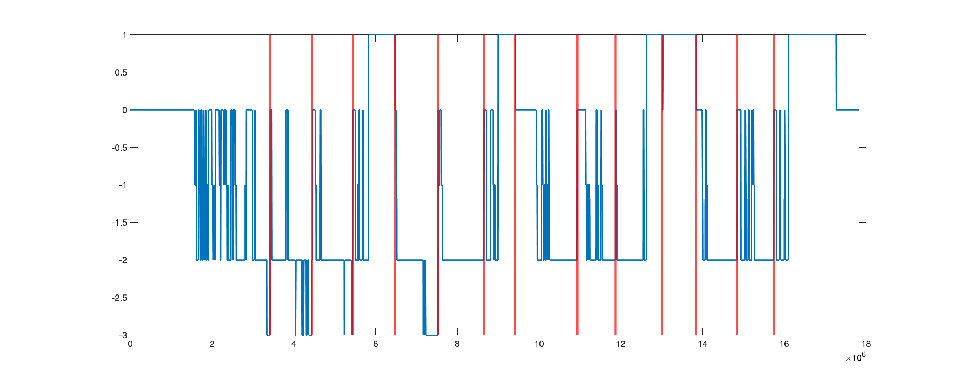

/data/tvanasse/nccam3/data/sub-2068/eeg/ses-3


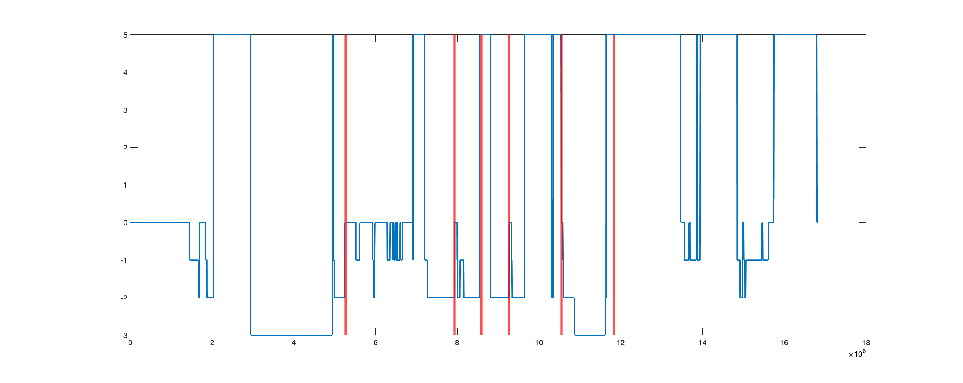

/data/tvanasse/nccam3/data/sub-2069/eeg/ses-1


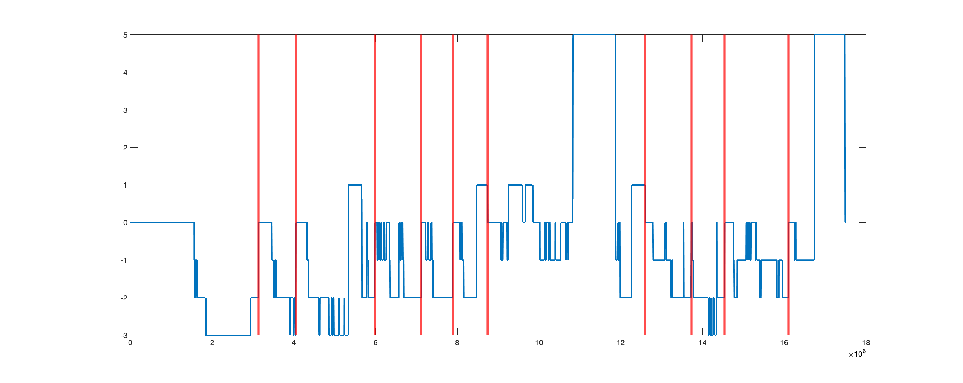

/data/tvanasse/nccam3/data/sub-2069/eeg/ses-2


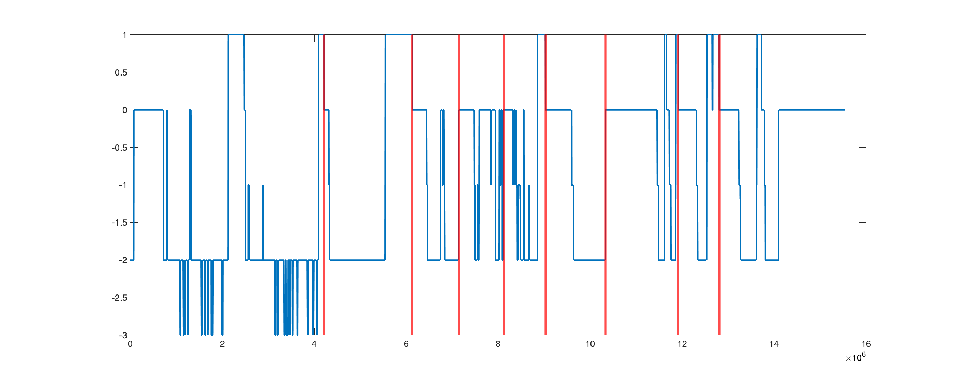

/data/tvanasse/nccam3/data/sub-2070/eeg/ses-1


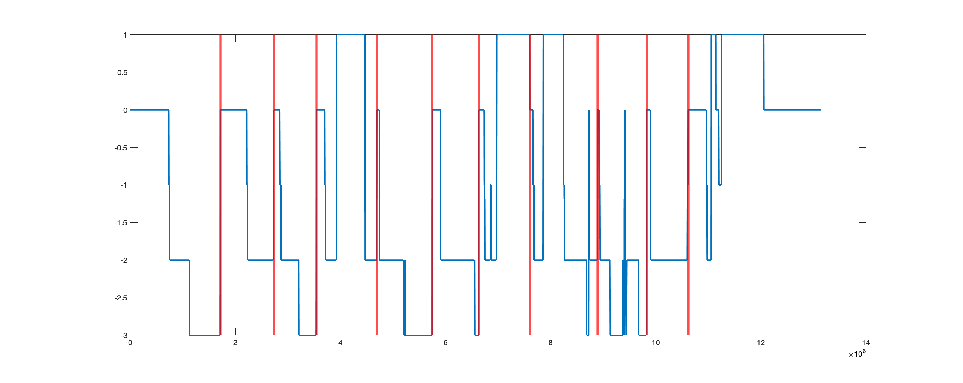

/data/tvanasse/nccam3/data/sub-2071/eeg/ses-1


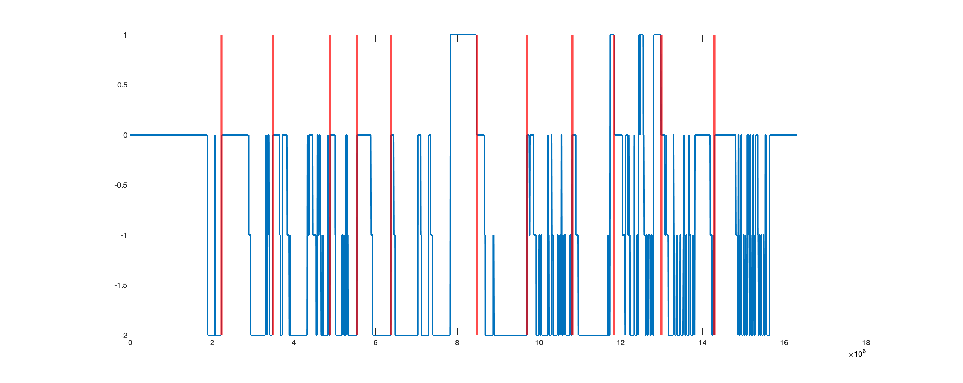

/data/tvanasse/nccam3/data/sub-2073/eeg/ses-1


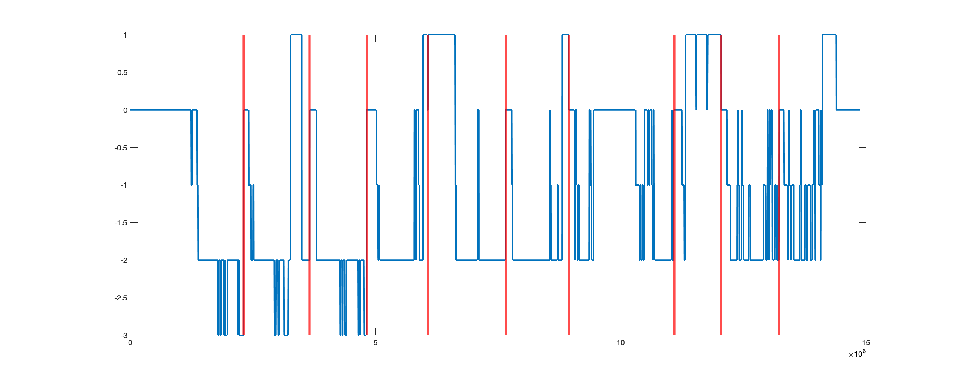

/data/tvanasse/nccam3/data/sub-2073/eeg/ses-2


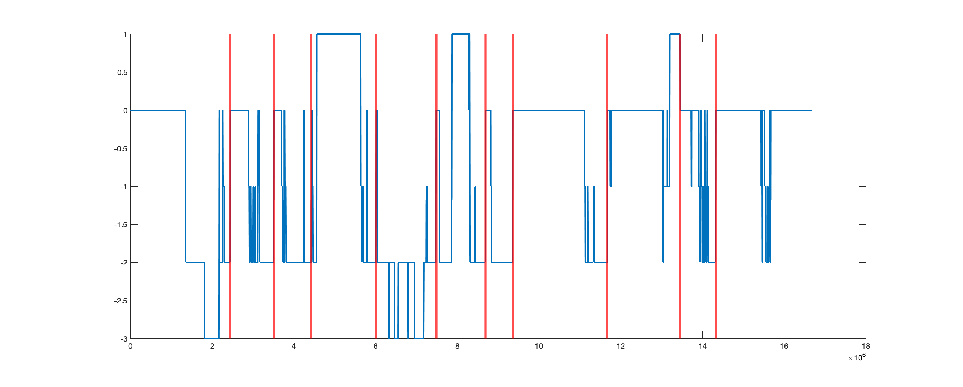

/data/tvanasse/nccam3/data/sub-2074/eeg/ses-1


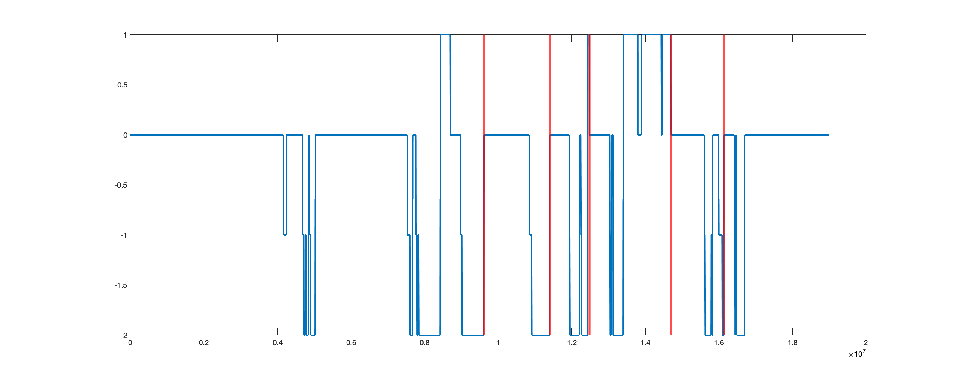

/data/tvanasse/nccam3/data/sub-2074/eeg/ses-2


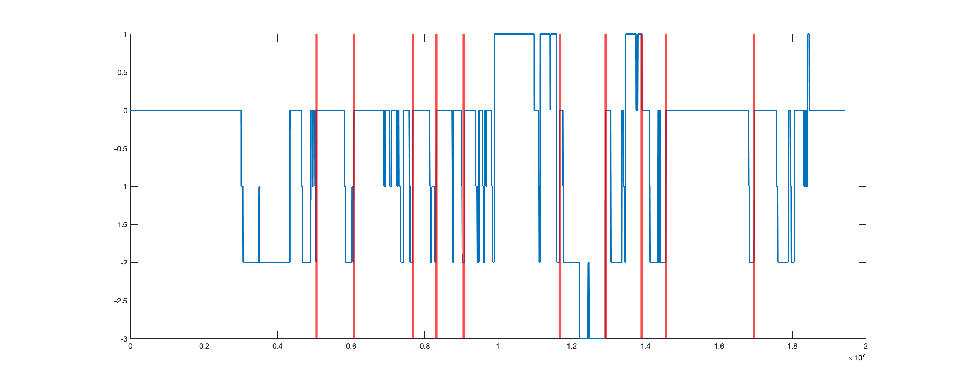

/data/tvanasse/nccam3/data/sub-2075/eeg/ses-1


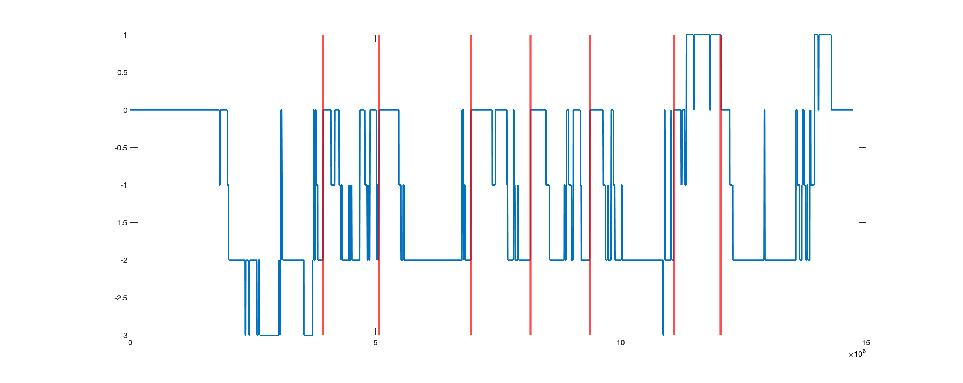

/data/tvanasse/nccam3/data/sub-2076/eeg/ses-1


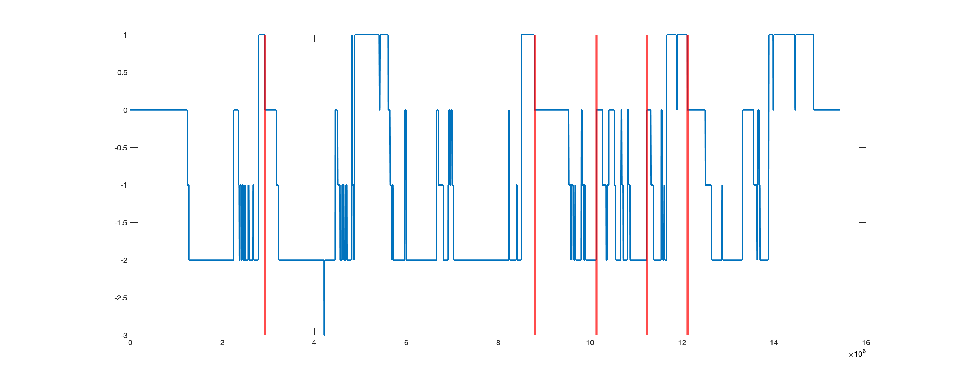

/data/tvanasse/nccam3/data/sub-2076/eeg/ses-3


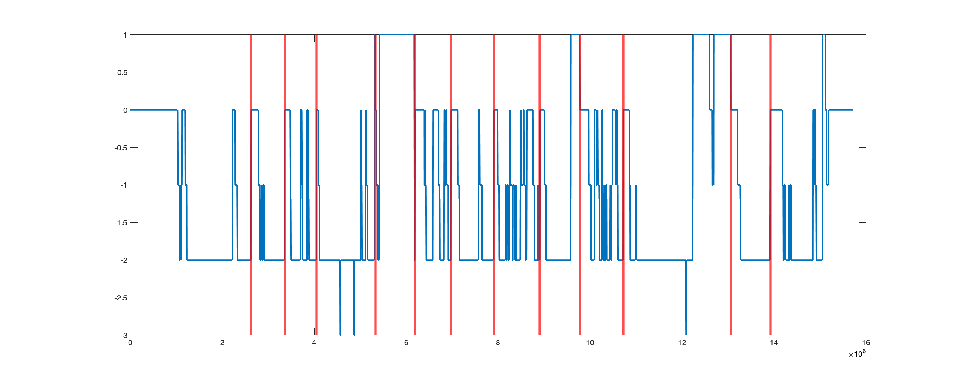

/data/tvanasse/nccam3/data/sub-2078/eeg/ses-1


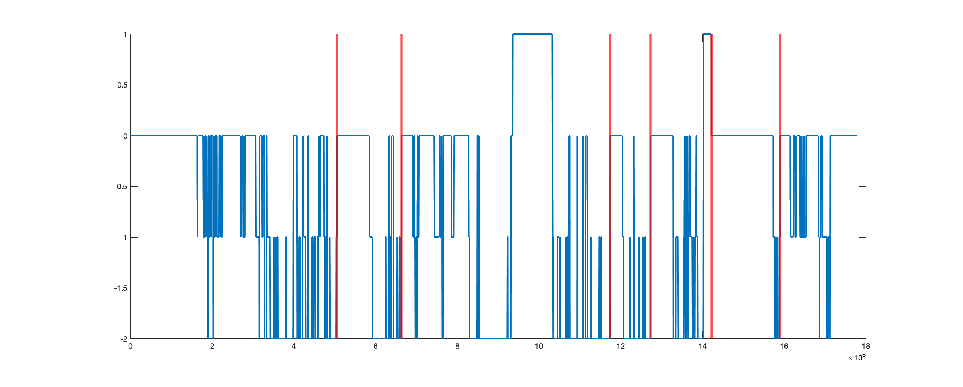

/data/tvanasse/nccam3/data/sub-2078/eeg/ses-3


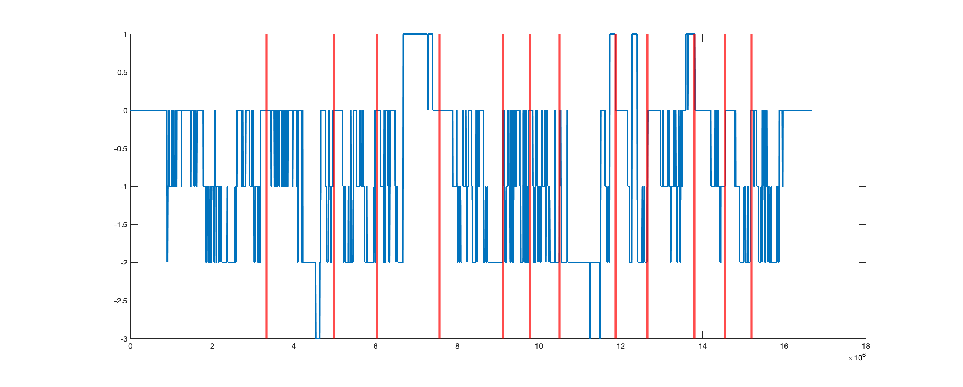

/data/tvanasse/nccam3/data/sub-2080/eeg/ses-1


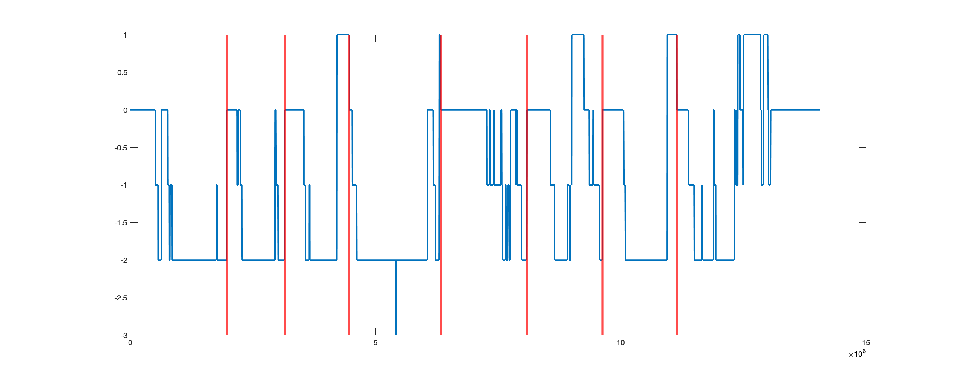

/data/tvanasse/nccam3/data/sub-2082/eeg/ses-1


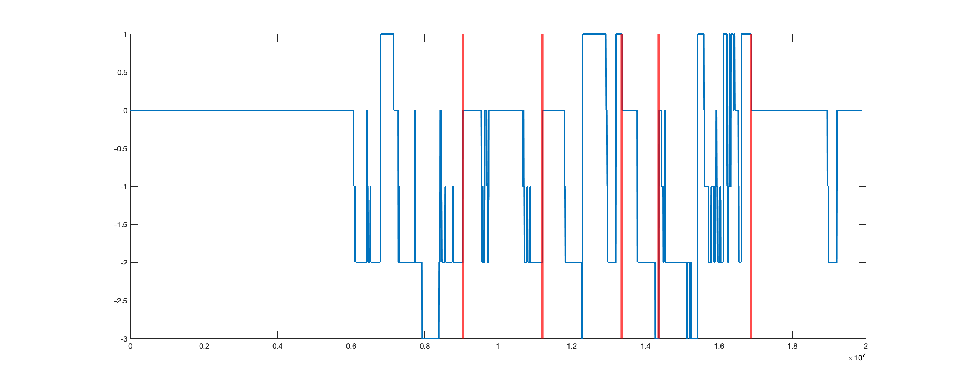

/data/tvanasse/nccam3/data/sub-2083/eeg/ses-1


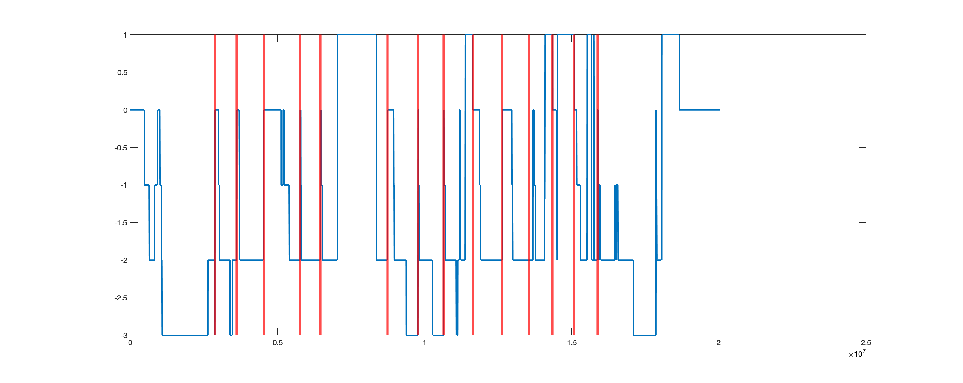

/data/tvanasse/nccam3/data/sub-2083/eeg/ses-2


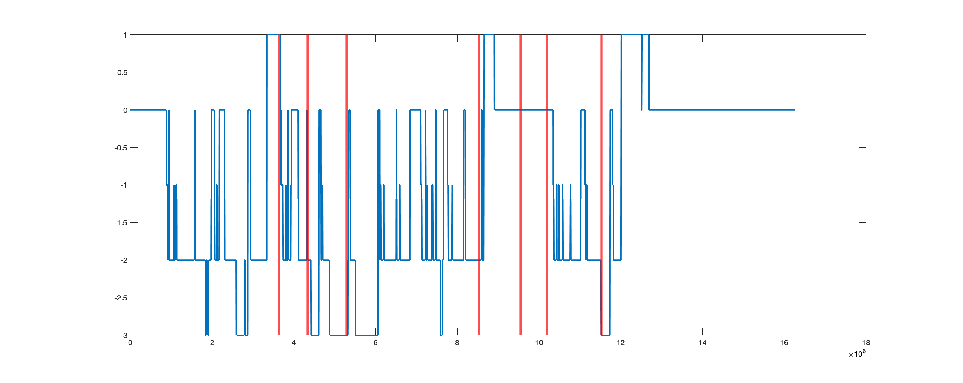

/data/tvanasse/nccam3/data/sub-2084/eeg/ses-1


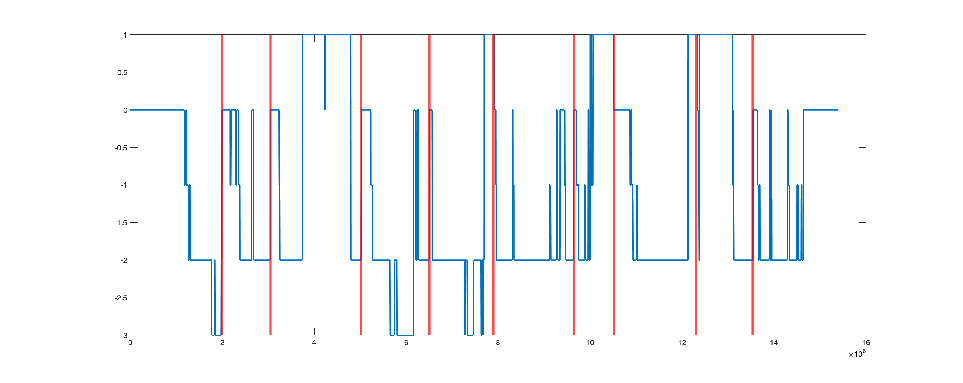

/data/tvanasse/nccam3/data/sub-2085/eeg/ses-1


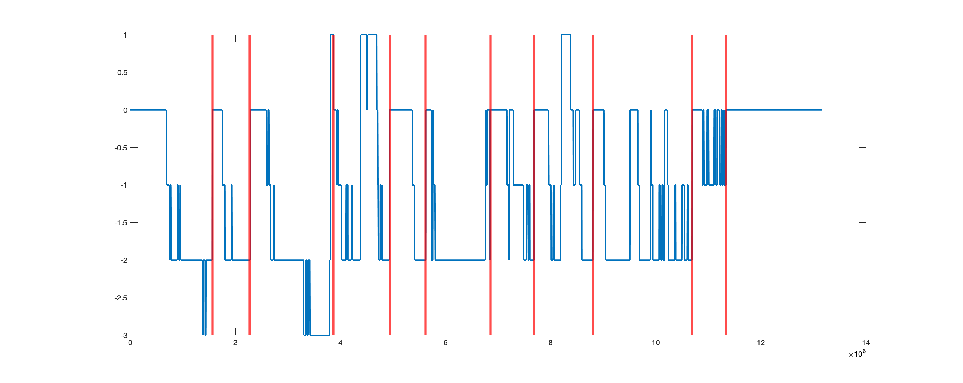

/data/tvanasse/nccam3/data/sub-2086/eeg/ses-3


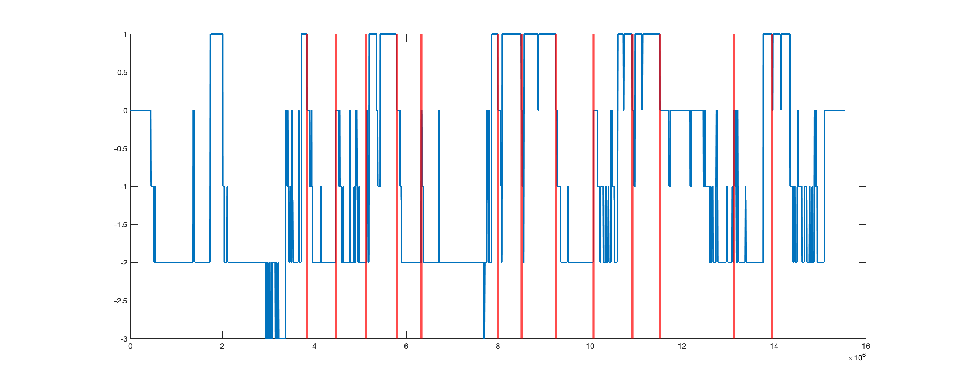

/data/tvanasse/nccam3/data/sub-2087/eeg/ses-1


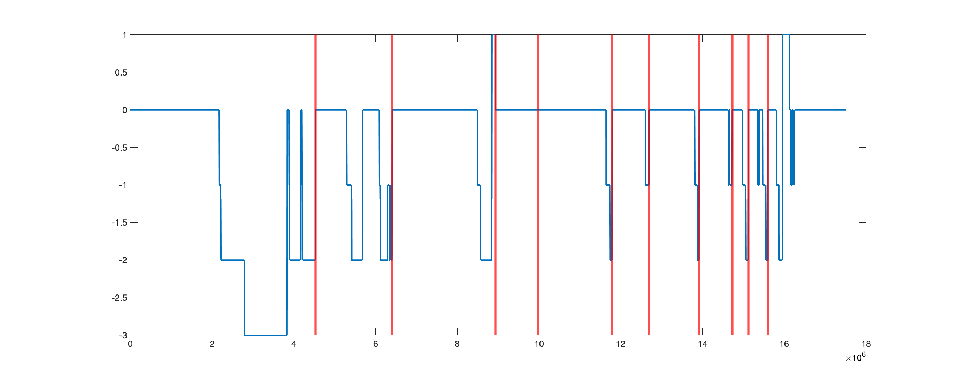

/data/tvanasse/nccam3/data/sub-2087/eeg/ses-3


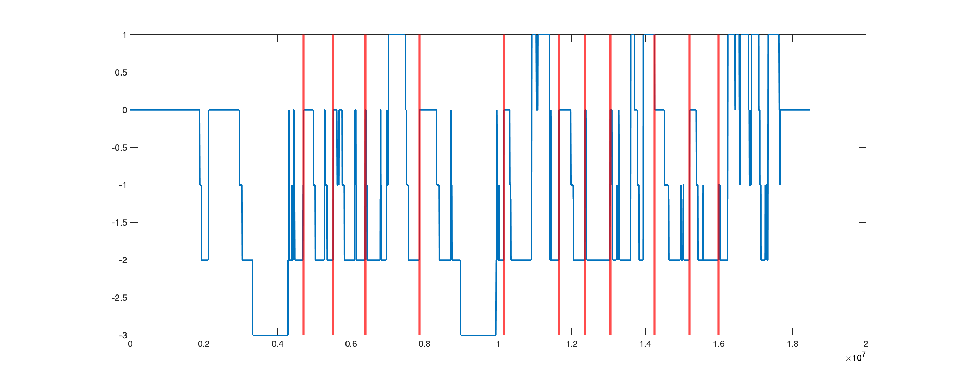

/data/tvanasse/nccam3/data/sub-2088/eeg/ses-3


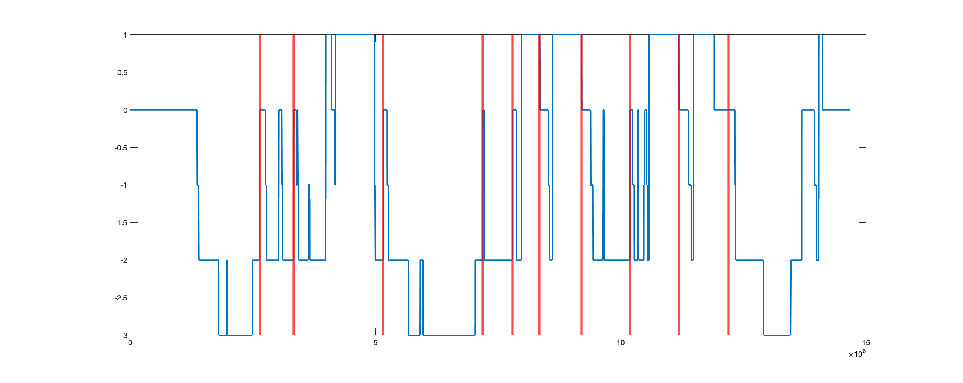

/data/tvanasse/nccam3/data/sub-2092/eeg/ses-1


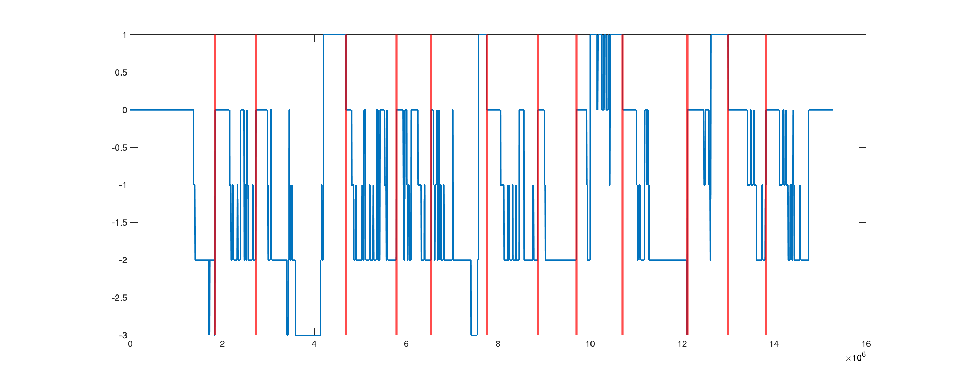

/data/tvanasse/nccam3/data/sub-2092/eeg/ses-3


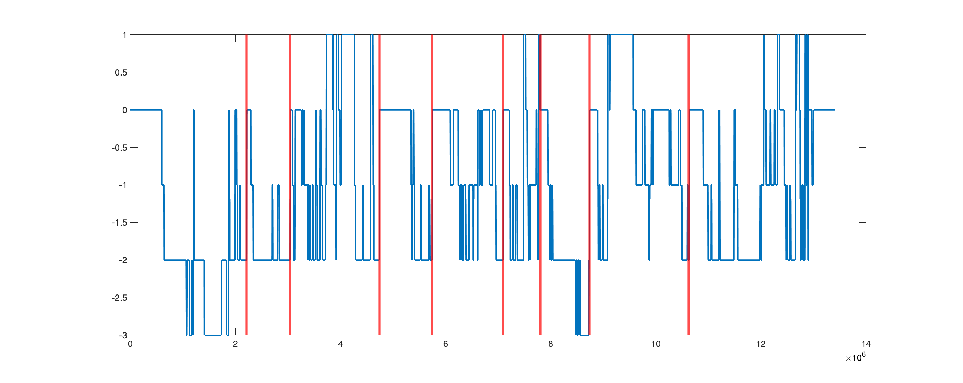

/data/tvanasse/nccam3/data/sub-2095/eeg/ses-1


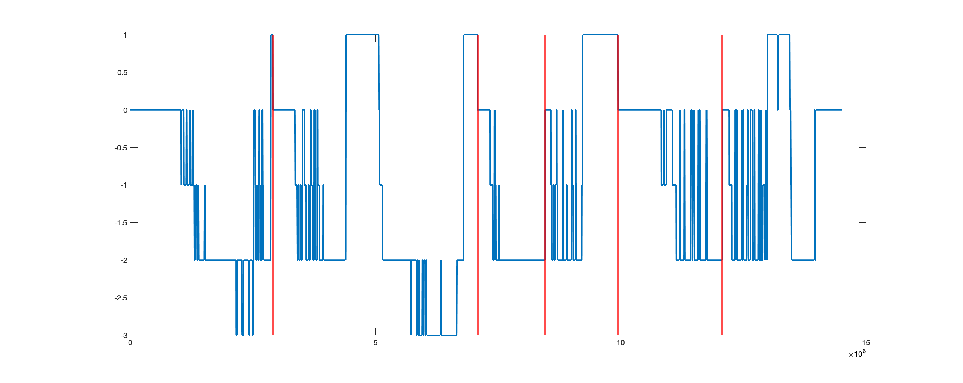

/data/tvanasse/nccam3/data/sub-2096/eeg/ses-1


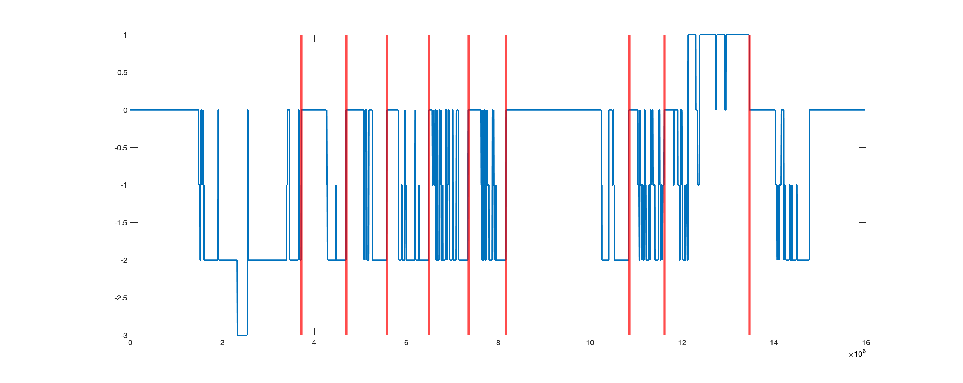

/data/tvanasse/nccam3/data/sub-2099/eeg/ses-3


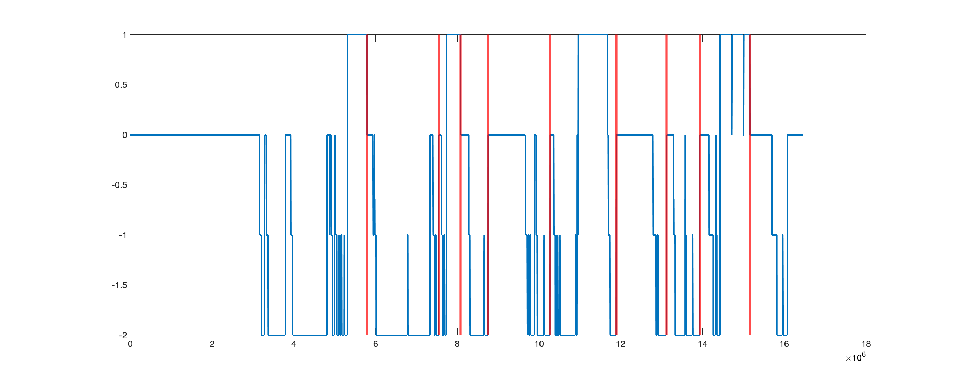

/data/tvanasse/nccam3/data/sub-2101/eeg/ses-3


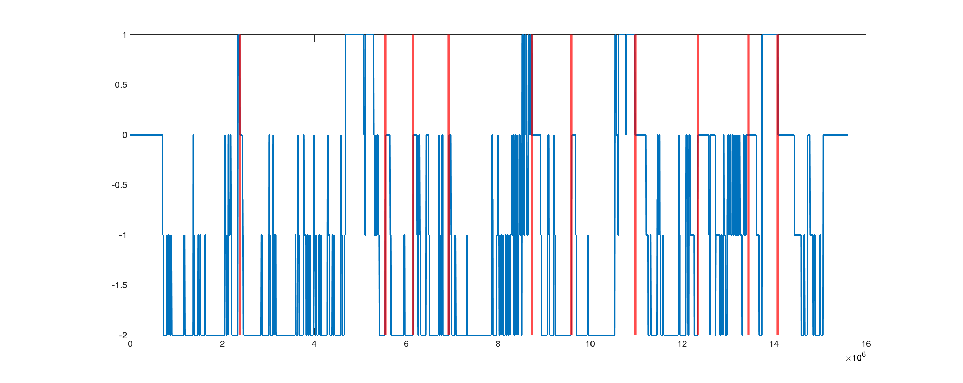

/data/tvanasse/nccam3/data/sub-2103/eeg/ses-1


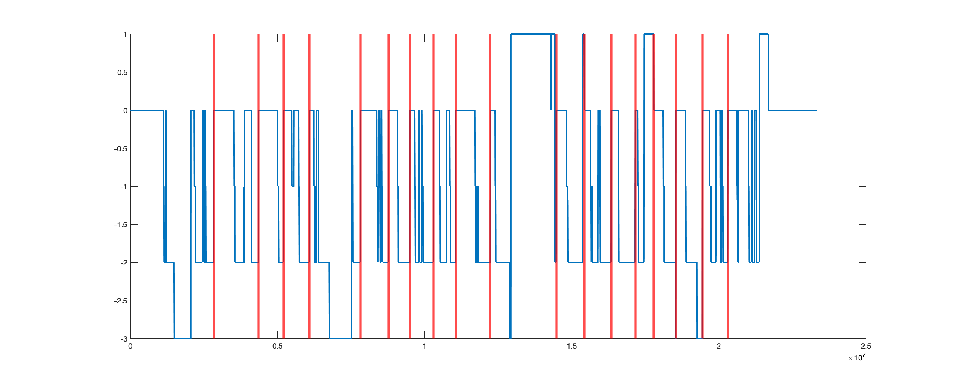

/data/tvanasse/nccam3/data/sub-2104/eeg/ses-1


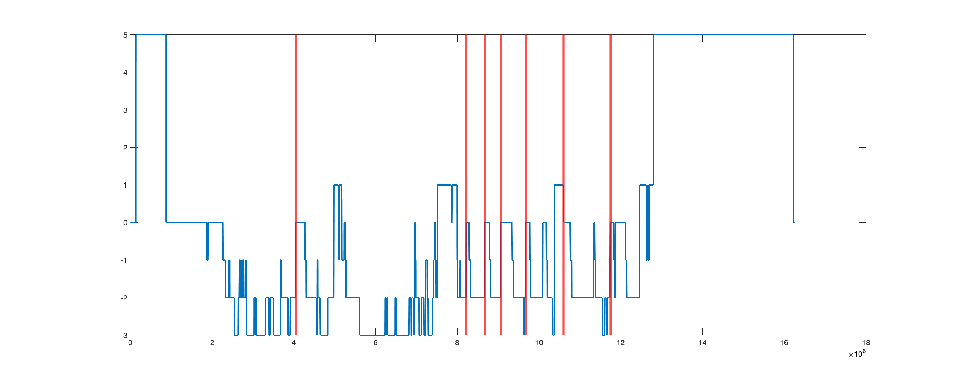

NO AWAKENINGS PLOT: /data/tvanasse/nccam3/data/sub-2105/eeg/ses-1
/data/tvanasse/nccam3/data/sub-2106/eeg/ses-1


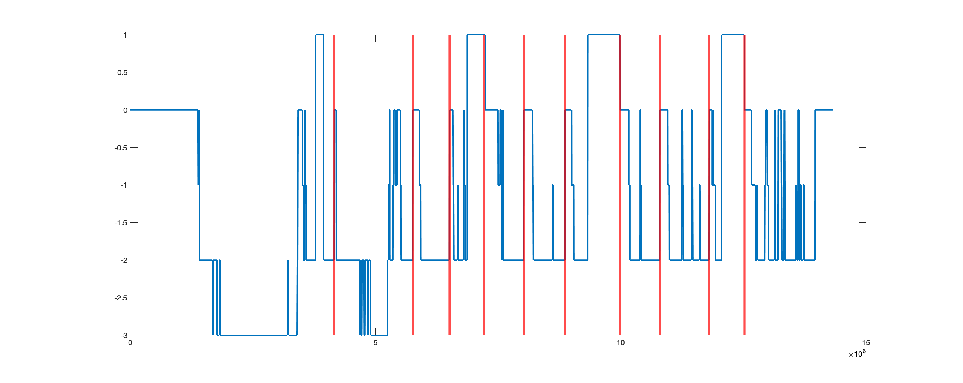

/data/tvanasse/nccam3/data/sub-2111/eeg/ses-2


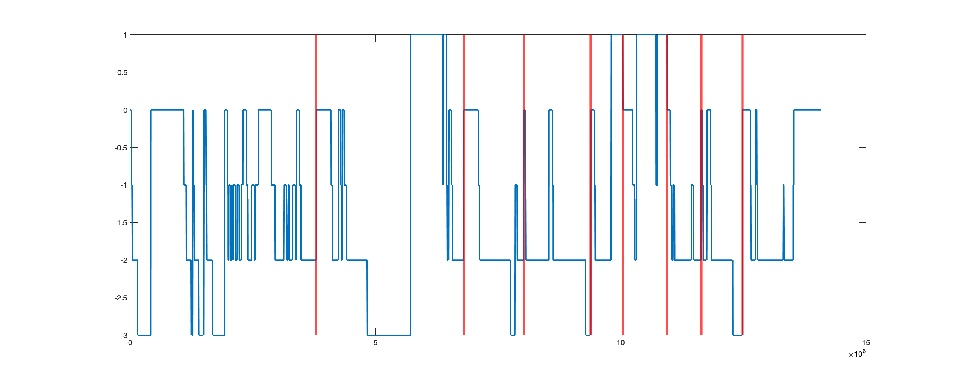

/data/tvanasse/nccam3/data/sub-2111/eeg/ses-3


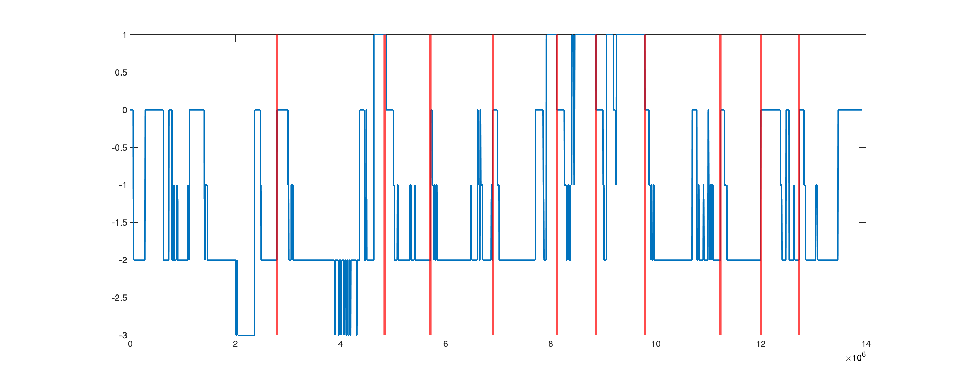

/data/tvanasse/nccam3/data/sub-2112/eeg/ses-1


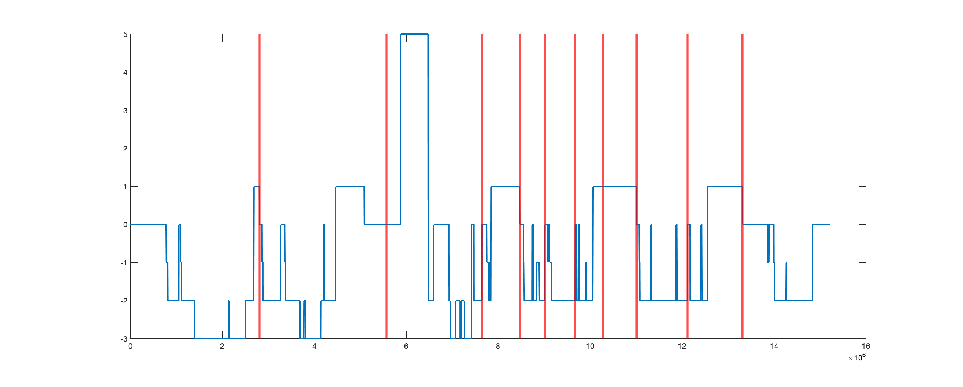

/data/tvanasse/nccam3/data/sub-2114/eeg/ses-1


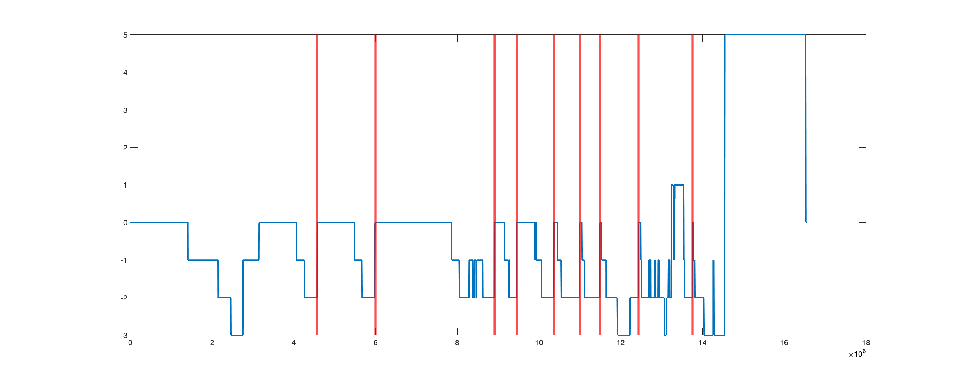

/data/tvanasse/nccam3/data/sub-2116/eeg/ses-1


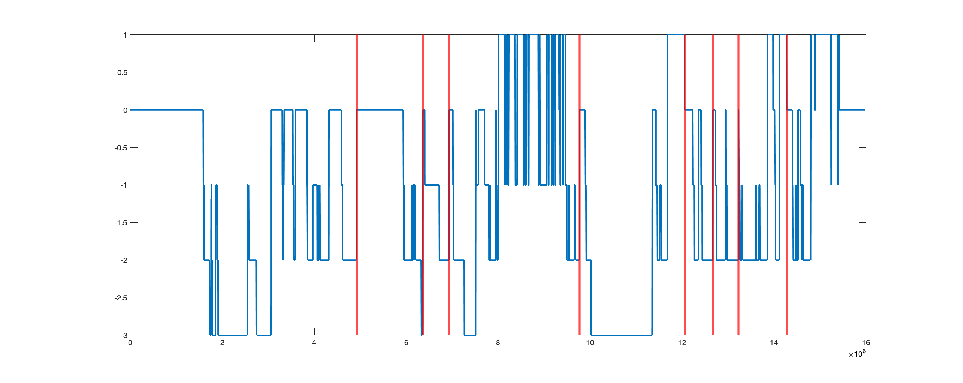

/data/tvanasse/nccam3/data/sub-2121/eeg/ses-1


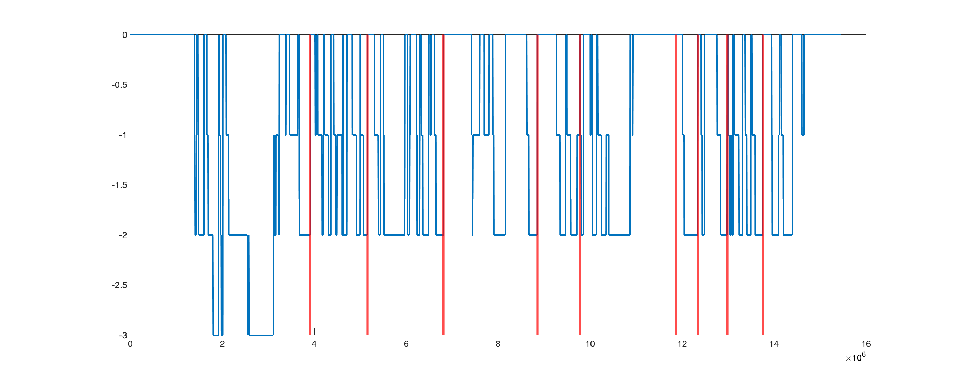

/data/tvanasse/nccam3/data/sub-2122/eeg/ses-1


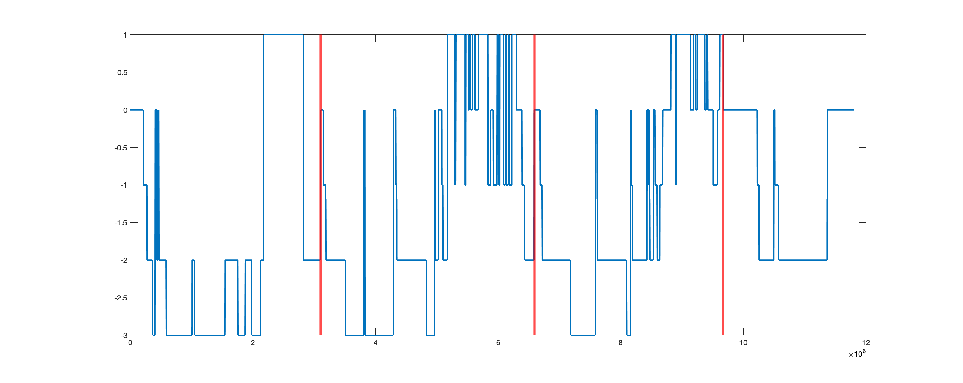

/data/tvanasse/nccam3/data/sub-2123/eeg/ses-1


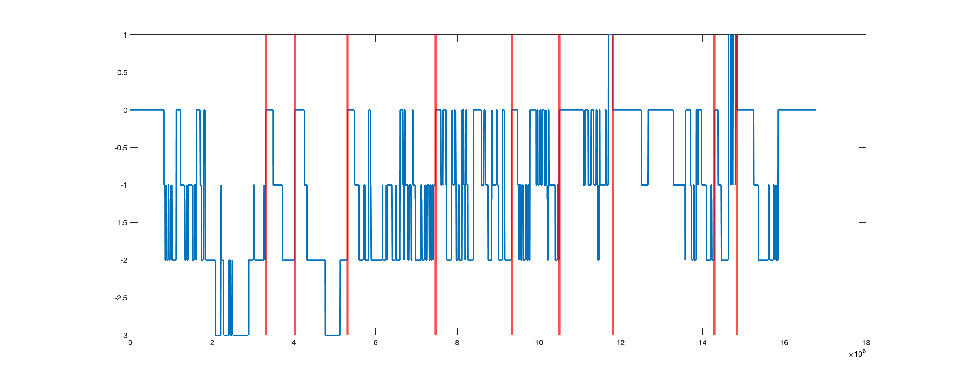

NO AWAKENINGS PLOT: /data/tvanasse/nccam3/data/sub-2123/eeg/ses-2
/data/tvanasse/nccam3/data/sub-2126/eeg/ses-1


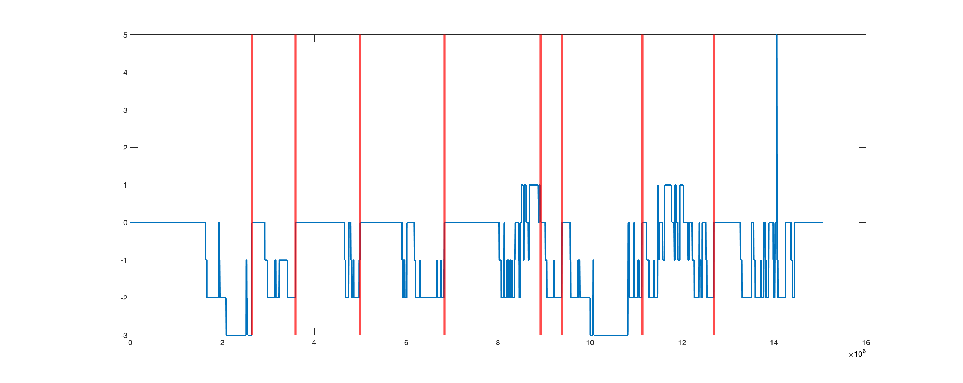

/data/tvanasse/nccam3/data/sub-2127/eeg/ses-2


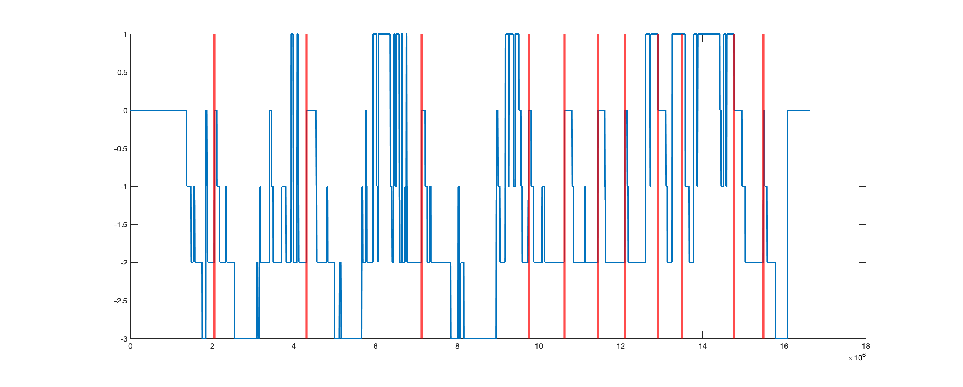

/data/tvanasse/nccam3/data/sub-2128/eeg/ses-1


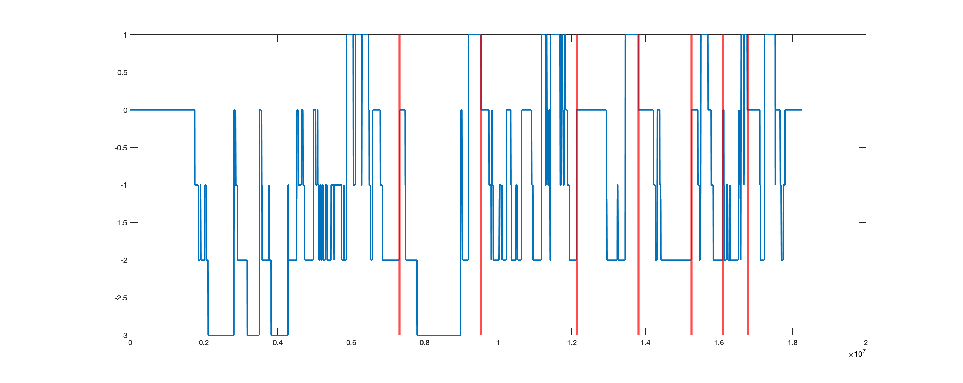

/data/tvanasse/nccam3/data/sub-2128/eeg/ses-2


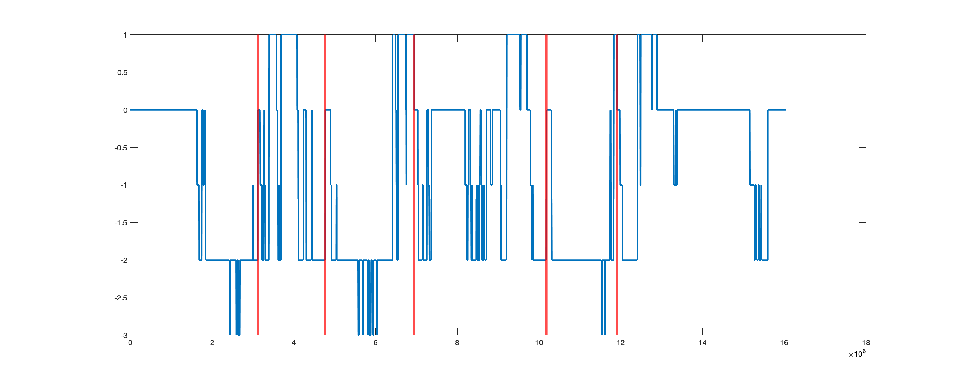

/data/tvanasse/nccam3/data/sub-2129/eeg/ses-1


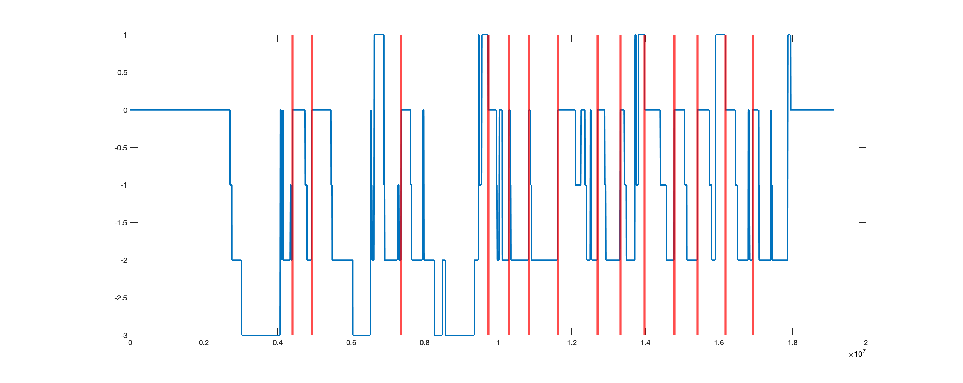

/data/tvanasse/nccam3/data/sub-2130/eeg/ses-1


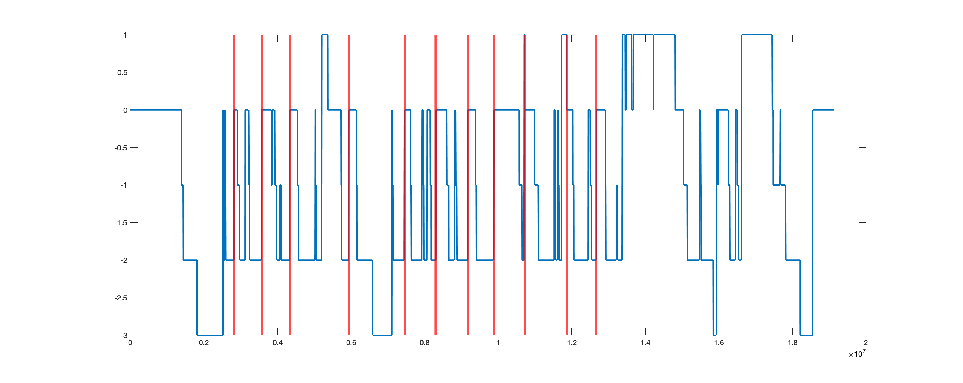

/data/tvanasse/nccam3/data/sub-2131/eeg/ses-1


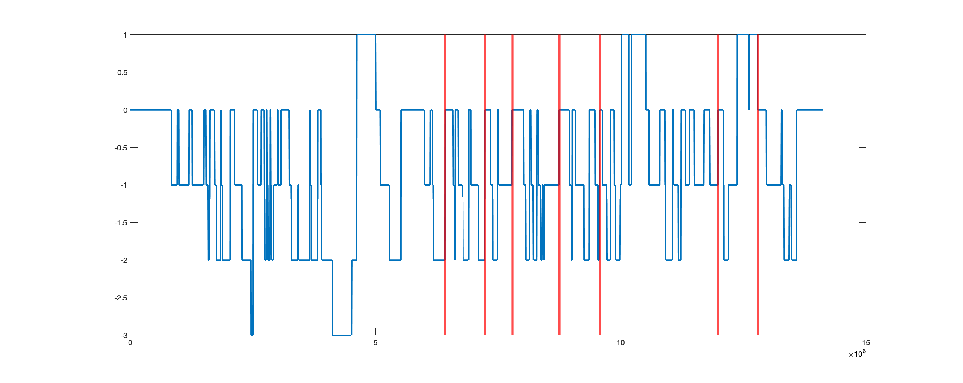

/data/tvanasse/nccam3/data/sub-2133/eeg/ses-2


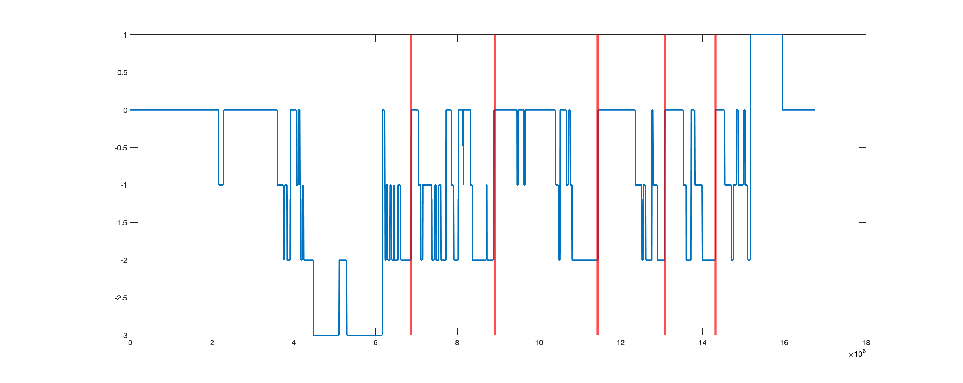

/data/tvanasse/nccam3/data/sub-2133/eeg/ses-3


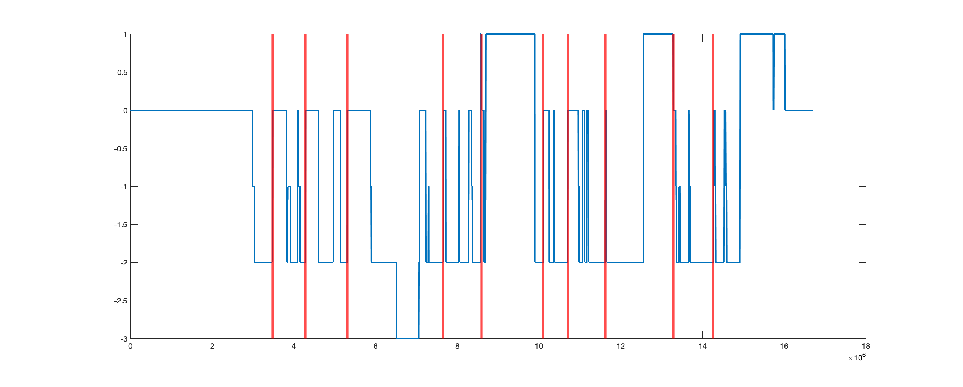

/data/tvanasse/nccam3/data/sub-2134/eeg/ses-1


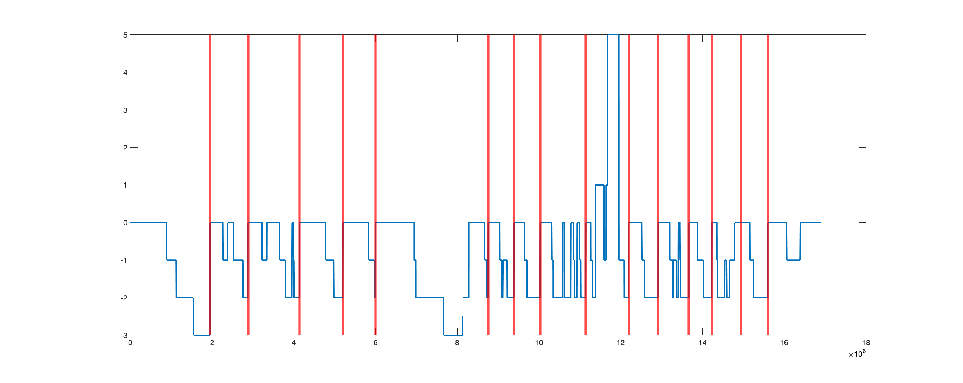

/data/tvanasse/nccam3/data/sub-2134/eeg/ses-2


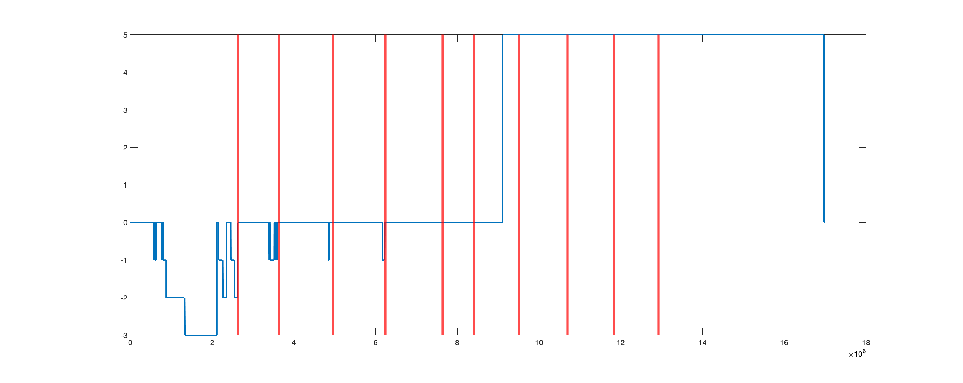

/data/tvanasse/nccam3/data/sub-2134/eeg/ses-3


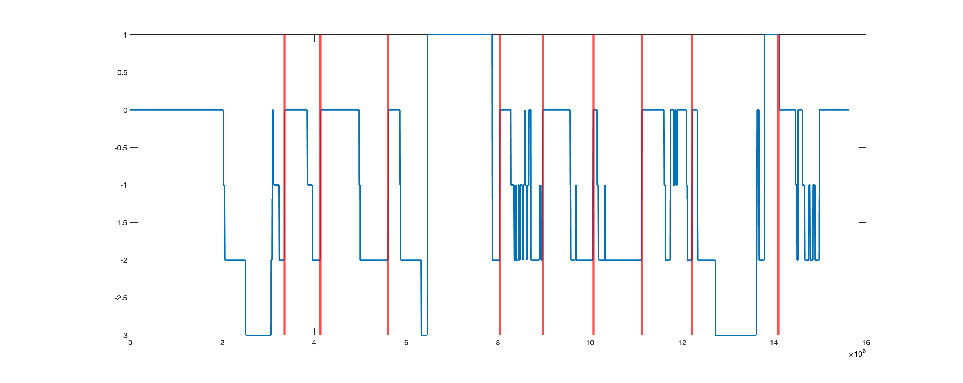

/data/tvanasse/nccam3/data/sub-2140/eeg/ses-1


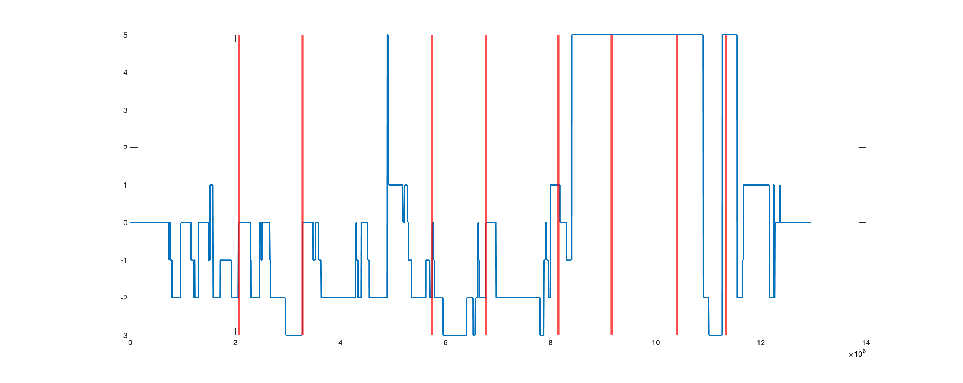

/data/tvanasse/nccam3/data/sub-2140/eeg/ses-3


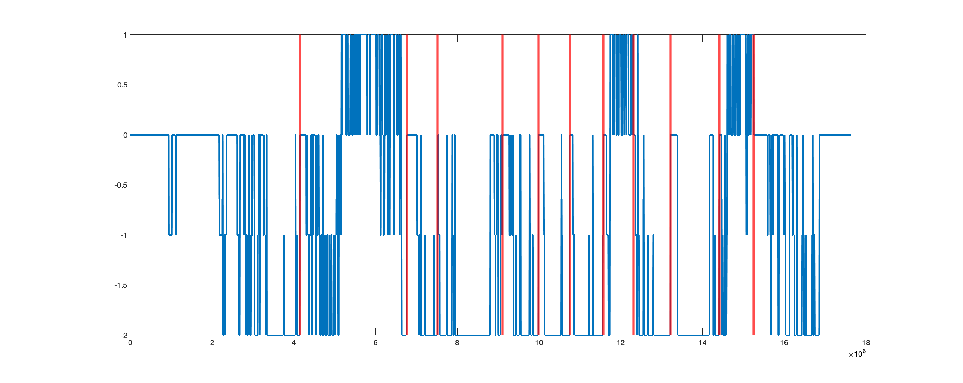

/data/tvanasse/nccam3/data/sub-2142/eeg/ses-1


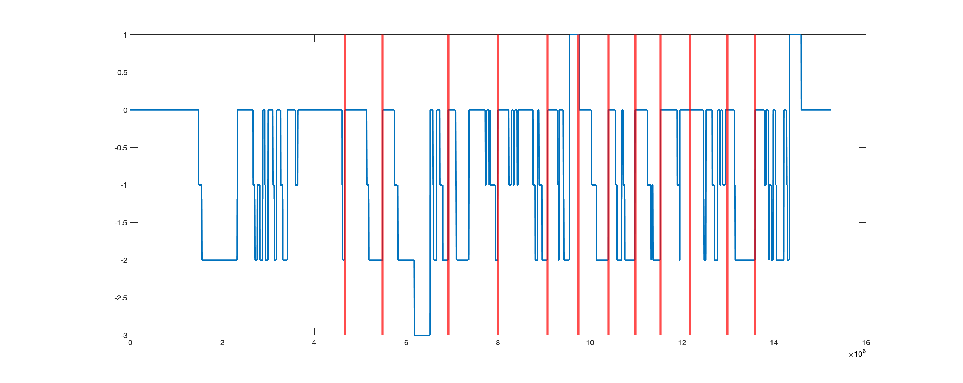

/data/tvanasse/nccam3/data/sub-2142/eeg/ses-3


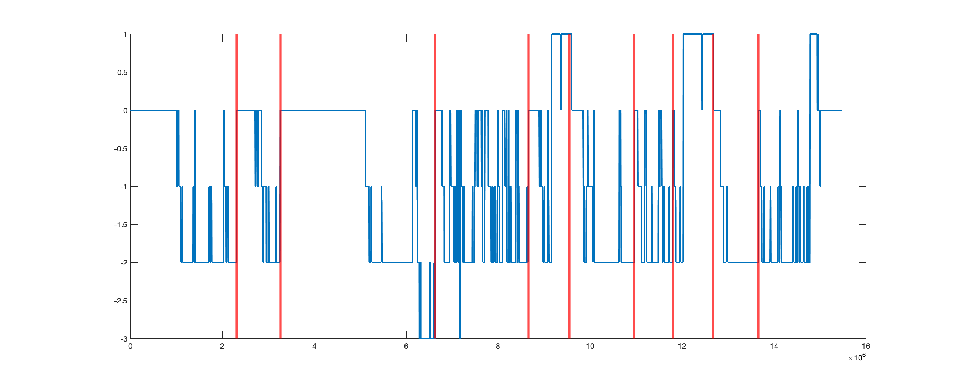

/data/tvanasse/nccam3/data/sub-2144/eeg/ses-1


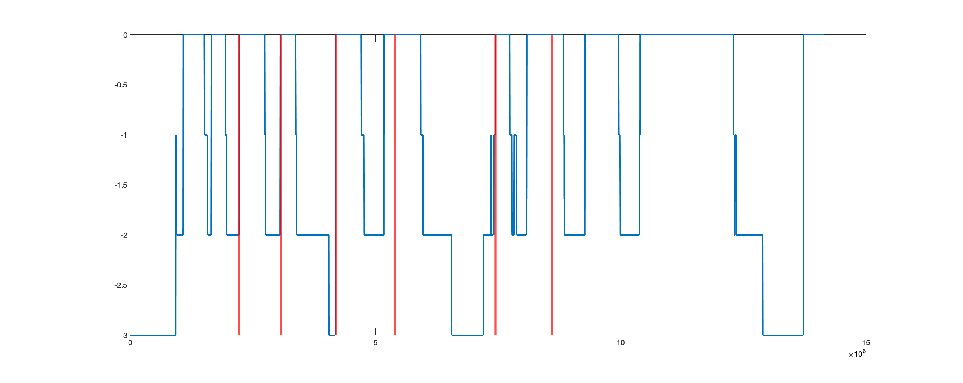

NO AWAKENINGS PLOT: /data/tvanasse/nccam3/data/sub-2144/eeg/ses-2
/data/tvanasse/nccam3/data/sub-2144/eeg/ses-3


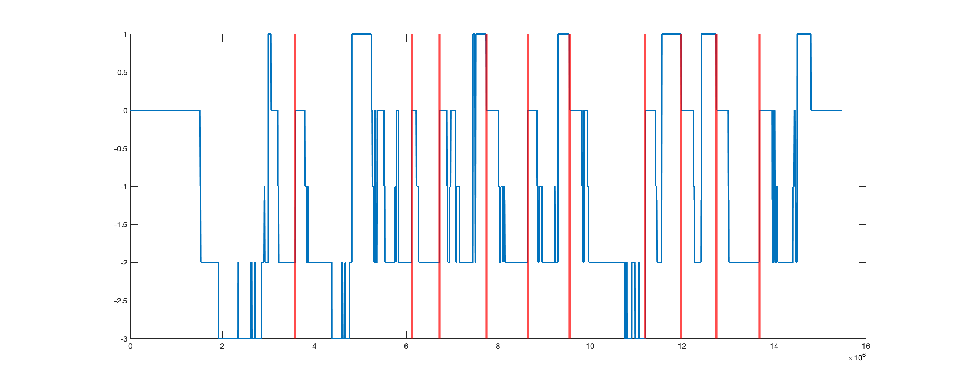

Sessions with awakenings file: 123


In [25]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

images_with_awakenings_file = 0
for i in range(0,len(sesdirs)):
    if os.path.exists(sesdirs[i] + '/all_awakenings.png'):
        print(sesdirs[i])
        fig, ax = plt.subplots()
        fig.set_size_inches(17,17)
        fig.patch.set_visible(False)
        ax.axis('off')
        img = mpimg.imread(sesdirs[i] + '/all_awakenings.png')
        imgplot = plt.imshow(img)
        plt.show()
        images_with_awakenings_file = images_with_awakenings_file + 1
    else:
        print("NO AWAKENINGS PLOT: " + sesdirs[i])
print("Sessions with awakenings file: " + str(images_with_awakenings_file))

### What awakenings aren't found? (ie., awakening table is likely incorrect)

In [26]:
for i in range(0,len(nrem_awakenings)):
    if nrem_awakenings[i] not in nrem_dataframe["PATH"].values:
        print(nrem_awakenings[i])

/data/tvanasse/nccam3/data/sub-2042/eeg/ses-1/awakening-9-cleaned2_nrem.set
/data/tvanasse/nccam3/data/sub-2042/eeg/ses-3/awakening-1-cleaned2_nrem.set
/data/tvanasse/nccam3/data/sub-2042/eeg/ses-3/awakening-6-cleaned2_nrem.set
/data/tvanasse/nccam3/data/sub-2042/eeg/ses-3/awakening-7-cleaned2_nrem.set
/data/tvanasse/nccam3/data/sub-2042/eeg/ses-3/awakening-2-cleaned2_nrem.set
/data/tvanasse/nccam3/data/sub-2042/eeg/ses-3/awakening-3-cleaned2_nrem.set
/data/tvanasse/nccam3/data/sub-2042/eeg/ses-3/awakening-9-cleaned2_nrem.set


2042_T3 is not in FINALS folder any longer

### Remove HOLD-OUT DATA

In [56]:
nrem_dataframe = pd.read_csv('nrem_dataframe.csv')

# remove held out data
nrem_dataframe = nrem_dataframe[nrem_dataframe["HOLD_OUT"] == False].copy()
nrem_dataframe = nrem_dataframe.reset_index(drop=True)
nrem_dataframe

,DIFF_FROM_EVENT_SECONDS,DIN_EVENTS_WITHIN_TWO_MINUTES,Date,Date_Time,ENTRY_MATCHED_AWAKENING_NO,FILE_NOT_FOUND,HOLD_OUT,ID,Int,MFF_FILE_HAS_NO_EVENTS_TO_IMPORT,...,Q7,Q8,Q9,REM,SA,SES_PATH,Stage,Time,Visit,WAKE
0,75.592,2,NaN,11/19/0014 03:42,5.0,NaN,False,2000,RA,NaN,...,1.0,3.0,0.0,0.0,5,/data/tvanasse/nccam3/data/sub-2000/eeg/ses-1,2.0,3:42 AM,1,1.0
1,224.648,1,NaN,11/19/0014 01:00,1.0,NaN,False,2000,RA,NaN,...,1.0,3.0,0.0,0.0,1,/data/tvanasse/nccam3/data/sub-2000/eeg/ses-1,2.0,1:00 AM,1,1.0
2,38.338,1,NaN,11/19/0014 06:07,9.0,NaN,False,2000,RA,NaN,...,2.0,1.0,1.0,0.0,9,/data/tvanasse/nccam3/data/sub-2000/eeg/ses-1,NaN,6:07 AM,1,1.0
3,38.636,1,NaN,11/19/0014 05:08,7.0,NaN,False,2000,RA,NaN,...,1.0,2.0,0.0,0.0,7,/data/tvanasse/nccam3/data/sub-2000/eeg/ses-1,2.0,5:08 AM,1,1.0
4,40.349,1,NaN,11/19/0014 02:41,3.0,NaN,False,2000,RA,NaN,...,NaN,NaN,NaN,0.0,3,/data/tvanasse/nccam3/data/sub-2000/eeg/ses-1,2.0,2:41 AM,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,24.541,1,NaN,11/09/0017 23:45,1.0,NaN,False,2144,AMV,NaN,...,0.0,3.0,3.0,0.0,1,/data/tvanasse/nccam3/data/sub-2144/eeg/ses-3,2.0,11:45 PM,3,1.0
679,18.918,1,NaN,11/10/0017 03:59,7.0,NaN,False,2144,AMV,NaN,...,0.0,2.0,0.0,0.0,7,/data/tvanasse/nccam3/data/sub-2144/eeg/ses-3,2.0,3:59 AM,3,1.0
680,71.029,1,NaN,11/10/0017 05:21,10.0,NaN,False,2144,AMV,NaN,...,5.0,0.0,0.0,0.0,10,/data/tvanasse/nccam3/data/sub-2144/eeg/ses-3,2.0,5:21 AM,3,1.0
681,9.895,1,NaN,11/10/0017 01:10,2.0,NaN,False,2144,AMV,NaN,...,NaN,NaN,NaN,0.0,2,/data/tvanasse/nccam3/data/sub-2144/eeg/ses-3,2.0,1:10 AM,3,1.0


In [28]:
for x in range(0,len(nrem_dataframe)):
    if nrem_dataframe.loc[x,"ENTRY_MATCHED_AWAKENING_NO"] != nrem_dataframe.loc[x,"SA"]:
        print(str(nrem_dataframe.loc[x,"ID"]) + " " + str(nrem_dataframe.loc[x,"Visit"]))

2003 3
2003 3
2003 3
2003 3
2003 3
2037 1
2037 1
2037 1
2048 2
2048 2
2048 2
2055 2
2055 2
2055 2
2055 2
2055 2
2055 2
2055 2
2071 1
2071 1
2071 1
2127 2
2127 2
2127 2
2127 2
2127 2
2127 2
2127 2
2131 1
2131 1
2131 1


2003_T3 ; 2037_T1 ; 2055_T2 ; 2071_T1 ; 2091_T3 ; 2127_T2 ; 2131_T1  OKAY

In [29]:
print(nrem_dataframe[(nrem_dataframe["ID"] == 2027) & (nrem_dataframe["Visit"] == 1)])

Empty DataFrame
Columns: [DIFF_FROM_EVENT_SECONDS, DIN_EVENTS_WITHIN_TWO_MINUTES, Date, Date_Time, ENTRY_MATCHED_AWAKENING_NO, FILE_NOT_FOUND, HOLD_OUT, ID, Int, MFF_FILE_HAS_NO_EVENTS_TO_IMPORT, N1, N2, N3, Notes, PATH, Q10, Q11, Q12, Q13, Q14, Q14b, Q15, Q16, Q17, Q18, Q19, Q1Experience, Q1ExperienceNum, Q1Report, Q20, Q20b, Q2Awake, Q2AwakeNum, Q3, Q4, Q5, Q6, Q7, Q8, Q9, REM, SA, SES_PATH, Stage, Time, Visit, WAKE]
Index: []

[0 rows x 47 columns]


In [62]:
import seaborn as sns
print(sns.__version__)

ax = sns.histplot(nrem_dataframe["Q1ExperienceNum"])

plt.show()

ax = sns.barplot(nrem_dataframe[nrem_dataframe["HOLD_OUT"] == True]["Q1ExperienceNum"])

plt.show()


0.9.0


AttributeError: module 'seaborn' has no attribute 'histplot'

In [33]:
import scipy.io as sio

# mat_contents = sio.loadmat('spectral_slope_output.mat')

# import tables
# tables.file._open_files.close_all()

# should be 976 nights * 2 time ranges [1,2 min. before awakening] * 3 freq ranges [1-20;20-40;1-40 Hz] = 5856
import h5py

data_folder = '/data/tvanasse/nccam3/'

f = h5py.File(data_folder + 'spectral_slope_output.mat','r')
list(f.keys())
struArray = f['output']
# f[struArray['freqrange'][5855,0]].value 

In [78]:
nrem_dataframe["SPECEXP_1-20_ALL"] = np.array(0).astype('object') #create object for 
nrem_dataframe["OBS_1-20"] = np.array(0).astype('object') #create object for 
nrem_dataframe["OBS_1-20_ALL"] = np.array(0).astype('object') #create object for 
nrem_dataframe["FREQ_1-20"] = np.array(0).astype('object') #create object for

nrem_dataframe["SPECEXP_20-40_ALL"] = np.array(0).astype('object') #create object for 
nrem_dataframe["OBS_20-40"] = np.array(0).astype('object') #create object for 
nrem_dataframe["OBS_20-40_ALL"] = np.array(0).astype('object') #create object for 
nrem_dataframe["FREQ_20-40"] = np.array(0).astype('object') #create object for 

nrem_dataframe["SPECEXP_1-40_ALL"] = np.array(0).astype('object') #create object for 
nrem_dataframe["OBS_1-40"] = np.array(0).astype('object') #create object for 
nrem_dataframe["OBS_1-40_ALL"] = np.array(0).astype('object') #create object for 
nrem_dataframe["FREQ_1-40"] = np.array(0).astype('object') #create object for 

# get spectral exponents & set timerange (1 or 2 minutes before awakening)
timerange = 1 # minutes before awakening
for i in range(0,5856):
    print(i)
    
    if not nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == f[struArray['path'][i, 0]].value.tobytes()[::2].decode().split("sub-",1)[1] ].empty:
    
        if (str(np.squeeze(f[struArray['freqrange'][i,0]].value)) == '[ 1. 20.]') & (int(f[struArray['timerange'][i,0]].value) == timerange):
            nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == f[struArray['path'][i, 0]].value.tobytes()[::2].decode().split("sub-",1)[1] ].index.values,"SPECEXP_1-20"] = np.squeeze(f[struArray['meanspectralexp'][i,0]].value)
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == f[struArray['path'][i, 0]].value.tobytes()[::2].decode().split("sub-",1)[1] ].index.values),"SPECEXP_1-20_ALL"] = np.squeeze(f[struArray['spectralexp_all'][i,0]].value).tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == f[struArray['path'][i, 0]].value.tobytes()[::2].decode().split("sub-",1)[1] ].index.values),"OBS_1-20"] = np.squeeze(f[struArray['obs_freq_avg'][i,0]].value).tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == f[struArray['path'][i, 0]].value.tobytes()[::2].decode().split("sub-",1)[1] ].index.values),"OBS_1-20_ALL"] = np.squeeze(f[struArray['obs_freq_all'][i,0]].value).tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == f[struArray['path'][i, 0]].value.tobytes()[::2].decode().split("sub-",1)[1] ].index.values),"FREQ_1-20"] = np.squeeze(f[struArray['freqbins'][i,0]].value).tolist()

        elif (str(np.squeeze(f[struArray['freqrange'][i,0]].value)) == '[20. 40.]') & (int(f[struArray['timerange'][i,0]].value) == timerange):
            nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == f[struArray['path'][i, 0]].value.tobytes()[::2].decode().split("sub-",1)[1] ].index.values,"SPECEXP_20-40"] = np.squeeze(f[struArray['meanspectralexp'][i,0]].value)
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == f[struArray['path'][i, 0]].value.tobytes()[::2].decode().split("sub-",1)[1] ].index.values),"SPECEXP_20-40_ALL"] = np.squeeze(f[struArray['spectralexp_all'][i,0]].value).tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == f[struArray['path'][i, 0]].value.tobytes()[::2].decode().split("sub-",1)[1] ].index.values),"OBS_20-40"] = np.squeeze(f[struArray['obs_freq_avg'][i,0]].value).tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == f[struArray['path'][i, 0]].value.tobytes()[::2].decode().split("sub-",1)[1] ].index.values),"OBS_20-40_ALL"]= np.squeeze(f[struArray['obs_freq_all'][i,0]].value).tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == f[struArray['path'][i, 0]].value.tobytes()[::2].decode().split("sub-",1)[1] ].index.values),"FREQ_20-40"]= np.squeeze(f[struArray['freqbins'][i,0]].value).tolist()

        elif (str(np.squeeze(f[struArray['freqrange'][i,0]].value)) == '[ 1. 40.]') & (int(f[struArray['timerange'][i,0]].value) == timerange):
            nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == f[struArray['path'][i, 0]].value.tobytes()[::2].decode().split("sub-",1)[1] ].index.values,"SPECEXP_1-40"] = np.squeeze(f[struArray['meanspectralexp'][i,0]].value)
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == f[struArray['path'][i, 0]].value.tobytes()[::2].decode().split("sub-",1)[1] ].index.values),"SPECEXP_1-40_ALL"] = np.squeeze(f[struArray['spectralexp_all'][i,0]].value).tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == f[struArray['path'][i, 0]].value.tobytes()[::2].decode().split("sub-",1)[1] ].index.values),"OBS_1-40"]= np.squeeze(f[struArray['obs_freq_avg'][i,0]].value).tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == f[struArray['path'][i, 0]].value.tobytes()[::2].decode().split("sub-",1)[1] ].index.values),"OBS_1-40_ALL"]= np.squeeze(f[struArray['obs_freq_all'][i,0]].value).tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == f[struArray['path'][i, 0]].value.tobytes()[::2].decode().split("sub-",1)[1] ].index.values),"FREQ_1-40"]= np.squeeze(f[struArray['freqbins'][i,0]].value).tolist()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/ipykernel_launcher.py:21: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/ipykernel_launcher.py:23: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/ipykernel_launcher.py:37: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/ipykernel_launcher.py:31: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/ipykernel_launcher.py:32: H5pyDeprecationWarning: data

23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
2

1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087


3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745


5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513


In [79]:
nrem_dataframe

,DIFF_FROM_EVENT_SECONDS,DIN_EVENTS_WITHIN_TWO_MINUTES,Date,Date_Time,ENTRY_MATCHED_AWAKENING_NO,FILE_NOT_FOUND,HOLD_OUT,ID,Int,MFF_FILE_HAS_NO_EVENTS_TO_IMPORT,...,OBS_20-40,OBS_20-40_ALL,FREQ_20-40,SPECEXP_1-40_ALL,OBS_1-40,OBS_1-40_ALL,FREQ_1-40,SPECEXP_20-40,SPECEXP_1-20,SPECEXP_1-40
0,75.592,2,NaN,11/19/0014 03:42,5,NaN,False,2000,RA,NaN,...,"[0.033691110014095756, 0.03442143997729071, 0....","[[0.03327788717010534, 0.03127699943346833, 0....","[20.01953125, 20.102796634807227, 20.186408337...","[-2.126833096921751, -2.054828903539462, -2.07...","[13.00363502831611, 12.890114916375138, 12.777...","[[12.294111560775974, 9.415129375955106, 9.596...","[0.9765625, 0.9878549542252945, 0.999277988441...",-2.768051,-1.917118,-2.128389
1,224.648,1,NaN,11/19/0014 01:00,1,NaN,False,2000,RA,NaN,...,"[0.04638787828109119, 0.04533837546507941, 0.0...","[[0.04295816397894233, 0.04118875451522634, 0....","[20.01953125, 20.102796634807227, 20.186408337...","[-2.4116323772243855, -2.2726685305379117, -2....","[23.660024926257627, 23.310375267087217, 22.96...","[[36.98151111966809, 25.219251665707212, 19.81...","[0.9765625, 0.9878549542252945, 0.999277988441...",-2.719230,-1.936518,-2.209506
2,38.338,1,NaN,11/19/0014 06:07,9,NaN,False,2000,RA,NaN,...,"[0.04795350512104099, 0.047749644442049724, 0....","[[0.05308174699738766, 0.05287737750146859, 0....","[20.01953125, 20.102796634807227, 20.186408337...","[-1.6877444376091297, -1.6605541303392741, -1....","[3.4419489740221914, 3.416753660222528, 3.3918...","[[3.667472553075757, 4.446086783334271, 5.2977...","[0.9765625, 0.9878549542252945, 0.999277988441...",-2.801851,-1.452406,-1.629988
3,38.636,1,NaN,11/19/0014 05:08,7,NaN,False,2000,RA,NaN,...,"[0.044421883756032704, 0.044183849997496846, 0...","[[0.046263234861546904, 0.05010833257986526, 0...","[20.01953125, 20.102796634807227, 20.186408337...","[-1.8529798788717706, -1.7091305055270274, -1....","[5.696197213430894, 5.679567658666815, 5.66345...","[[3.704184713461314, 3.4738344041573717, 4.987...","[0.9765625, 0.9878549542252945, 0.999277988441...",-2.954224,-1.573230,-1.860341
4,66.265,1,NaN,11/19/0014 01:38,2,NaN,False,2000,RA,NaN,...,"[0.06265495464444573, 0.06068936957713819, 0.0...","[[0.06392184519111527, 0.05727063239389676, 0....","[20.01953125, 20.102796634807227, 20.186408337...","[-1.9706877070701434, -1.8191425819936935, -1....","[11.380178288387295, 11.268643343956189, 11.15...","[[9.052729255704106, 7.533115573855442, 7.7565...","[0.9765625, 0.9878549542252945, 0.999277988441...",-3.158741,-1.594458,-1.967341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,18.918,1,NaN,11/10/0017 03:59,7,NaN,False,2144,AMV,NaN,...,"[0.05464686813962233, 0.05498654678511903, 0.0...","[[0.05025828997678468, 0.0490092277692757, 0.0...","[20.01953125, 20.102796634807227, 20.186408337...","[-2.235038198356419, -2.1971796275501903, -2.1...","[49.75781573816489, 48.66048005076564, 47.5880...","[[56.85463154099677, 53.76587406098074, 52.381...","[0.9765625, 0.9878549542252945, 0.999277988441...",-1.935668,-2.253490,-2.243197
805,71.029,1,NaN,11/10/0017 05:21,10,NaN,False,2144,AMV,NaN,...,"[0.12286581242175121, 0.1223350403678351, 0.12...","[[0.10214211555360815, 0.12125191005865915, 0....","[20.01953125, 20.102796634807227, 20.186408337...","[-1.8719573908340823, -1.8732984593999913, -1....","[36.88024334906764, 36.02906488986878, 35.1982...","[[38.06131660903891, 40.96100115109787, 44.106...","[0.9765625, 0.9878549542252945, 0.999277988441...",-2.486220,-1.875623,-1.882364
806,9.895,1,NaN,11/10/0017 01:10,2,NaN,False,2144,AMV,NaN,...,"[0.07886137958481226, 0.07768023318865924, 0.0...","[[0.09388310601545743, 0.09865486866949072, 0....","[20.01953125, 20.102796634807227, 20.186408337...","[-2.075230198724613, -2.0120555738685737, -1.9...","[26.3041773454848, 26.021945590246485, 25.7429...","[[24.435445341281085, 19.235951508567393, 19.0...","[0.9765625, 0.9878549542252945, 0.999277988441...",-2.530588,-

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: SPECEXP_1_20
No. Observations: 800     Method:             REML        
No. Groups:       86      Scale:              0.0755      
Min. group size:  2       Likelihood:         -162.6334   
Max. group size:  23      Converged:          Yes         
Mean group size:  9.3                                     
-----------------------------------------------------------
           Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept  -1.825     0.025  -73.545  0.000  -1.874  -1.776
Q1_DUMMY    0.069     0.023    3.077  0.002   0.025   0.113
Group Var   0.024     0.019                                

Intercept    0.000000
Q1_DUMMY     0.002091
Group Var    0.000009
dtype: float64
800


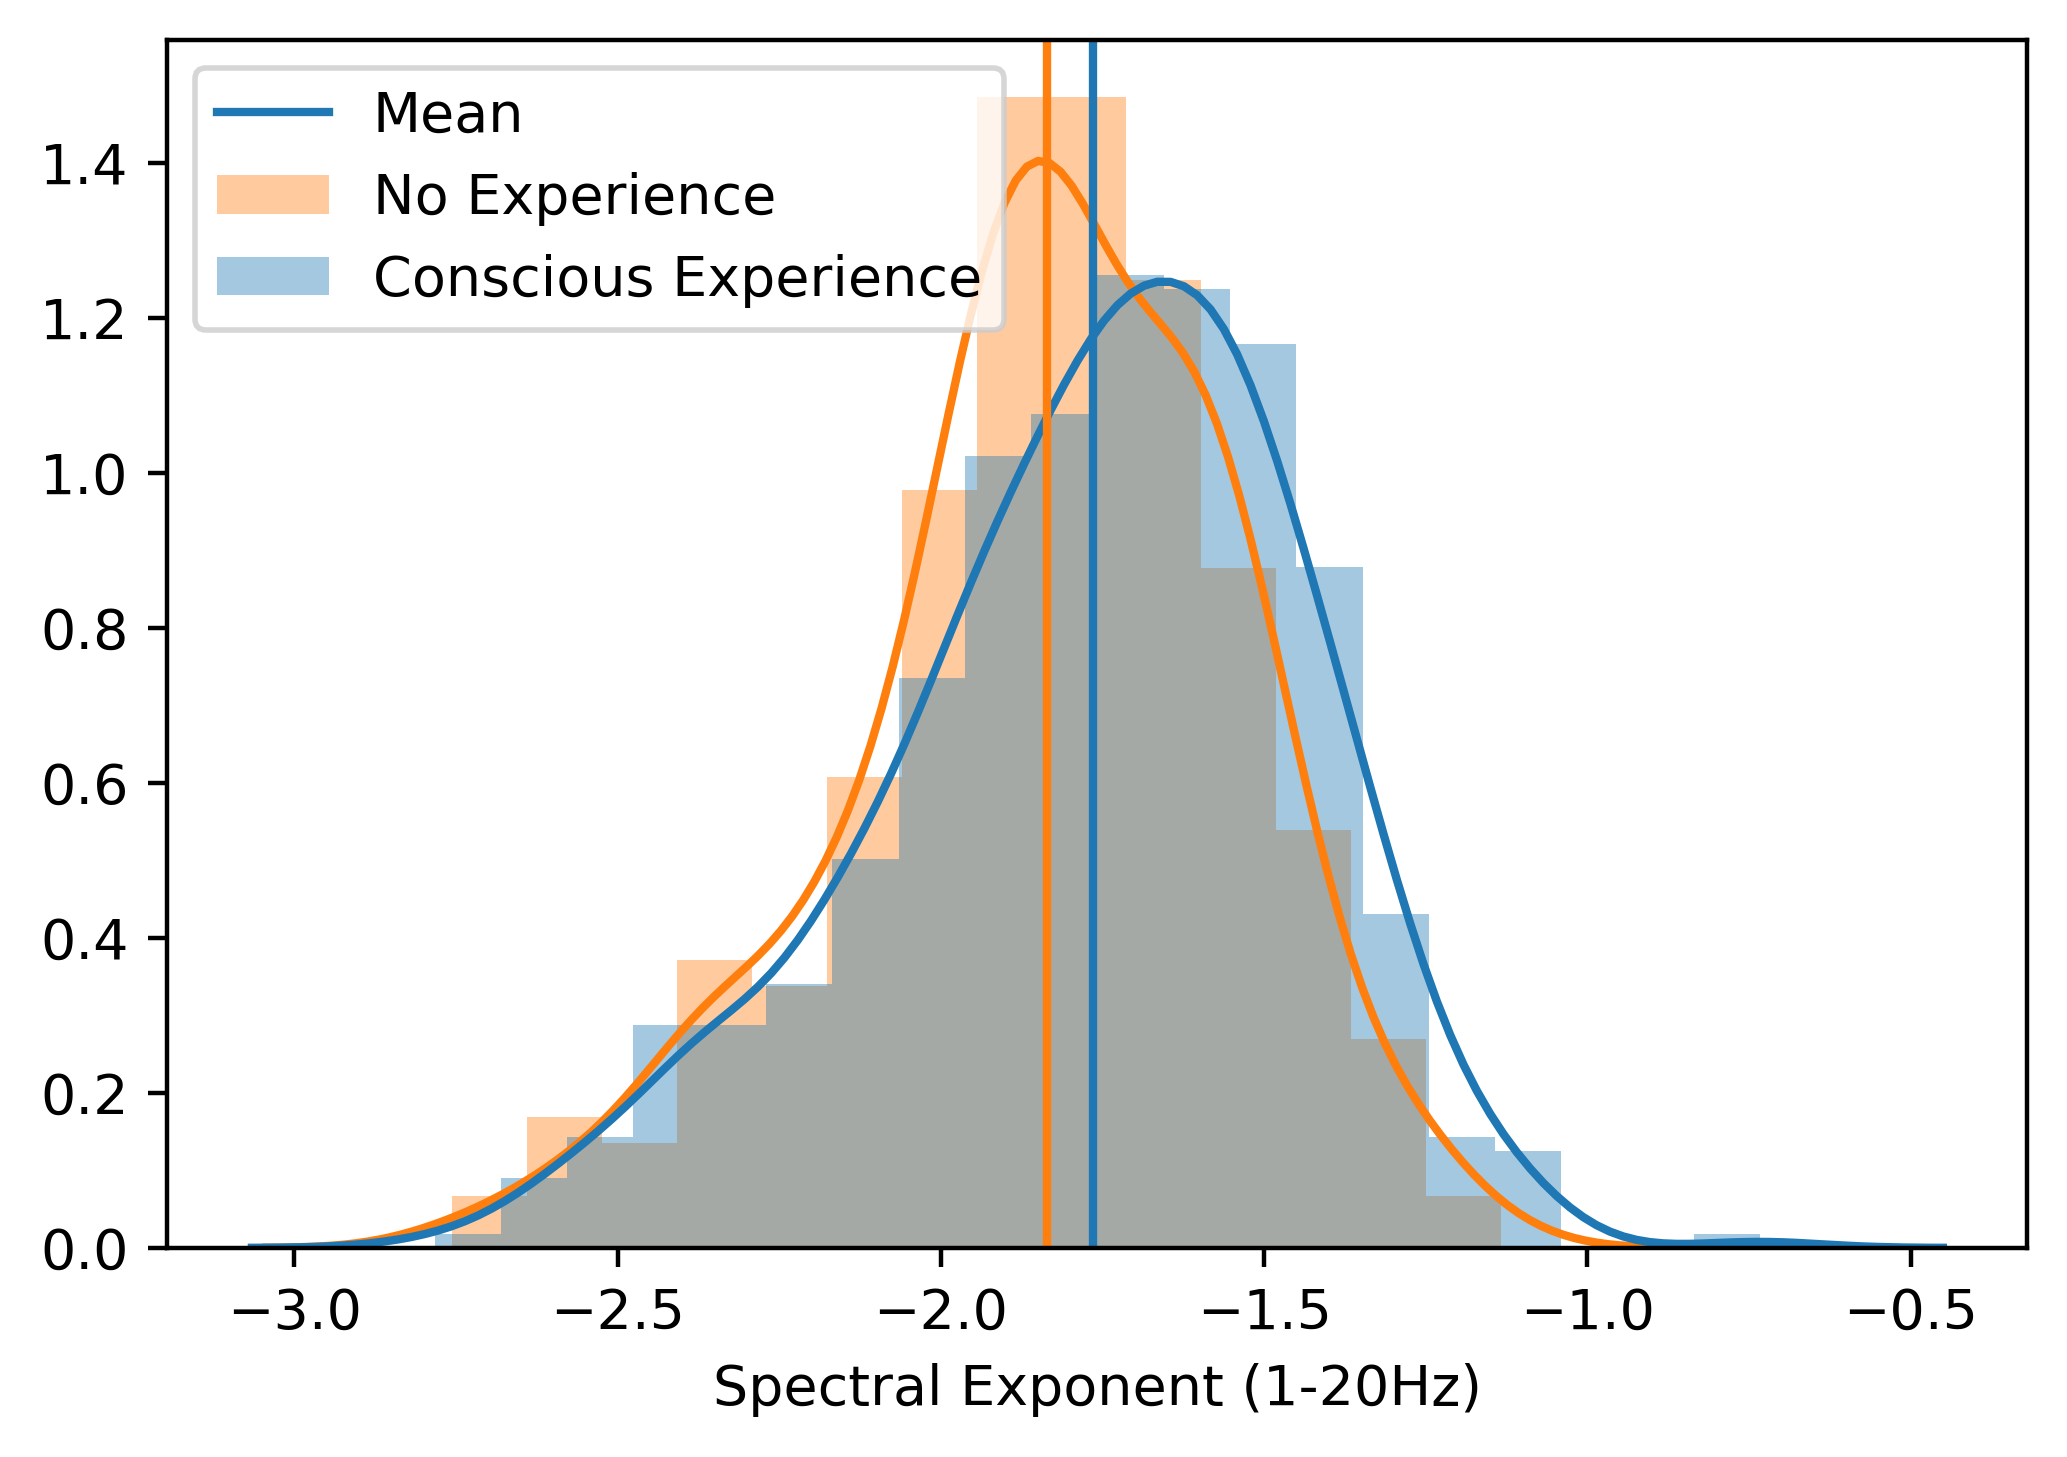

In [81]:
nrem_dataframe["REPORT_BINARY"] = "No Experience"
nrem_dataframe.loc[nrem_dataframe[(nrem_dataframe["Q1Experience"] != "NoReport")].index,"REPORT_BINARY"] = "Conscious Experience"

    
fig, ax=plt.subplots( dpi=400)

df_nona = nrem_dataframe[(nrem_dataframe["SPECEXP_1-20"].notna()) &\
#                          (nrem_dataframe["scoring_match"] == 1) &\
                         (nrem_dataframe["HOLD_OUT"] == False)].copy()

df_nona["Visit_Unique"] = df_nona["Visit"] + 1000*df_nona["ID"]

# df_nona = nrem_dataframe[(nrem_dataframe["SPECEXP_1-40"].notna())].copy()

# df_nona.loc[df_nona[df_nona["Q1Experience"] == "Something"].index,"Q1Experience"] = "Conscious Experience"
# df_nona.loc[df_nona[df_nona["Q1Experience"] == "Report"].index,"Q1Experience"] = "Conscious Experience"

plot = sns.distplot(df_nona[df_nona["REPORT_BINARY"] == "No Experience"]["SPECEXP_1-20"], hist=True, kde=True, 
             color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1],
                   label = "No Experience")
plot = sns.distplot(df_nona[df_nona["REPORT_BINARY"] == "Conscious Experience"]["SPECEXP_1-20"], hist=True, kde=True, 
             color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0],
                   label = "Conscious Experience")
# plot.legend()

plt.axvline(x=np.mean(df_nona[df_nona["REPORT_BINARY"] == "No Experience"]["SPECEXP_1-20"]),
                       color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.axvline(x=np.mean(df_nona[df_nona["REPORT_BINARY"] == "Conscious Experience"]["SPECEXP_1-20"]),
                      color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0],
           label = "Mean")

plot.legend()

# ax = sns.violinplot(x="Q1Experience", y="SPECEXP_1-40", data=df_nona)

df_nona["SPECEXP_1_20"] = df_nona["SPECEXP_1-20"].values
df_nona["Q1_DUMMY"] = 0
df_nona.loc[df_nona[df_nona["REPORT_BINARY"] == "Conscious Experience"].index,"Q1_DUMMY"] = 1

# nested variance component for visit within subject
vc = {'Visit_Unique': '0 + C(Visit_Unique)'}
md = sm.MixedLM.from_formula('SPECEXP_1_20 ~ Q1_DUMMY', vc_formula=vc,                                   
                         re_formula='1', groups='ID', data=df_nona)
mdf = md.fit()

# no nested variance component for visit
md = smf.mixedlm('SPECEXP_1_20 ~ Q1_DUMMY', df_nona, groups=df_nona["ID"])
mdf = md.fit()

plt.xlabel("Spectral Exponent (1-20Hz)")

print(mdf.summary())
print(mdf.pvalues)

# plot.ax_joint.axhline(y=3)
print(len(df_nona))



### Plot p values for each channel

In [88]:
nrem_dataframe["REPORT_BINARY"] = "No Experience"
nrem_dataframe.loc[nrem_dataframe[(nrem_dataframe["Q1Experience"] != "NoReport")].index,"REPORT_BINARY"] = "Conscious Experience"

df_nona = nrem_dataframe[(nrem_dataframe["SPECEXP_1-20"].notna()) &\
#                          (nrem_dataframe["scoring_match"] == 1) &\
                         (nrem_dataframe["HOLD_OUT"] == False)].copy()


spec_p_vals = []

for spec in ["SPECEXP_1-20_ALL","SPECEXP_20-40_ALL", "SPECEXP_1-40_ALL"]:
    features = np.vstack(df_nona[spec].values)
    
    p_vals = []
    for chan in range(0,185):
        print(chan)
        df_nona["y"] = features[:,chan]
        df_nona["Q1_DUMMY"] = 0
        df_nona.loc[df_nona[df_nona["REPORT_BINARY"] == "Conscious Experience"].index,"Q1_DUMMY"] = 1
        vc = {'Visit': '0 + C(Visit)'}
        md = sm.MixedLM.from_formula('y ~ Q1_DUMMY', 
                                     vc_formula=vc,                                   
                                     re_formula='1', 
                                     groups='ID', 
                                     data=df_nona)
        mdf = md.fit()

    #     print(mdf.summary())
        p_vals.append(mdf.pvalues['Q1_DUMMY'])
        
    spec_p_vals.append(np.array(p_vals))

0
1
2
3
4
5


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


6
7
8
9
10
11


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


12


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


13
14
15
16
17


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


18


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


19
20
21
22
23


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


24


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


25


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


26


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


27
28
29
30
31
32
33
34


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


35


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


83
84
85
86
87


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


88


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


89
90
91
92
93
94
95


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


96


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


97
98
99
100
101
102
103


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


104


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


105
106
107
108
109
110
111


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


112


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


113
114
115


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


116


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


117


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


118


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


119
120
121
122
123


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


180
181
182
183
184
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
0
1
2
3


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


4


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


5


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


6
7
8
9
10


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


11


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


12
13
14
15
16
17


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


18
19
20
21
22
23


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


24


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


25


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


26


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


27
28
29
30
31
32


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


33


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


34


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


35


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


36


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


37
38


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


39


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


40


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


41


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


42


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


43


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


44
45


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


46


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


47


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


48


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


49


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


50
51
52
53


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


54


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


55


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


56


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


57


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


58
59
60
61
62


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


63


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


64


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


65


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


66


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


67
68
69
70
71


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


72


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


73


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


74


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


75


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


76


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


77


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


78


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


79


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


80


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


81


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


82


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


83


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


84


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


85


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


86


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


87


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


88


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


89
90
91


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


92


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


93


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


94


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


95


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


96


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


97
98
99
100
101
102


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


103


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


104


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


105
106
107
108
109
110
111


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


112


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


113
114


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


115


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


116


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


117


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


118


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


119
120
121


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


122


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


123


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


124


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


125
126
127
128
129


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


130


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


131


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


132
133
134
135


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


154
155
156
157
158
159


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


160


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


161
162
163
164


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


165


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


166


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


167


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


168
169
170
171


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


172


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


173


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


174


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


175


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


176
177
178
179
180


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


181


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


182


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


183


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


184


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


0.23.dev0
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt


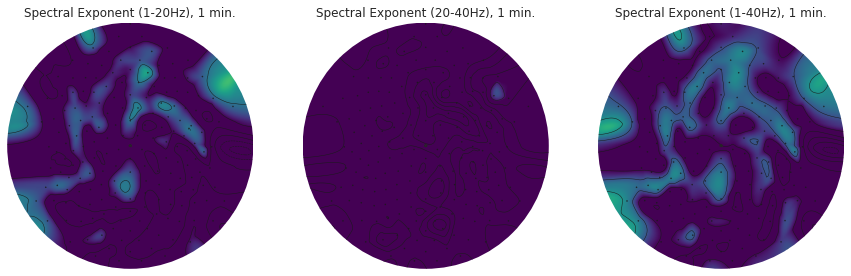

In [89]:
from matplotlib import cm, colors, colorbar
%matplotlib inline


print(mne.__version__)
raw = mne.io.read_raw_eeglab(data_folder + 'sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.set')
# Plot the topography of ranking

fig, axs = plt.subplots(1,3, figsize=(15,5))

titles = ["Spectral Exponent (1-20Hz), " + str(timerange) + " min.",
          "Spectral Exponent (20-40Hz), " + str(timerange) + " min.",
          "Spectral Exponent (1-40Hz), " + str(timerange) + " min."]

for i in range(0,3):
    sig_mask = np.array(spec_p_vals[i]) < 0.001
    mne.viz.plot_topomap(np.array(-1*np.log(spec_p_vals[i])), 
                         pos=raw.info, 
                         outlines='skirt',
                         mask=sig_mask,
                         vmin=2.99, 
                         vmax=7, 
                         show=False,
                         axes=axs[i],
                         cmap=cm.viridis,
                         res=150,
                         )
    axs[i].set_title(titles[i])
    

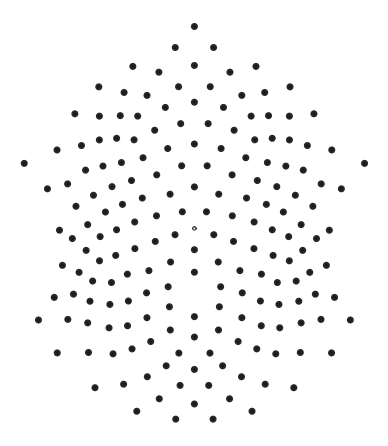

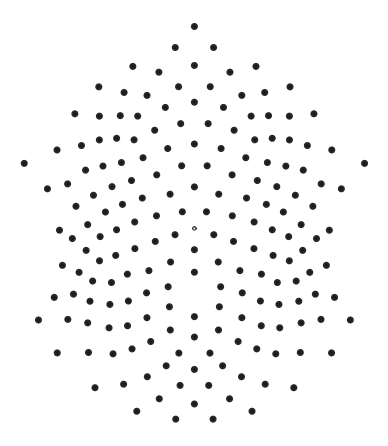

In [90]:
raw.plot_sensors()

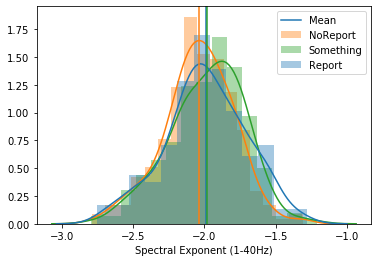

         Source     SS   DF     MS      F       p-unc    np2    eps
0  Q1Experience  0.162    2  0.081  4.938  0.00831177  0.059  0.961
1         Error  2.592  158  0.016      -           -      -      -
         Source     SS   DF     MS      F       p-unc    np2    eps
0  Q1Experience  0.231    2  0.115  6.055  0.00277612  0.055  0.955
1         Error  3.998  210  0.019      -           -      -      -


/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.2, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: SPECEXP_1_40
No. Observations: 544     Method:             REML        
No. Groups:       85      Scale:              0.0523      
Min. group size:  1       Likelihood:         -35.4327    
Max. group size:  19      Converged:          Yes         
Mean group size:  6.4                                     
-----------------------------------------------------------
           Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept  -1.977     0.022  -90.036  0.000  -2.020  -1.934
Q1_DUMMY   -0.004     0.022   -0.186  0.853  -0.048   0.040
ID Var      0.014     0.026                                
Visit Var   0.010     0.023                                

Intercept    0.000000
Q1_DUMMY     0.852712
ID Var       0.025090
Visit Var    0.053441
dtype: float64
544


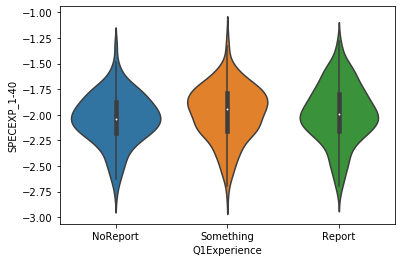

In [83]:
df_nona = nrem_dataframe[(nrem_dataframe["SPECEXP_1-40"].notna()) &\
#                          (nrem_dataframe["scoring_match"] == 1) &\
                         (nrem_dataframe["HOLD_OUT"] == False)].copy()

plot = sns.distplot(df_nona[df_nona["Q1Experience"] == "NoReport"]["SPECEXP_1-40"], hist=True, kde=True, 
             color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1],
                   label = "NoReport")
plot = sns.distplot(df_nona[df_nona["Q1Experience"] == "Something"]["SPECEXP_1-40"], hist=True, kde=True, 
             color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2],
                   label = "Something")
plot = sns.distplot(df_nona[df_nona["Q1Experience"] == "Report"]["SPECEXP_1-40"], hist=True, kde=True, 
             color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0],
                   label = "Report")
# plot.legend()

plt.axvline(x=np.mean(df_nona[df_nona["Q1Experience"] == "NoReport"]["SPECEXP_1-40"]),
                       color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.axvline(x=np.mean(df_nona[df_nona["Q1Experience"] == "Report"]["SPECEXP_1-40"]),
                      color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0],
                       label = "Mean")
plt.axvline(x=np.mean(df_nona[df_nona["Q1Experience"] == "Something"]["SPECEXP_1-40"]),
                      color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])

plot.legend()

plt.xlabel("Spectral Exponent (1-40Hz)")
plt.show()

ax = sns.violinplot(x="Q1Experience", y="SPECEXP_1-40", data=df_nona,
                   order=["NoReport","Something","Report"])

# df_nona["SPECEXP_1_40"] = df_nona["SPECEXP_1-40"].values
# md = smf.mixedlm("SPECEXP_1_40 ~ C(Q1Experience)", df_nona, groups=df_nona["ID"])
# mdf = md.fit()
# print(mdf.summary())
# print(mdf.pvalues)

import pingouin as pg
df_nona["SPECEXP_1_40"] = df_nona["SPECEXP_1-40"].values
df_nona["ID_plus_Visit"] = 100*df_nona["ID"].values + df_nona["Visit"].values

x = pg.rm_anova(data=df_nona, dv="SPECEXP_1-40", within="Q1Experience", subject="ID", detailed=True)
print(x)
x = pg.rm_anova(data=df_nona, dv="SPECEXP_1-40", within="Q1Experience", subject="ID_plus_Visit", detailed=True)
print(x)

df_nona["SPECEXP_1_40"] = df_nona["SPECEXP_1-40"].values
df_nona = df_nona[df_nona["Q1Experience"] != "NoReport"]
df_nona["Q1_DUMMY"] = 0
df_nona.loc[df_nona[df_nona["Q1Experience"] == "Report"].index,"Q1_DUMMY"] = 1
vc = {'Visit': '0 + C(Visit)'}
md = sm.MixedLM.from_formula('SPECEXP_1_40 ~ Q1_DUMMY', vc_formula=vc,                                   
                         re_formula='1', groups='ID', data=df_nona)
mdf = md.fit()

print(mdf.summary())
print(mdf.pvalues)

# plot.ax_joint.axhline(y=3)
print(len(df_nona))


AttributeError: 'PathCollection' object has no property 'hue'

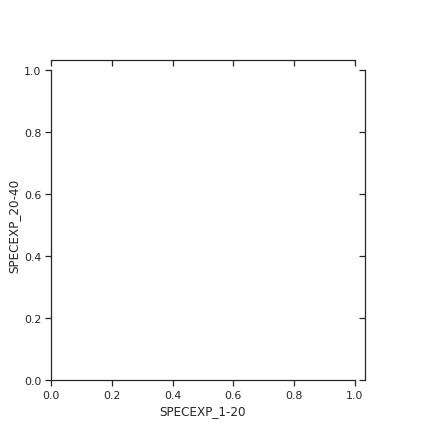

In [92]:
import seaborn as sns 

# fig, ax=plt.subplots( dpi=400)

nrem_dataframe["Report"] = "No Experience"
nrem_dataframe.loc[nrem_dataframe[(nrem_dataframe["Q1Experience"] != "NoReport")].index,"Report"] = "Conscious Experience"

  
df_nona = nrem_dataframe[(nrem_dataframe["SPECEXP_1-20"].notna()) &\
#                          (nrem_dataframe["scoring_match"] == 1) &\
                         (nrem_dataframe["HOLD_OUT"] == False)].copy()

df_nona.loc[df_nona[df_nona["Q1Experience"] == "Something"].index,"Q1Experience"] = "Report/Something"
df_nona.loc[df_nona[df_nona["Q1Experience"] == "Report"].index,"Q1Experience"] = "Report/Something"

plot = sns.jointplot(data=df_nona, 
#               size=8,
              s=8,
              alpha=0.5,
#               kind="kde",
              x="SPECEXP_1-20", 
              y="SPECEXP_20-40", 
              hue="Report")
plot.ax_marg_x.axvline(x=np.mean(df_nona[df_nona["Q1Experience"] == "Report/Something"]["SPECEXP_1-20"]),
                       color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
plot.ax_marg_x.axvline(x=np.mean(df_nona[df_nona["Q1Experience"] == "NoReport"]["SPECEXP_1-20"]),
                      color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])

plot.ax_marg_y.axhline(y=np.mean(df_nona[df_nona["Q1Experience"] == "Report/Something"]["SPECEXP_20-40"]),
                       color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
plot.ax_marg_y.axhline(y=np.mean(df_nona[df_nona["Q1Experience"] == "NoReport"]["SPECEXP_20-40"]),
                      color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])

plot.set_axis_labels(xlabel="LF Spectral Exponent (1-20Hz)", ylabel="HF Spectral Exponent (20-40Hz)",
                    fontsize=15)

# Change seaborn plot size
# fig = plt.gcf()
# fig.set_size_inches(6, 6)



df_nona["SPECEXP_1_20"] = df_nona["SPECEXP_1-20"].values
df_nona["SPECEXP_20_40"] = df_nona["SPECEXP_20-40"].values
df_nona["Q1_DUMMY"] = 0
df_nona.loc[df_nona[df_nona["Q1Experience"] == "Report/Something"].index,"Q1_DUMMY"] = 1

vc = {'Visit': '0 + C(Visit)'}
md = sm.MixedLM.from_formula('SPECEXP_1_20 ~ Q1_DUMMY', vc_formula=vc,                                   
                         re_formula='1', groups='ID', data=df_nona)
mdf = md.fit()

print(mdf.summary())
print(mdf.pvalues)

# plot.ax_joint.axhline(y=3)
print(len(df_nona))

         Source        SS   DF        MS         F     p-unc       np2  \
0  Q1Experience  0.218820    2  0.109410  6.343738  0.002305  0.083094   
1         Error  2.414573  140  0.017247       NaN       NaN       NaN   

        eps  
0  0.903027  
1       NaN  
         Source        SS   DF        MS          F  p-unc       np2       eps
0  Q1Experience  0.303862    2  0.151931 -21.109962    1.0 -0.431785  0.970644
1         Error -1.007597  140 -0.007197        NaN    NaN       NaN       NaN
584


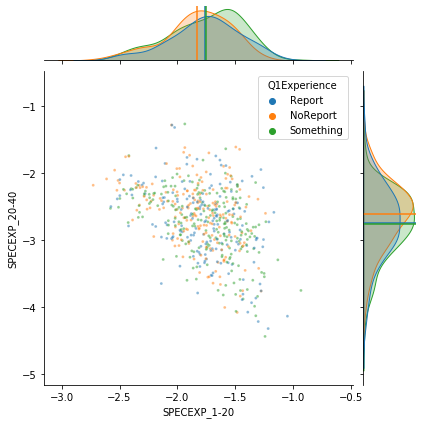

In [638]:
import seaborn as sns 

df_nona = nrem_dataframe[(nrem_dataframe["SPECEXP_1-20"].notna()) &\
                           (nrem_dataframe["scoring_match"] == 1) &\
                         (nrem_dataframe["HOLD_OUT"] == False)].copy()

plot = sns.jointplot(data=df_nona, 
              s=8,
              alpha=0.5,
#               kind="kde",
              x="SPECEXP_1-20", 
              y="SPECEXP_20-40", 
              hue="Q1Experience")

plot.ax_marg_x.axvline(x=np.mean(df_nona[df_nona["Q1Experience"] == "Report"]["SPECEXP_1-20"]),
                       color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
plot.ax_marg_x.axvline(x=np.mean(df_nona[df_nona["Q1Experience"] == "NoReport"]["SPECEXP_1-20"]),
                      color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plot.ax_marg_x.axvline(x=np.mean(df_nona[df_nona["Q1Experience"] == "Something"]["SPECEXP_1-20"]),
                      color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])

plot.ax_marg_y.axhline(y=np.mean(df_nona[df_nona["Q1Experience"] == "Report"]["SPECEXP_20-40"]),
                       color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
plot.ax_marg_y.axhline(y=np.mean(df_nona[df_nona["Q1Experience"] == "NoReport"]["SPECEXP_20-40"]),
                      color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plot.ax_marg_y.axhline(y=np.mean(df_nona[df_nona["Q1Experience"] == "Something"]["SPECEXP_20-40"]),
                      color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])

from pingouin import mixed_anova, read_dataset
import pingouin

# aov = mixed_anova(dv="SPECEXP_1-20", between="Q1Experience",
#                   subject="ID", data=df_nona)

x = pg.rm_anova(data=df_nona, dv="SPECEXP_1-20", within="Q1Experience", subject="ID", detailed=True)
print(x)
x = pg.rm_anova(data=df_nona, dv="SPECEXP_20-40", within="Q1Experience", subject="ID", detailed=True)
print(x)


# print(aov)

print(len(df_nona))

In [35]:
from matplotlib.ticker import ScalarFormatter    
    
for FREQS in ["20-40","1-40","1-20", ]:
    
    for condition in ["NoReport","Something", "Report"]:

        df_nona = nrem_dataframe[(nrem_dataframe[("SPECEXP_" + FREQS)].notna()) &\
                                 (nrem_dataframe["Q1Experience"] == condition) &\
                                 (nrem_dataframe["scoring_match"] == 1) &\
                                 (nrem_dataframe["HOLD_OUT"] == False)].copy()
        df_nona = df_nona.reset_index(drop=True)

        night_average = [];
        for i in range(0,len(df_nona)):
            night_average.append(df_nona.loc[i][("OBS_" + FREQS)])


        night_average = np.array(night_average)
        time_series_df = pd.DataFrame(np.transpose(night_average)) # axis 0 is frequencies, axis 1 is subjects


        #Plotting:
        plt.plot(df_nona.loc[0][("FREQ_" + FREQS)],np.mean(time_series_df,axis=1), 
                 linewidth=2, label=condition) #mean curve.
        
        
        low_i = [] # lower bound bootstrap
        high_i = [] # higher bound bootstrap
        for i in range(0,len(df_nona.loc[0][("FREQ_" + FREQS)])):
            boot_means = []
            for _ in range(500):
                boot_sample = np.random.choice(time_series_df.loc[i],
                                               replace = True, 
                                               size = len(time_series_df.loc[i])) # take a random sample each iteration
                boot_mean = np.mean(boot_sample)# calculate the mean for each iteration
                boot_means.append(boot_mean) # append the mean to boot_means
            
            boot_means_np = np.array(boot_means) # transform it into a numpy array for calculation
            low_i.append(np.percentile(boot_means_np, 0.5)) # 99% C.I.)
            high_i.append(np.percentile(boot_means_np, 99.5))
        
        low_i = np.array(low_i) 
        high_i = np.array(high_i)
            
        plt.fill_between(np.array(df_nona.loc[0][("FREQ_" + FREQS)]), 
                         low_i, 
                         high_i, 
                         alpha=.3) 
        
        plt.xlabel("Frequency")
        plt.ylabel("PSD")
        
    
    ax = plt.gca()
    import matplotlib.ticker as ticker
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    if FREQS == "1-40":
        x = [1, 2, 5, 10, 20, 40] 
        plt.xticks(x,x)
    if FREQS == "1-20":
        x = [1, 2, 5, 10, 20] 
        plt.xticks(x,x)
    if FREQS == "20-40":
        x = [20, 25, 30, 35, 40] 
        plt.xticks(x,x)

    plt.legend()
    plt.show()

ValueError: Must pass 2-d input

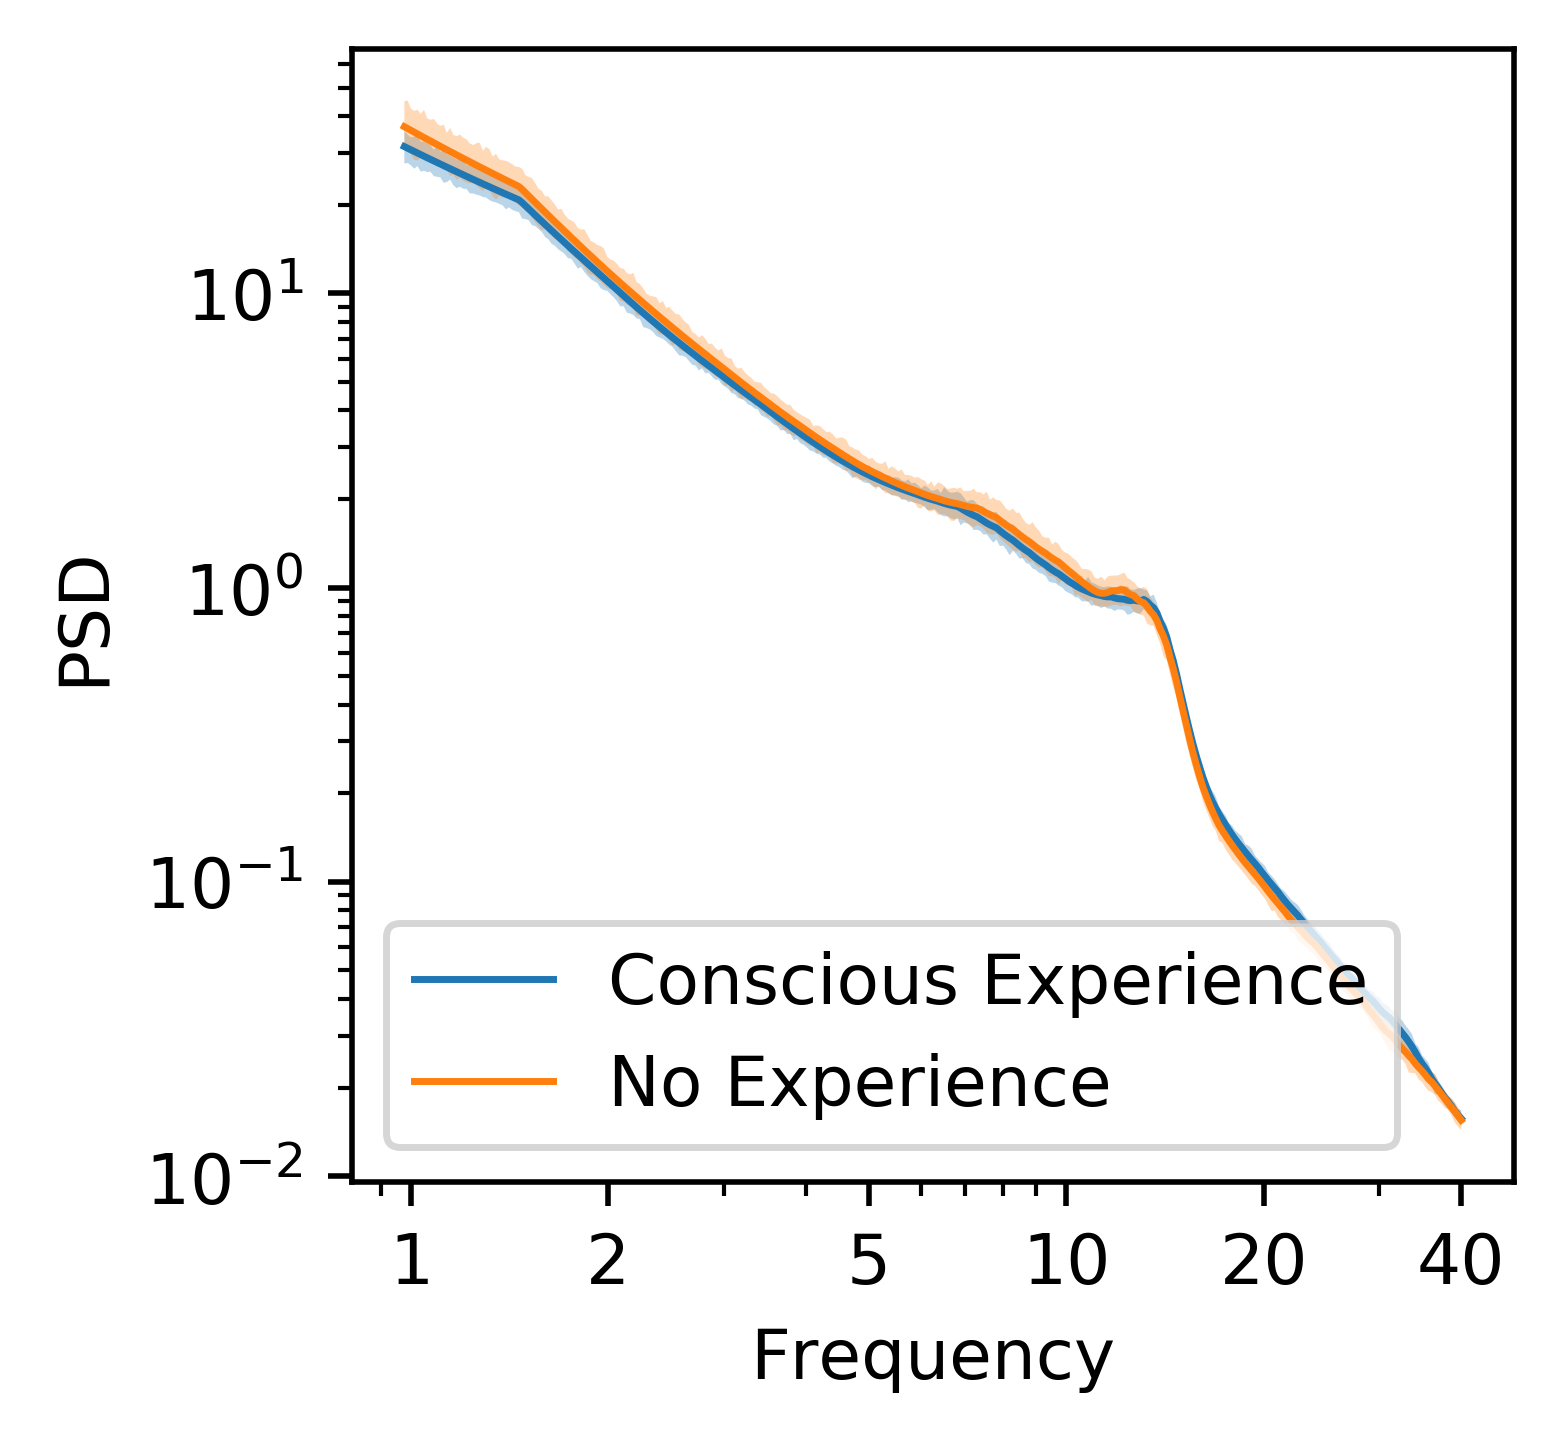

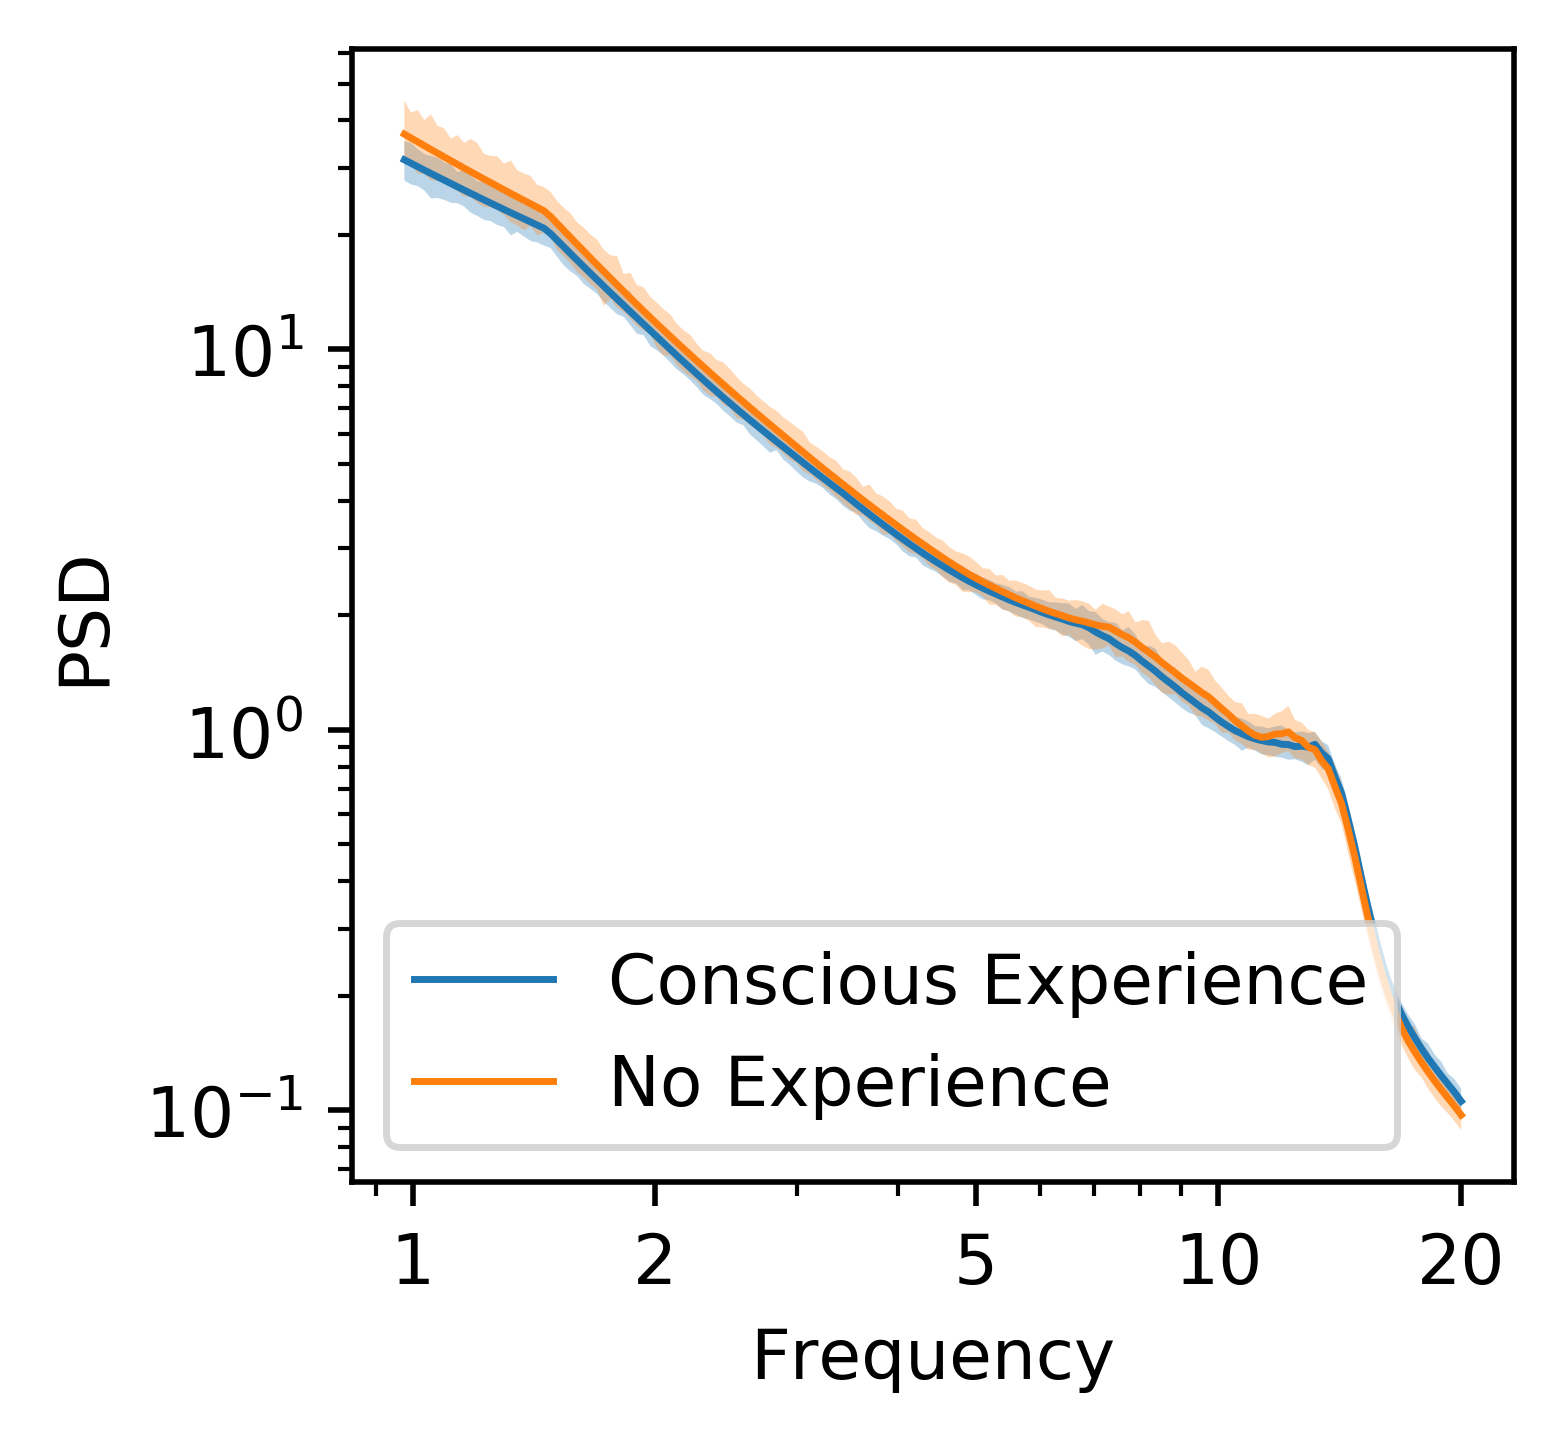

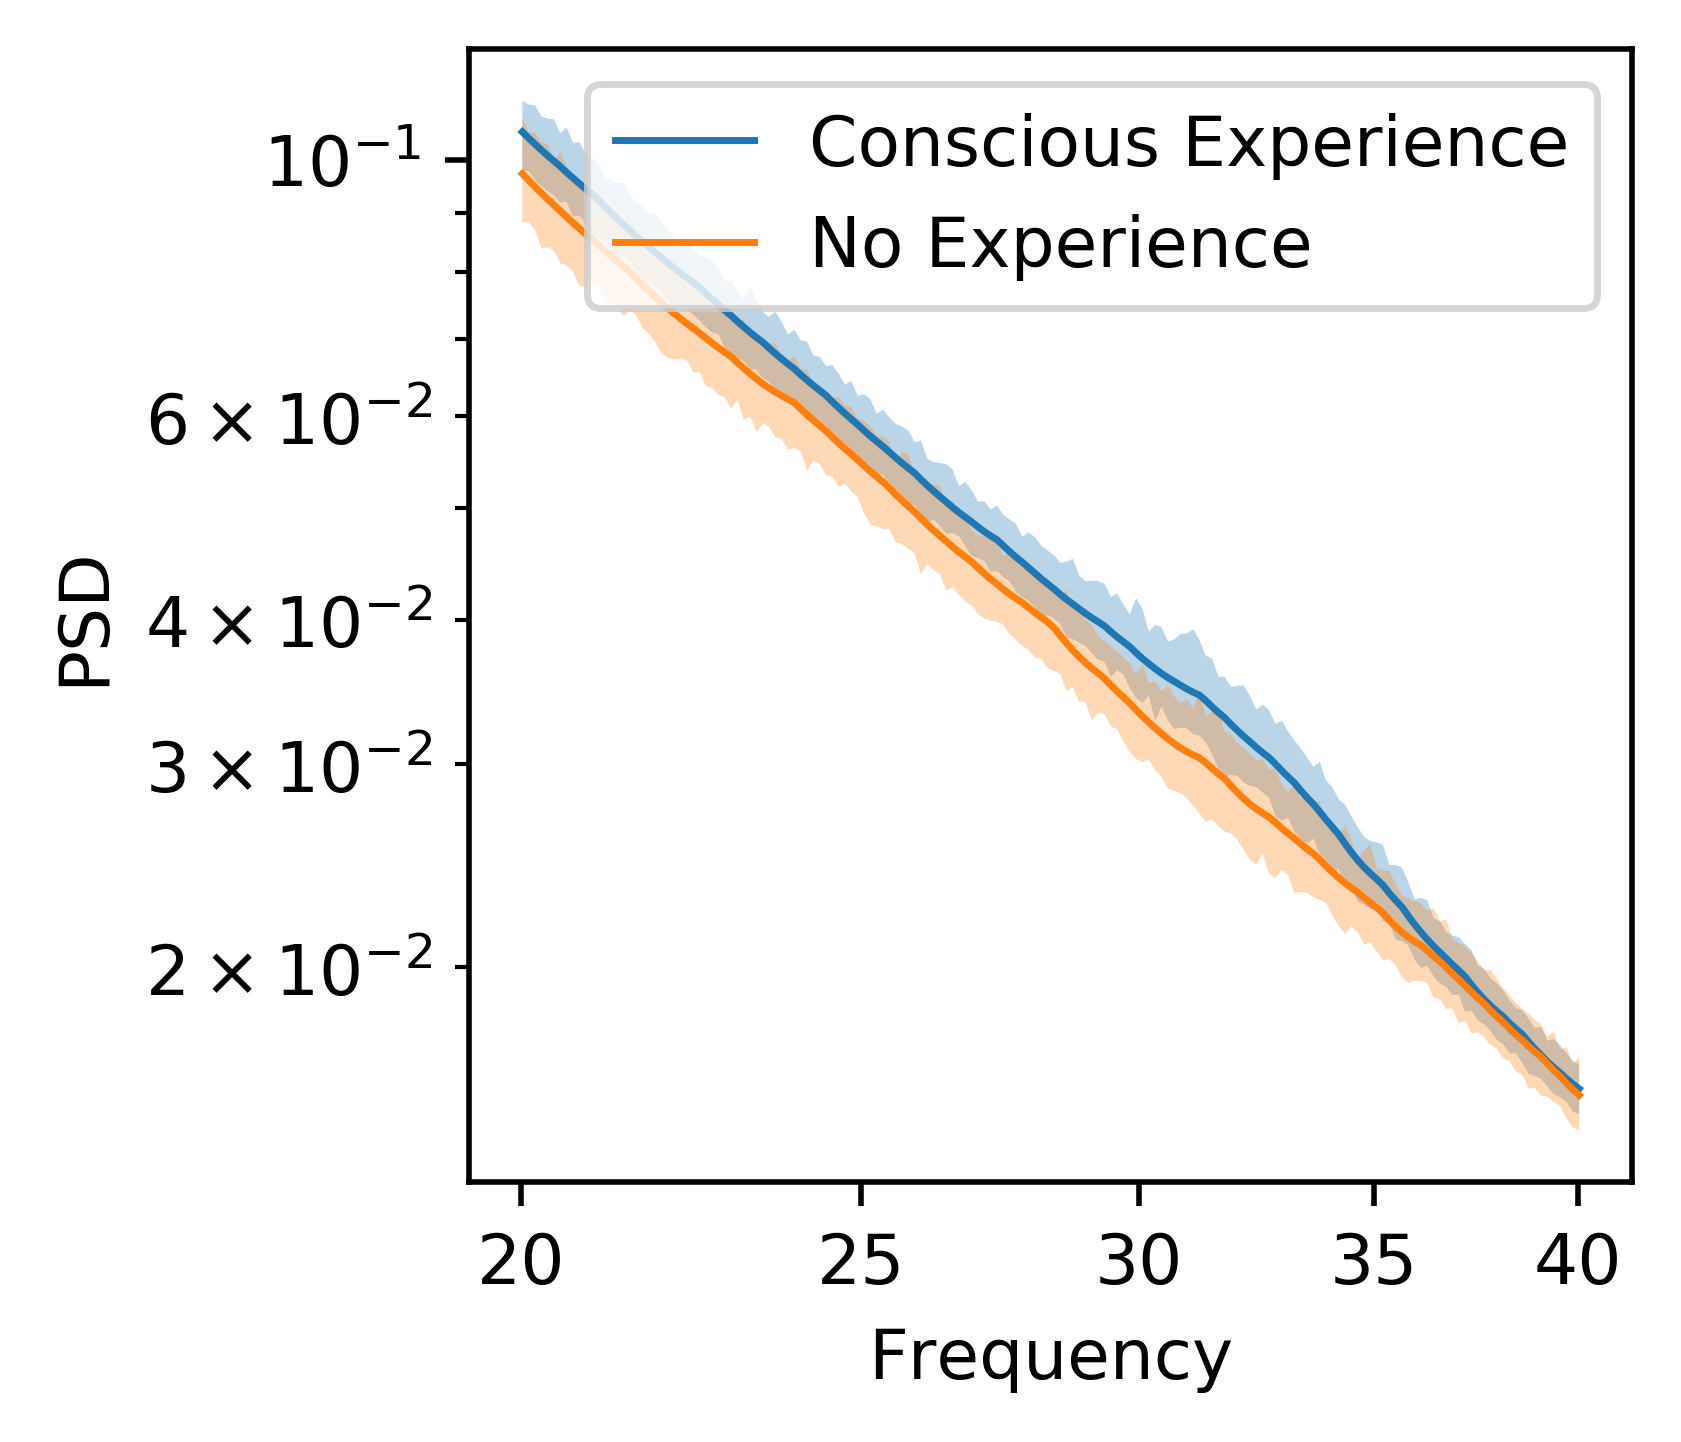

In [78]:
from matplotlib.ticker import ScalarFormatter 

nrem_dataframe["REPORT_BINARY"] = "No Experience"
nrem_dataframe.loc[nrem_dataframe[(nrem_dataframe["Q1Experience"] != "NoReport")].index,"REPORT_BINARY"] = "Conscious Experience"

    
for FREQS in ["1-40", "1-20", "20-40", ]:
    
    fig, ax=plt.subplots(figsize=(3,3),dpi=500)
    
    for condition in ["Conscious Experience","No Experience"]:

        df_nona = nrem_dataframe[(nrem_dataframe[("SPECEXP_" + FREQS)].notna()) &\
                                 (nrem_dataframe["REPORT_BINARY"] == condition) &\
                                 (nrem_dataframe["scoring_match"] == 1) &\
                                 (nrem_dataframe["HOLD_OUT"] == False)].copy()
        df_nona = df_nona.reset_index(drop=True)

        night_average = []; # across subjects
        for i in range(0,len(df_nona)):
            night_average.append(df_nona.loc[i][("OBS_" + FREQS)])

        night_average = np.array(night_average)
        time_series_df = pd.DataFrame(np.transpose(night_average)) # axis 1 is frequencies, axis 0 is subjects


        #Plotting:
        plt.plot(df_nona.loc[0][("FREQ_" + FREQS)],np.mean(time_series_df,axis=1), 
                 linewidth=1, label=condition) #mean curve.
        
        
        low_i = [] # lower bound bootstrap
        high_i = [] # higher bound bootstrap
        for i in range(0,len(df_nona.loc[0][("FREQ_" + FREQS)])):
            boot_means = []
            for _ in range(200):
                boot_sample = np.random.choice(time_series_df.loc[i],
                                               replace = True, 
                                               size = len(time_series_df.loc[i])) # take a random sample each iteration
                boot_mean = np.mean(boot_sample)# calculate the mean for each iteration
                boot_means.append(boot_mean) # append the mean to boot_means
            
            boot_means_np = np.array(boot_means) # transform it into a numpy array for calculation
            low_i.append(np.percentile(boot_means_np, 0.5)) # 99% C.I.)
            high_i.append(np.percentile(boot_means_np, 99.5))
        
        low_i = np.array(low_i) 
        high_i = np.array(high_i)
            
        plt.fill_between(df_nona.loc[0][("FREQ_" + FREQS)], 
                         low_i, 
                         high_i, 
                         alpha=.3) 
        
        plt.xlabel("Frequency")
        plt.ylabel("PSD")
        
    
    ax = plt.gca()
    import matplotlib.ticker as ticker
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    if FREQS == "1-40":
        x = [1, 2, 5, 10, 20, 40] 
        plt.xticks(x,x)
    if FREQS == "1-20":
        x = [1, 2, 5, 10, 20] 
        plt.xticks(x,x)
    if FREQS == "20-40":
        x = [20, 25, 30, 35, 40] 
        plt.xticks(x,x)

    plt.legend()
    plt.show()

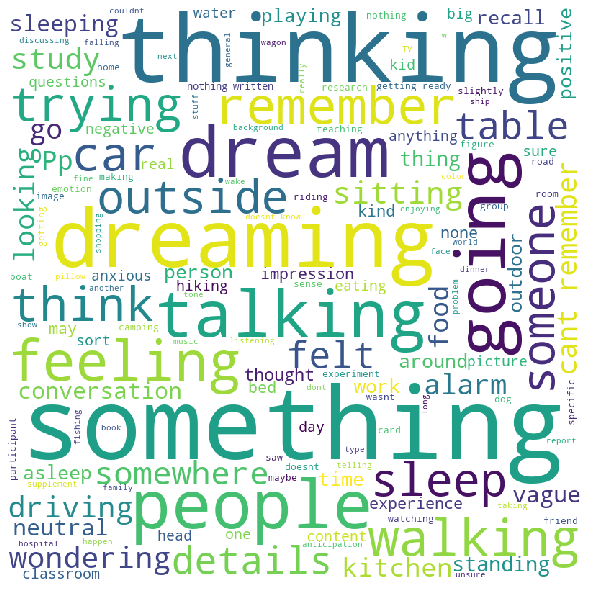

In [40]:
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  
# Reads 'Youtube04-Eminem.csv' file  
# df = pd.read_csv(r"Youtube04-Eminem.csv", encoding ="latin-1") 
  
comment_words = '' 
# stopwords = set(STOPWORDS) 
  
x = ''.join(str(nrem_dataframe[nrem_dataframe['Q1Experience'] != 'NoReport']['Q1Report'].values))
x = x.replace('\n', '')
x = x.replace('nan', '')
x = x.replace('Participant', '')
x = x.replace('ppt', '')
x = x.replace("'", '')
x = x.replace('"', '')
x = x.replace('.', '')

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
#                 stopwords = stopwords, 
                min_font_size = 10).generate(x) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

In [85]:
nrem_dataframe["REPORT_BINARY"] = "No Experience"
nrem_dataframe.loc[nrem_dataframe[(nrem_dataframe["Q1Experience"] != "NoReport")].index,"REPORT_BINARY"] = "Conscious Experience"

df_nona = nrem_dataframe[(nrem_dataframe["SPECEXP_1-20"].notna()) &\
#                          (nrem_dataframe["scoring_match"] == 1) &\
                         (nrem_dataframe["Q1Experience"] != "Something") &\
                         (nrem_dataframe["HOLD_OUT"] == False)].copy()
df_nona["Visit_Unique"] = df_nona["Visit"] + 1000*df_nona["ID"]

print(len(df_nona))

df_nona = df_nona.reset_index(drop=True)

# shorten dataframe for quicker plotting
df_nona = df_nona.loc[0:50].copy()

# get band peaks per night
night = []
for i in range(0,len(df_nona["OBS_1-40_ALL"].values)):
    chan = []
    print(i)
#     features.append(np.hstack(nrem_dataframe["OBS_1-40_ALL"].values[i]))
    for j in range(0,185):
        y = []
        for f in [[0,4],[4,8],[8,13],[13,30],[30,50]]:
            a = np.where(np.array(df_nona["FREQ_1-40"][0]) >= f[0])
            b = np.where(np.array(df_nona["FREQ_1-40"][0]) <= f[1])
            c = np.intersect1d(a,b)
#             print(c)
            y.append(np.average(np.array(df_nona["OBS_1-40_ALL"][i])[c,j]))
#             print(np.array(y).shape)
            
        chan.append(np.squeeze(np.array(y)))
#         print(np.array(chan).shape)
    
    night.append(np.array(chan))


518
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [87]:
# remove held out dataset, bad scoring matches, and "Something" reports
nrem_dataframe = nrem_dataframe[(nrem_dataframe["Q1Experience"] != "Something") &\
#                                 (nrem_dataframe["scoring_match"] == 1) &\
                                (nrem_dataframe["HOLD_OUT"] == False)].copy()

nrem_dataframe = nrem_dataframe.reset_index(drop=True)

data_folder = '/data/tvanasse/nccam3/data/'

nrem_dataframe["PSDS_60SEC_1TO50HZ"] = np.array(0).astype('object') #create object so arrays can be added

psds_list = []
for i in range(0,len(nrem_dataframe)):
    print(i)
    start_index = nrem_dataframe['PATH'][i].find('sub')
    nrem_dataframe.loc[i,'SHORT_PATH'] = nrem_dataframe['PATH'][i][start_index:]

    raw = mne.io.read_raw_eeglab(data_folder + nrem_dataframe['PATH'][i][start_index:])

    psds, freqs = mne.time_frequency.psd_welch(raw,
                                               tmin = raw.times[-1]-60,
                                               tmax = raw.times[-1],
                                               fmin=1., fmax=50.,
                                               n_fft=1024,
                                               average=None,
    #                                            n_overlap = 50,
    #                                            average=None,
    #                                            n_jobs=15)
                                              )

    nrem_dataframe.at[i,"PSDS_60SEC_1TO50HZ"] = psds.tolist()

0
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-5-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
1
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-1-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
2
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-9-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
3
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
4
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-2-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
5
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-3-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
6
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-8-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
7
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-4-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
8
Reading /data/tvanasse/nccam3/data/sub

68
Reading /data/tvanasse/nccam3/data/sub-2024/eeg/ses-1/awakening-6-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
69
Reading /data/tvanasse/nccam3/data/sub-2024/eeg/ses-1/awakening-3-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
70
Reading /data/tvanasse/nccam3/data/sub-2024/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
71
Reading /data/tvanasse/nccam3/data/sub-2026/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
72
Reading /data/tvanasse/nccam3/data/sub-2026/eeg/ses-1/awakening-3-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
73
Reading /data/tvanasse/nccam3/data/sub-2026/eeg/ses-1/awakening-4-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
74
Reading /data/tvanasse/nccam3/data/sub-2026/eeg/ses-1/awakening-5-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
75
Reading /data/tvanasse/nccam3/data/sub-2028/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
76
Reading /data/tvanasse/nccam3

Effective window size : 2.048 (s)
136
Reading /data/tvanasse/nccam3/data/sub-2042/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
137
Reading /data/tvanasse/nccam3/data/sub-2042/eeg/ses-1/awakening-8-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
138
Reading /data/tvanasse/nccam3/data/sub-2042/eeg/ses-1/awakening-1-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
139
Reading /data/tvanasse/nccam3/data/sub-2042/eeg/ses-3/awakening-4-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
140
Reading /data/tvanasse/nccam3/data/sub-2043/eeg/ses-2/awakening-5-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
141
Reading /data/tvanasse/nccam3/data/sub-2043/eeg/ses-2/awakening-8-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
142
Reading /data/tvanasse/nccam3/data/sub-2043/eeg/ses-2/awakening-2-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
143
Reading /data/tvanasse/nccam3/data/sub-2043/eeg/ses-2/awakening-6-cleaned2_nrem.fdt
Effective window size : 

203
Reading /data/tvanasse/nccam3/data/sub-2058/eeg/ses-2/awakening-3-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
204
Reading /data/tvanasse/nccam3/data/sub-2058/eeg/ses-2/awakening-7-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
205
Reading /data/tvanasse/nccam3/data/sub-2060/eeg/ses-1/awakening-2-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
206
Reading /data/tvanasse/nccam3/data/sub-2060/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
207
Reading /data/tvanasse/nccam3/data/sub-2060/eeg/ses-2/awakening-7-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
208
Reading /data/tvanasse/nccam3/data/sub-2060/eeg/ses-2/awakening-3-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
209
Reading /data/tvanasse/nccam3/data/sub-2061/eeg/ses-1/awakening-1-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
210
Reading /data/tvanasse/nccam3/data/sub-2061/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
211
Reading /data/tvanas

Effective window size : 2.048 (s)
271
Reading /data/tvanasse/nccam3/data/sub-2070/eeg/ses-1/awakening-8-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
272
Reading /data/tvanasse/nccam3/data/sub-2070/eeg/ses-1/awakening-5-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
273
Reading /data/tvanasse/nccam3/data/sub-2070/eeg/ses-1/awakening-10-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
274
Reading /data/tvanasse/nccam3/data/sub-2070/eeg/ses-1/awakening-3-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
275
Reading /data/tvanasse/nccam3/data/sub-2070/eeg/ses-1/awakening-4-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
276
Reading /data/tvanasse/nccam3/data/sub-2070/eeg/ses-1/awakening-9-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
277
Reading /data/tvanasse/nccam3/data/sub-2071/eeg/ses-1/awakening-1-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
278
Reading /data/tvanasse/nccam3/data/sub-2071/eeg/ses-1/awakening-5-cleaned2_nrem.fdt
Effective window size :

338
Reading /data/tvanasse/nccam3/data/sub-2085/eeg/ses-1/awakening-8-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
339
Reading /data/tvanasse/nccam3/data/sub-2086/eeg/ses-3/awakening-12-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
340
Reading /data/tvanasse/nccam3/data/sub-2086/eeg/ses-3/awakening-5-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
341
Reading /data/tvanasse/nccam3/data/sub-2086/eeg/ses-3/awakening-2-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
342
Reading /data/tvanasse/nccam3/data/sub-2086/eeg/ses-3/awakening-3-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
343
Reading /data/tvanasse/nccam3/data/sub-2087/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
344
Reading /data/tvanasse/nccam3/data/sub-2087/eeg/ses-1/awakening-10-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
345
Reading /data/tvanasse/nccam3/data/sub-2087/eeg/ses-1/awakening-9-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
346
Reading /data/tvan

Effective window size : 2.048 (s)
406
Reading /data/tvanasse/nccam3/data/sub-2106/eeg/ses-1/awakening-5-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
407
Reading /data/tvanasse/nccam3/data/sub-2111/eeg/ses-2/awakening-1-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
408
Reading /data/tvanasse/nccam3/data/sub-2111/eeg/ses-2/awakening-7-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
409
Reading /data/tvanasse/nccam3/data/sub-2111/eeg/ses-2/awakening-8-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
410
Reading /data/tvanasse/nccam3/data/sub-2111/eeg/ses-2/awakening-2-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
411
Reading /data/tvanasse/nccam3/data/sub-2111/eeg/ses-2/awakening-3-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
412
Reading /data/tvanasse/nccam3/data/sub-2111/eeg/ses-3/awakening-1-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
413
Reading /data/tvanasse/nccam3/data/sub-2111/eeg/ses-3/awakening-10-cleaned2_nrem.fdt
Effective window size :

473
Reading /data/tvanasse/nccam3/data/sub-2133/eeg/ses-3/awakening-4-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
474
Reading /data/tvanasse/nccam3/data/sub-2134/eeg/ses-1/awakening-1-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
475
Reading /data/tvanasse/nccam3/data/sub-2134/eeg/ses-1/awakening-10-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
476
Reading /data/tvanasse/nccam3/data/sub-2134/eeg/ses-1/awakening-11-cleaned2_nrem.fdt
Effective window size : 2.048 (s)
477
Reading /data/tvanasse/nccam3/data/sub-2134/eeg/ses-1/awakening-15-cleaned2_nrem.fdt


KeyboardInterrupt: 

In [94]:
# get band peaks
features = []
for i in range(0,len(nrem_dataframe['PSDS_60SEC_1TO50HZ'].values)):
    print(i)
#     features.append(np.hstack(nrem_dataframe["OBS_1-40_ALL"].values[i]))
    y = []
        
    for f in [[0,4],[4,8],[8,13],[13,30],[30,50]]:
        a = np.where(freqs >= f[0])
        b = np.where(freqs <= f[1])
        c = np.intersect1d(a,b)
        y.append(np.average(np.array(nrem_dataframe['PSDS_60SEC_1TO50HZ'][i])[:,c,:], axis=(1,2)))  
            
    features.append(np.array(y))
    
features = np.array(features)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

IndexError: too many indices for array

In [ ]:
from matplotlib import cm, colors, colorbar
%matplotlib inline


print(mne.__version__)
raw = mne.io.read_raw_eeglab(data_folder + 'sub-2001/eeg/ses-3/awakening-1-cleaned2_nrem.set')
# Plot the topography of ranking

fig, axs = plt.subplots(1,5, figsize=(15,5))

timerange = 60
titles = ["Delta (1-4Hz), " + str(timerange) + " min.",
          "Theta (4-8Hz), " + str(timerange) + " min.",
          "Alpha (8-13Hz), " + str(timerange) + " min.",
          "Beta (13-30Hz), " + str(timerange) + " min.",
          "Gamma (30-50Hz), " + str(timerange) + " min."]

# p_threshold = 0.005
for row in range(0,1):
    for j in range(0,5):      
#         sig_mask = np.array(psd_avg_vals[j]) < p_threshold
        measure = np.mean(features[:,j,:],axis=0)
#         vmin, vmax = -5,5
        cmap = cm.viridis

        mne.viz.plot_topomap(measure, 
                             pos=raw.info, 
#                              outlines='skirt',
#                              mask=sig_mask,
#                              vmin=np.min(measure), 
#                              vmax=np.max(measure), 
                             show=False,
                             axes=axs[j],
                             cmap=cmap,
                             res=150,
#                              cbar_fmt='-%0.1f',
                             )
        if row == 0:
            axs[j].set_title(titles[j])
        if (j == 0) and (row == 0):
            axs[j].set_ylabel('Average Power Across ' + str(len(features)) + ' Awakenings', size='large')

In [ ]:
nrem_dataframe["REPORT_BINARY"] = "No Experience"
nrem_dataframe.loc[nrem_dataframe[(nrem_dataframe["Q1Experience"] != "NoReport")].index,"REPORT_BINARY"] = "Conscious Experience"

psd_p_vals = []
psd_t_vals = []

for eegrange in range(0,5):
    
    p_vals = []
    t_vals = []
    avg_vals = []
    for chan in range(0,185):
        print(chan)
        nrem_dataframe["y"] = np.lofeatures[:,eegrange,chan]
        nrem_dataframe["Q1_DUMMY"] = 0
        nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["REPORT_BINARY"] == "Conscious Experience"].index,"Q1_DUMMY"] = 1
        
        
#         model with nested variance component
        vc = {'Visit': '0 + C(Visit)'}
        md = sm.MixedLM.from_formula('y ~ Q1_DUMMY', 
                                     vc_formula=vc,                                   
                                     re_formula='1', 
                                     groups='ID', 
                                     data=nrem_dataframe)
        mdf = md.fit()
        
#         # no nested variance component for visit
#         md = smf.mixedlm('y ~ Q1_DUMMY', nrem_dataframe, groups=nrem_dataframe["ID"])
#         mdf = md.fit()

    #     print(mdf.summary())
        p_vals.append(mdf.pvalues['Q1_DUMMY'])
        t_vals.append(mdf.tvalues['Q1_DUMMY'])
        
    psd_p_vals.append(np.array(p_vals))
    psd_t_vals.append(np.array(t_vals))

In [ ]:
from matplotlib import cm, colors, colorbar
%matplotlib inline


print(mne.__version__)
raw = mne.io.read_raw_eeglab(data_folder + 'sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.set')
# Plot the topography of ranking

fig, axs = plt.subplots(2,5, figsize=(15,5))

timerange = 1
titles = ["Delta (1-4Hz), " + str(timerange) + " min.",
          "Theta (4-8Hz), " + str(timerange) + " min.",
          "Alpha (8-13Hz), " + str(timerange) + " min.",
          "Beta (13-30Hz), " + str(timerange) + " min.",
          "Gamma (30-50Hz), " + str(timerange) + " min."]

p_threshold = 0.001
for row in range(0,2):
    for j in range(0,5):
        if row == 0:
            sig_mask = np.array(psd_p_vals[j]) < p_threshold
            measure = np.array(-1*np.log(psd_p_vals[j]))
            vmin, vmax = 2.0, 6
            cmap = cm.viridis
        elif row == 1:
            sig_mask = np.array(psd_p_vals[j]) < p_threshold
            measure = np.array(psd_t_vals[j])
            vmin, vmax = -5,5
            cmap = cm.bwr

        mne.viz.plot_topomap(measure, 
                             pos=raw.info, 
                             outlines='skirt',
                             mask=sig_mask,
                             vmin=vmin, 
                             vmax=vmax, 
                             show=False,
                             axes=axs[row,j],
                             cmap=cmap,
                             res=150,
#                              cbar_fmt='-%0.1f',
                             )
        if row == 0:
            axs[row,j].set_title(titles[j])
        if (j == 0) and (row == 0):
            axs[row,j].set_ylabel('-LOG(P)', size='large')
        if (j == 0) and (row == 1):
            axs[row,j].set_ylabel('T-Stat (DE - NE)', size='large')